## Conectar con BBDD

In [39]:
from langchain_community.utilities import SQLDatabase

usuario = 'postgres'
password = 'place_rag_password'
host = 'localhost'     # o la IP/URL de tu servidor
puerto = '5432'        # puerto por defecto de PostgreSQL
base_datos = 'place_rag_db'

# Crear la URL de conexión
uri = f"postgresql+psycopg2://{usuario}:{password}@{host}:{puerto}/{base_datos}"

db = SQLDatabase.from_uri(uri)

print(db.dialect)                  # Para verificar el tipo de base de datos
print(db.get_usable_table_names()) # Para listar las tablas de la BD
db.run("SELECT * FROM documentos LIMIT 30;")  # Ejemplo de consulta

postgresql
['documentos', 'entidades', 'expedientes', 'paises', 'regiones']


"[('PCAP 50 equipos trabajo en movilidad Anexo I acuerdo MP.pdf', 'https://contrataciondelestado.es/wps/wcm/connect/PLACE_es/Site/area/docAccCmpnt?srv=cmpnt&cmpntname=GetDocumentsById&source=library&DocumentIdParam=0b72a403-f89f-44fe-852d-dcba825cdef4', 'Pliego Administrativo', '2023/20'), ('PPT Suministro 50 portatiles Anexo II acuerdo MP.pdf', 'https://contrataciondelestado.es/wps/wcm/connect/PLACE_es/Site/area/docAccCmpnt?srv=cmpnt&cmpntname=GetDocumentsById&source=library&DocumentIdParam=91b4b1e6-5e64-46e7-8091-27febb59c5fd', 'Pliego Técnico', '2023/20'), ('04 PCAP 35 2023 FIRMADO.pdf', 'https://contrataciondelestado.es/wps/wcm/connect/PLACE_es/Site/area/docAccCmpnt?srv=cmpnt&cmpntname=GetDocumentsById&source=library&DocumentIdParam=8bed1139-4bab-4327-9849-9d3f9ed091f3', 'Pliego Administrativo', 'CON 35/2023 SE AB'), ('03 PPT GRUPOS DE BOMBEO 2023 FIRMADA.pdf', 'https://contrataciondelestado.es/wps/wcm/connect/PLACE_es/Site/area/docAccCmpnt?srv=cmpnt&cmpntname=GetDocumentsById&sour

# NOTAS

**Flujo:**
- Crear grafo (chain): _start_ -> validación de la pregunta(vector_store) -> write_query -> response


**Checkeos:**
- En el prompt del sistema se indica al modelo que únicamente debe devolver queries en sql
- Evitar promt injections: validar la query generada con un script para evitar que se ejecuten determinados comando (CREATE, DELETE, EDIT, etc)
    - Al encontrarse una query errónea, devolver un prompt para recordarle al modelo las reglas del juego
- Crear restricciones en la propia BBDD https://chatgpt.com/share/e/677ecd66-52a8-8005-b5df-7e646f1099b7
- Crear un script para evitar que se devuelva la query del sistema
- Testear estas reglas de seguridad e incluirlas en los resultados

## Creación dataset de testeo

- Casos de uso
    - Consultar expedientes por región
    - Consultar expedientes por tipo
    - Consultar expedientes por entidad
    - Consultar expedientes por estado
    - Consultar expedientes por cuantía
    - Cualquier combinación de las anteriores
- Estructura CSV con plantilla de preguntas básicas: Columnas Template | Type | Variables
- Niveles de degradación
    - Errores tipograficos
        - Sustitución común de letras (s por c y viceversa)
        - Sustitución poco común de letras (a por l)
        - Eliminación de letras
        - Inserción de caracteres
    - Errores gramaticales y sintácticos
        - Eliminación de palabras (artículos, pronombres, etc)
        - Uso incorrecto de tiempos verbales, concordancia, etc.
    - Variaciones de Sinónimos y Frases Alternativas
    - Combinación de los anteriores
- Crear dataset de prueba con columnas Question | Mask Type | Target Query


## Realización de los tests
- Métricas
    - Queries válidas
    - Exact match semántico: Ejecución y Comparación de Resultados: Ejecuta ambas consultas en una base de datos de prueba y compara los resultados obtenidos.

- Testear la seguridad del modelo NO REALIZAR (INCLUIR COMENTARIO EN INFORME)
    - Prompt injections
        - Insertar directamente SQL o código
        - Instrucciones CRUD de la bbdd
        - Devolución del system prompt

## Resultados
- Comparar resultados para distintos types de consultas
- Comparar resultados para distintos niveles de degradación de las consultas

In [49]:
plantillas_nl = {
    "region": [
        "¿Cuáles son los expedientes de {region}?",
        "Muéstrame todos los expedientes de {region}.",
        "Dame la lista de expedientes para {region}.",
        "Enséñame los expedientes que corresponden a {region}.",
        "Quiero ver todos los expedientes de {region}.",
        "¿Qué expedientes están registrados en {region}?",
        "Lista todos los expedientes relacionados con {region}.",
        "¿Cuáles son los expedientes en la región de {region}?",
        "¿Tienes información sobre los expedientes que afectan a {region}?",
        "¿Podrías mostrarme los expedientes en {region}?",
        "Estoy buscando los expedientes de {region}, ¿me los puedes mostrar?",
        "Necesito consultar todos los expedientes de {region}.",
        "Filtra por {region} todos los expedientes disponibles.",
        "Filtra los expedientes por {region}",
        "Enseña los expedientes en {region}.",
        "¿Qué expedientes existen ahora mismo para la región de {region}?",
        "Expedientes en {region}, ¿puedes listarlos?",
        "Busco todos los contratos en {region}.",
        "Solicito información de expedientes en {region}.",
        "Muestra los expedientes registrados en {region}.",
        "¿Cuántos expedientes hay disponibles para {region}?",
        "Expedientes región {region}",
        "Expedientes en {region}",
        "Expedientes {region}",
        "¿Cuáles son los contratos de {region}?",
        "Muéstrame todos los contratos de {region}.",
        "Dame la lista de contratos para {region}.",
        "Enséñame los contratos que corresponden a {region}.",
        "Quiero ver todos los contratos de {region}.",
        "¿Qué contratos están registrados en {region}?",
        "Lista todos los contratos relacionados con {region}.",
        "¿Cuáles son los contratos de la región de {region}?",
        "¿Tienes información sobre los contratos que afectan a la región {region}?",
        "¿Podrías mostrarme los contratos en {region}?",
        "Estoy buscando los contratos de {region}, ¿me los puedes mostrar?",
        "Necesito consultar todos los contratos de {region}.",
        "Filtra por {region} todos los contratos disponibles.",
        "Enseña los contratos en {region}.",
        "¿Qué contratos existen ahora mismo para la región de {region}?",
        "Contratos en {region}, ¿puedes listarlos?",
        "Solicito información de contratos en {region}.",
        "Muestra los contratos registrados en {region}.",
        "¿Cuántos contratos hay disponibles para {region}?",
        "Contratos región {region}",
        "Contratos en {region}",
        "Contratos {region}",
        "Contratos de {region}.",
        "¿Cuáles son las licitaciones de {region}?",
        "Muéstrame todas las licitaciones de {region}.",
        "Dame la lista de licitaciones para {region}.",
        "Enséñame las licitaciones que corresponden a {region}.",
        "Quiero ver todas las licitaciones de {region}.",
        "¿Qué licitaciones están registradas en {region}?",
        "Lista todas las licitaciones relacionadas con {region}.",
        "¿Cuáles son las licitaciones de la región de {region}?",
        "¿Tienes información sobre las licitaciones que afectan a la región de {region}?",
        "¿Podrías mostrarme las licitaciones abiertas en {region}?",
        "Estoy buscando las licitaciones de {region}, ¿me las puedes mostrar?",
        "Necesito consultar todas las licitaciones {region}.",
        "Filtra por {region} todas las licitaciones disponibles.",
        "Enseña las licitaciones en {region}.",
        "¿Qué licitaciones existen ahora mismo para la región de {region}?",
        "Licitaciones publicadas en {region}, ¿puedes listarlas?",
        "Busco todas las licitaciones en {region}.",
        "Solicito información de licitaciones en {region}.",
        "Muestra las licitaciones registradas en {region}.",
        "¿Cuántas licitaciones hay disponibles para {region}?",
        "Licitaciones región {region}",
        "Licitaciones en {region}",
        "Licitaciones {region}",
    ],
    'entidad': [
        "¿Cuáles son los expedientes de {entidad}?",
        "Muéstrame todos los expedientes de {entidad}.",
        "Dame la lista de expedientes para {entidad}.",
        "Enséñame los expedientes que corresponden a {entidad}.",
        "Quiero ver todos los expedientes de {entidad}.",
        "¿Qué expedientes están registrados en {entidad}?",
        "Lista todos los expedientes relacionados con {entidad}.",
        "¿Cuáles son los expedientes de la región de {entidad}?",
        "¿Tienes información sobre los expedientes que afectan a {entidad}?",
        "¿Podrías mostrarme los expedientes en {entidad}?",
        "Estoy buscando los expedientes de {entidad}, ¿me los puedes mostrar?",
        "Necesito consultar todos los expedientes de {entidad}.",
        "Filtra por {entidad} todos los expedientes disponibles.",
        "Filtra por {entidad}.",
        "Enseña los expedientes en {entidad}.",
        "¿Qué expedientes existen ahora mismo para la región de {entidad}?",
        "Expedientes en {entidad}, ¿puedes listarlos?",
        "Busco todos contratos en {entidad}.",
        "Solicito información de expedientes en {entidad}.",
        "Muestra los expedientes registrados en {entidad}.",
        "¿Cuántos expedientes hay disponibles para {entidad}?",
        "Expedientes de {entidad}",
        "Expedientes en {entidad}",
        "Expedientes {entidad}",
        "¿Cuáles son los contratos de {entidad}?",
        "Muéstrame todos los contratos de {entidad}.",
        "Dame la lista de contratos para {entidad}.",
        "Enséñame los contratos que corresponden a {entidad}.",
        "Quiero ver todos los contratos de {entidad}.",
        "¿Qué contratos están registrados en {entidad}?",
        "Lista todos los contratos relacionados con {entidad}.",
        "¿Cuáles son los contratos de la región de {entidad}?",
        "¿Tienes información sobre los contratos que afectan a {entidad}?",
        "¿Podrías mostrarme los contratos en {entidad}?",
        "Estoy buscando los contratos de {entidad}, ¿me los puedes mostrar?",
        "Necesito consultar todos los contratos de {entidad}.",
        "Filtra por {entidad} todos los contratos disponibles.",
        "Enseña los contratos en {entidad}.",
        "¿Qué contratos existen ahora mismo para la región de {entidad}?",
        "Contratos en {entidad}, ¿puedes listarlos?",
        "Solicito información de contratos en {entidad}.",
        "Muestra los contratos registrados en {entidad}.",
        "¿Cuántos contratos hay disponibles para {entidad}?",
        "Contratos de {entidad}",
        "Contratos en {entidad}",
        "Contratos {entidad}",
        "Contratos públicos de {entidad}.",
        "¿Cuáles son las licitaciones de {entidad}?",
        "Muéstrame todas las licitaciones de {entidad}.",
        "Dame la lista de licitaciones para {entidad}.",
        "Enséñame las licitaciones que corresponden a {entidad}.",
        "Quiero ver todas las licitaciones de {entidad}.",
        "¿Qué licitaciones están registradas en {entidad}?",
        "Lista todas las licitaciones relacionadas con {entidad}.",
        "¿Cuáles son las licitaciones de la región de {entidad}?",
        "¿Tienes información sobre las licitaciones que afectan a {entidad}?",
        "¿Podrías mostrarme las licitaciones abiertas en {entidad}?",
        "Estoy buscando las licitaciones de {entidad}, ¿me las puedes mostrar?",
        "Necesito consultar todas las licitaciones de {entidad}.",
        "Filtra por {entidad} todas las licitaciones disponibles.",
        "Enseña las licitaciones en {entidad}.",
        "¿Qué licitaciones existen ahora mismo para la región de {entidad}?",
        "Licitaciones publicadas en {entidad}, ¿puedes listarlas?",
        "Busco todas las licitaciones en {entidad}.",
        "Solicito información de licitaciones en {entidad}.",
        "Muestra las licitaciones registradas en {entidad}.",
        "¿Cuántas licitaciones hay disponibles para {entidad}?",
        "Licitaciones de {entidad}",
        "Licitaciones en {entidad}",
        "Licitaciones {entidad}"
    ],
    "tipo": [
        "¿Cuáles son los contratos de {tipo}?",
        "Muéstrame todos los contratos de {tipo}.",
        "Dame la lista de contratos de {tipo}.",
        "Enséñame los contratos que corresponden a {tipo}.",
        "Quiero ver todos los contratos de {tipo}.",
        "¿Qué contratos de {tipo} están registrados?",
        "Lista todos los contratos relacionados con {tipo}.",
        "¿Cuáles son los contratos de {tipo} que se han registrado?",
        "¿Tienes información sobre los contratos de {tipo}?",
        "¿Podrías mostrarme los contratos de {tipo}?",
        "Estoy buscando los contratos de {tipo}, ¿me los puedes mostrar?",
        "Necesito consultar todos los contratos de {tipo}.",
        "Filtra por {tipo} todos los contratos disponibles.",
        "Filtra por {tipo}.",
        "Enseña los contratos de {tipo}.",
        "¿Qué contratos de {tipo} existen ahora mismo?",
        "Contratos de {tipo}, ¿puedes listarlos?",
        "Busco todos los procesos de contratación de {tipo}.",
        "Solicito información de contratos de {tipo}.",
        "Muestra los contratos de {tipo} registrados.",
        "¿Cuántos contratos de {tipo} hay disponibles?",
        "Contratos de {tipo}",
        "Contratos {tipo}",
        "Contratos para {tipo}",
        "Filtra por licitaciones de {tipo}",
        "Filtra por contratos de {tipo}",
        "Filtra por expedientes de {tipo}",
        "Devuelve contratos de {tipo}",
        "Devuelve licitaciones de {tipo}",
        "Devuelve expedientes de {tipo}",
        "Muestra licitaciones de {tipo}",
        "Muestra contratos de {tipo}",
        "Muestra expedientes de {tipo}",
        "¿Cuáles son las licitaciones para contratos de {tipo}?",
        "Muéstrame todas las licitaciones para contratos de {tipo}.",
        "Dame la lista de licitaciones para contratos de {tipo}.",
        "Enséñame las licitaciones que corresponden a contratos de {tipo}.",
        "Quiero ver todas las licitaciones para contratos de{tipo}.",
        "¿Qué licitaciones para contratos de {tipo} están registradas?",
        "Lista todas las licitaciones relacionadas con contratos de {tipo}.",
        "¿Cuáles son las licitaciones para contratos {tipo} que se han registrado?",
        "¿Tienes información sobre las licitaciones que afectan a contratos de {tipo}?",
        "¿Podrías mostrarme las licitaciones abiertas para contratos de {tipo}?",
        "Estoy buscando las licitaciones para contratos de {tipo}, ¿me las puedes mostrar?",
        "Necesito consultar todas las licitaciones de contratos de {tipo}.",
        "Filtra por {tipo} todas las licitaciones disponibles.",
        "Enseña las licitaciones para contratos de {tipo}.",
        "¿Qué licitaciones para contratos de {tipo} existen ahora mismo?",
        "Licitaciones para contratos de {tipo}, ¿puedes listarlas?",
        "¿Cuáles son las licitaciones de {tipo}?",
        "Muéstrame todas las licitaciones de {tipo}.",
        "Dame la lista de licitaciones de {tipo}.",
        "Enséñame las licitaciones que corresponden a {tipo}.",
        "Quiero ver todas las licitaciones de {tipo}.",
        "¿Qué licitaciones de {tipo} están registradas?",
        "Lista todas las licitaciones relacionadas con {tipo}.",
        "¿Cuáles son las licitaciones de {tipo} que se han",
        "¿Tienes información sobre las licitaciones que afectan a {tipo}?",
        "¿Podrías mostrarme las licitaciones abiertas de {tipo}?",
        "Estoy buscando las licitaciones de {tipo}, ¿me las puedes mostrar?",
        "Necesito consultar todas las licitaciones de {tipo}.",
        "Enseña las licitaciones de {tipo}.",
        "¿Qué licitaciones de {tipo} existen ahora mismo?",
        "Licitaciones de {tipo}, ¿puedes listarlas?",
        "Solicito información de licitaciones de {tipo}.",
        "Muestra las licitaciones de {tipo} registradas.",
        "¿Cuántas licitaciones de {tipo} hay disponibles?",
        "Licitaciones de {tipo}",
        "Licitaciones para {tipo}",
        "Licitaciones {tipo}",
    ],
    "estado": [
        "¿Cuáles son los contratos {estado}?",
        "Muéstrame todos los contratos {estado}.",
        "Dame la lista de contratos {estado}.",
        "Enséñame los contratos que están {estado}.",
        "Quiero ver todos los contratos {estado}.",
        "¿Qué contratos {estado} están registrados?",
        "Lista todos los contratos en estado {estado}.",
        "¿Cuáles son los contratos {estado} que se han registrado",
        "¿Tienes información sobre los contratos {estado}?",
        "¿Podrías mostrarme los contratos {estado}?",
        "Estoy buscando los contratos {estado}, ¿me los puedes mostrar?",
        "Necesito consultar todos los contratos {estado}.",
        "Filtra por {estado} todos los contratos disponibles.",
        "Filtra por {estado}.",
        "Enseña los contratos {estado}.",
        "¿Qué contratos {estado} existen ahora mismo?",
        "Contratos {estado}, ¿puedes listarlos?",
        "Busco todos los procesos de contratación {estado}.",
        "Solicito información de contratos {estado}.",
        "Muestra los contratos {estado} registrados.",
        "¿Cuántos contratos {estado} hay disponibles?",
        "Contratos {estado}",
        "Licitaciones {estado}",
        "Expedientes {estado}",
        "Filtra por licitaciones {estado}",
        "Filtra por contratos {estado}",
        "Filtra por expedientes {estado}",
        "Devuelve contratos {estado}",
        "Devuelve licitaciones {estado}",
        "Devuelve expedientes {estado}",
        "Muestra licitaciones {estado}",
        "Muestra contratos {estado}",
        "Muestra expedientes {estado}",
        "¿Cuáles son las licitaciones para contratos {estado}?",
        "Muéstrame todas las licitaciones para contratos {estado}.",
        "Dame la lista de licitaciones para contratos {estado}.",
        "Enséñame las licitaciones que corresponden a contratos {estado}.",
        "Quiero ver todas las licitaciones para contratos {estado}.",
        "¿Qué licitaciones para contratos {estado} están registradas?",
        "Lista todas las licitaciones relacionadas con contratos {estado}.",
        "¿Cuáles son las licitaciones para contratos {estado} que se han registrado?",
        "¿Tienes información sobre las licitaciones que afectan a contratos {estado}?",
        "¿Podrías mostrarme las licitaciones que existan para contratos {estado}?",
        "Estoy buscando las licitaciones para contratos {estado}, ¿me las puedes mostrar?",
        "Necesito consultar todas las licitaciones de contratos {estado}.",
        "Filtra por {estado} todas las licitaciones disponibles.",
        "Enseña las licitaciones para contratos {estado}.",
        "¿Qué licitaciones para contratos {estado} existen ahora mismo?",
        "Licitaciones para contratos {estado}, ¿puedes listarlas?",
        "¿Cuáles son las licitaciones {estado}?",
        "Muéstrame todas las licitaciones {estado}.",
        "Dame la lista de licitaciones {estado}.",
        "Enséñame las licitaciones que están {estado}.",
        "Quiero ver todas las licitaciones {estado}.",
        "¿Qué licitaciones {estado} están registradas?",
        "Lista todas las licitaciones que estén {estado}.",
        "¿Cuáles son las licitaciones {estado} que se han registrado?",
        "¿Tienes información sobre las licitaciones que afectan a {estado}?",
        "¿Podrías mostrarme las licitaciones {estado}?",
        "Estoy buscando las licitaciones {estado}, ¿me las puedes mostrar?",
        "Necesito consultar todas las licitaciones {estado}.",
        "Enseña las licitaciones {estado}.",
        "¿Qué licitaciones {estado} existen ahora mismo?",
        "Licitaciones {estado}, ¿puedes listarlas?",
        "Solicito información de licitaciones {estado}.",
        "Muestra las licitaciones {estado} registradas.",
        "¿Cuántas licitaciones {estado} hay disponibles?",
        "Quiero licitaciones {estado}",
        "Quiero contratos {estado}",
        "Quiero expedientes {estado}",
    ],
    "cuantia_inferior": [
        "¿Cuáles son los expedientes con una cuantía inferior a {cuantia}?",
        "Dame la lista de expedientes con montos menores a {cuantia}.",
        "Enséñame los expedientes que tienen una cuantía inferior a {cuantia}.",
        "Quiero ver todos los expedientes con cuantías inferiores a {cuantia}.",
        "¿Qué expedientes están registrados con una cuantía menor a {cuantia}?",
        "Lista todos los expedientes cuya cuantía no supera {cuantia}.",
        "¿Cuáles son los expedientes con una cuantía mayor que {cuantia}?",
        "¿Tienes información sobre los expedientes que afectan una cuantía menor a {cuantia}?",
        "¿Podrías mostrarme los expedientes que no superan {cuantia}?",
        "Estoy buscando los expedientes con una cuantía inferior a {cuantia}, ¿me los puedes mostrar?",
        "Necesito consultar todos los expedientes con cuantías inferiores a {cuantia}.",
        "Filtra por cuantía inferior a {cuantia} todos los expedientes disponibles.",
        "Filtra por una cuantía menor a {cuantia}.",
        "Enseña los expedientes con cuantía inferior a {cuantia}.",
        "¿Qué expedientes existen ahora mismo con una cuantía menor a {cuantia}?",
        "Expedientes con cuantía inferior a {cuantia}, ¿puedes listarlos?",
        "Busco todos los expedientes con cuantía inferior a {cuantia}.",
        "Solicito información de expedientes con una cuantía menor a {cuantia}.",
        "Muestra los expedientes registrados que no superan {cuantia}.",
        "¿Cuántos expedientes hay disponibles con una cuantía inferior a {cuantia}?",
        "Expedientes con cuantía menor a {cuantia}",
        "Expedientes inferiores a {cuantia}",
        "Expedientes que no superan {cuantia}",
        "Expedientes de menos de {cuantia}",
        "¿Cuáles son los contratos con una cuantía inferior a {cuantia}?",
        "Muéstrame todos los contratos cuya cuantía no excede {cuantia}.",
        "Dame la lista de contratos con montos menores a {cuantia}.",
        "Enséñame los contratos que tienen una cuantía inferior a {cuantia}.",
        "Quiero ver todos los contratos con cuantías inferiores a {cuantia}.",
        "¿Qué contratos están registrados con una cuantía menor a {cuantia}?",
        "Lista todos los contratos cuya cuantía no supera {cuantia}.",
        "¿Cuáles son las licitaciones con una cuantía inferior a {cuantia}?",
        "¿Tienes información sobre los contratos que afectan una cuantía menor a {cuantia}?",
        "Estoy buscando los contratos con una cuantía inferior a {cuantia}, ¿me los puedes mostrar?",
        "Necesito consultar todos los contratos con cuantías inferiores a {cuantia}.",
        "Filtra por cuantía inferior a {cuantia} todos los contratos disponibles.",
        "Filtra por una cuantía inferior a {cuantia}.",
        "Enseña los contratos con cuantía inferior a {cuantia}.",
        "¿Qué contratos existen ahora mismo con una cuantía menor a {cuantia}?",
        "Contratos con cuantía inferior a {cuantia}, ¿puedes listarlos?",
        "Busco todos los contratos con cuantía inferior a {cuantia}.",
        "Muestra los contratos registrados que no exceden {cuantia}.",
        "¿Cuántos contratos hay disponibles con una cuantía inferior a {cuantia}?",
        "Contratos con cuantía menor a {cuantia}",
        "Contratos inferiores a {cuantia}",
        "Contratos que no superan {cuantia}",
        "Contratos de menos de {cuantia}.",
        "¿Cuáles son las licitaciones con una cuantía menor que {cuantia}?",
        "Muéstrame todas las licitaciones cuya cuantía no excede {cuantia}.",
        "Dame la lista de licitaciones con montos menores a {cuantia}.",
        "Enséñame las licitaciones que tienen una cuantía inferior a {cuantia}.",
        "Quiero ver todas las licitaciones con cuantías inferiores a {cuantia}.",
        "¿Qué licitaciones están registradas con una cuantía menor a {cuantia}?",
        "Lista todas las licitaciones relacionadas cuya cuantía no supera {cuantia}.",
        "¿Cuáles son las licitaciones con una cuantía de menos de {cuantia}?",
        "Estoy buscando las licitaciones con una cuantía inferior a {cuantia}, ¿me las puedes mostrar?",
        "Necesito consultar todas las licitaciones con cuantías inferiores a {cuantia}.",
        "Filtra por cuantía inferior a {cuantia} todas las licitaciones disponibles.",
        "Filtra por una cuantía menor que {cuantia}.",
        "Enseña las licitaciones con cuantía inferior a {cuantia}.",
        "¿Qué licitaciones existen ahora mismo con una cuantía menor a {cuantia}?",
        "Licitaciones con cuantía inferior a {cuantia}, ¿puedes listarlas?",
        "Busco todas las licitaciones con cuantía inferior a {cuantia}.",
        "Solicito información de licitaciones con una cuantía menor a {cuantia}.",
        "Muestra las licitaciones registradas que no superan {cuantia}.",
        "¿Cuántas licitaciones hay disponibles con una cuantía inferior a {cuantia}?",
        "Licitaciones con cuantía menor a {cuantia}",
        "Licitaciones inferiores a {cuantia}",
        "Licitaciones que no superan {cuantia}",
        "Licitaciones de menos de {cuantia}"
    ],
    "cuantia_superior": [
        "¿Cuáles son los expedientes con una cuantía superior a {cuantia}?",
        "Dame la lista de expedientes con montos mayores a {cuantia}.",
        "Enséñame los expedientes que tienen una cuantía superior a {cuantia}.",
        "Quiero ver todos los expedientes con cuantías superiores a {cuantia}.",
        "¿Qué expedientes están registrados con una cuantía mayor a {cuantia}?",
        "Lista todos los expedientes relacionados cuya cuantía supera {cuantia}.",
        "¿Cuáles son los expedientes con una cuantía mayor que {cuantia}?",
        "¿Tienes información sobre los expedientes que afectan una cuantía mayor a {cuantia}?",
        "¿Podrías mostrarme los expedientes que exceden {cuantia}?",
        "Estoy buscando los expedientes con una cuantía superior a {cuantia}, ¿me los puedes mostrar?",
        "Necesito consultar todos los expedientes con cuantías superiores a {cuantia}.",
        "Filtra por cuantía superior a {cuantia} todos los expedientes disponibles.",
        "Filtra por una cuantía mayor a {cuantia}.",
        "Enseña los expedientes con cuantía superior a {cuantia}.",
        "¿Qué expedientes existen ahora mismo con una cuantía mayor a {cuantia}?",
        "Expedientes con cuantía superior a {cuantia}, ¿puedes listarlos?",
        "Busco todos los expedientes con cuantía superior a {cuantia}.",
        "Solicito información de expedientes con una cuantía mayor a {cuantia}.",
        "Muestra los expedientes registrados que exceden {cuantia}.",
        "¿Cuántos expedientes hay disponibles con una cuantía superior a {cuantia}?",
        "Expedientes con cuantía mayor a {cuantia}",
        "Expedientes superiores a {cuantia}",
        "Expedientes que exceden {cuantia}",
        "Expedientes de más de {cuantia}",
        "¿Cuáles son los contratos con una cuantía superior a {cuantia}?",
        "Muéstrame todos los contratos cuya cuantía excede {cuantia}.",
        "Dame la lista de contratos con montos mayores a {cuantia}.",
        "Enséñame los contratos que tienen una cuantía superior a {cuantia}.",
        "Quiero ver todos los contratos con cuantías superiores a {cuantia}.",
        "¿Qué contratos están registrados con una cuantía mayor a {cuantia}?",
        "Lista todos los contratos relacionados cuya cuantía supera {cuantia}.",
        "¿Cuáles son los contratos con una cuantía mayor que {cuantia}?",
        "¿Tienes información sobre los contratos que afectan una cuantía mayor a {cuantia}?",
        "Estoy buscando los contratos con una cuantía superior a {cuantia}, ¿me los puedes mostrar?",
        "Necesito consultar todos los contratos con cuantías superiores a {cuantia}.",
        "Filtra por cuantía superior a {cuantia} todos los contratos disponibles.",
        "Filtra por una cuantía mayor que {cuantia}.",
        "Enseña los contratos con cuantía superior a {cuantia}.",
        "¿Qué contratos existen ahora mismo con una cuantía mayor a {cuantia}?",
        "Contratos con cuantía superior a {cuantia}, ¿puedes listarlos?",
        "Busco todos los contratos con cuantía superior a {cuantia}.",
        "Muestra los contratos registrados que exceden {cuantia}.",
        "¿Cuántos contratos hay disponibles con una cuantía superior a {cuantia}?",
        "Contratos con cuantía mayor a {cuantia}",
        "Contratos superiores a {cuantia}",
        "Contratos que exceden {cuantia}",
        "Contratatos de más de {cuantia}.",
        "¿Cuáles son las licitaciones con una cuantía superior a {cuantia}?",
        "Muéstrame todas las licitaciones cuya cuantía excede {cuantia}.",
        "Dame la lista de licitaciones con montos mayores a {cuantia}.",
        "Enséñame las licitaciones que tienen una cuantía superior a {cuantia}.",
        "Quiero ver todas las licitaciones con cuantías superiores a {cuantia}.",
        "¿Qué licitaciones están registradas con una cuantía mayor a {cuantia}?",
        "Lista todas las licitaciones relacionadas cuya cuantía supera {cuantia}.",
        "¿Cuáles son las licitaciones con una cuantía mayor que {cuantia}?",
        "Estoy buscando las licitaciones con una cuantía superior a {cuantia}, ¿me las puedes mostrar?",
        "Necesito consultar todas las licitaciones con cuantías superiores a {cuantia}.",
        "Filtra por cuantía superior a {cuantia} todas las licitaciones disponibles.",
        "Filtra por una cuantía superior a {cuantia}.",
        "Enseña las licitaciones con cuantía superior a {cuantia}.",
        "¿Qué licitaciones existen ahora mismo con una cuantía mayor a {cuantia}?",
        "Licitaciones con cuantía superior a {cuantia}, ¿puedes listarlas?",
        "Busco todas las licitaciones con cuantía superior a {cuantia}.",
        "Solicito información de licitaciones con una cuantía mayor a {cuantia}.",
        "Muestra las licitaciones registradas que exceden {cuantia}.",
        "¿Cuántas licitaciones hay disponibles con una cuantía superior a {cuantia}?",
        "Licitaciones con cuantía mayor a {cuantia}",
        "Licitaciones superiores a {cuantia}",
        "Licitaciones que exceden {cuantia}",
        "Licitaciones de más de {cuantia}"
    ],
    'region_tipo': [
        "¿Cuáles son los expedientes de {tipo} en {region}?",
        "Muéstrame todos los expedientes de {tipo} para {region}.",
        "Dame la lista de expedientes de {tipo} disponibles en {region}.",
        "Enséñame los expedientes que correspondan a {tipo} en {region}.",
        "Quiero ver todos los expedientes de {tipo} publicados en {region}.",
        "¿Qué expedientes de {tipo} están activos en {region}?",
        "Lista todos los expedientes sobre {tipo} que existan en {region}.",
        "¿Cuáles son los expedientes de {tipo} actualmente registrados en {region}?",
        "¿Tienes información de expedientes de {tipo} que apliquen en {region}?",
        "¿Podrías mostrarme los expedientes de {tipo} vigentes en {region}?",
        "Estoy buscando expedientes de {tipo} en {region}, ¿me puedes ayudar?",
        "Necesito consultar expedientes de {tipo} para {region}.",
        "Filtra todos los expedientes de {tipo} asociados a {region}.",
        "Filtra en {region} los expedientes de {tipo} disponibles.",
        "Enseña los expedientes de {tipo} que se hayan emitido en {region}.",
        "¿Existen expedientes de {tipo} para {region} en este momento?",
        "Expedientes de {tipo} para {region}: ¿puedes listarlos?",
        "Busco expedientes de {tipo} en {region}, ¿me los muestras?",
        "Solicito información de expedientes de {tipo} en {region}.",
        "Muestra los expedientes de {tipo} creados en {region}.",
        "¿Cuántos expedientes de {tipo} hay disponibles en {region}?",
        "Expedientes de {tipo} en {region}, ¿qué opciones tengo?",
        "Expedientes relacionados con {tipo} para {region}, ¿puedes filtrarlos?",
        "Expedientes de {tipo} en {region}, ¿tienes un listado?",
        "¿Podrías indicarme todos los expedientes de {tipo} dados de alta en {region}?",
        "¿Cuáles son los contratos de {tipo} en {region}?",
        "Muéstrame todos los contratos de {tipo} correspondientes a {region}.",
        "Dame la lista de contratos de {tipo} disponibles en {region}.",
        "Enséñame los contratos de {tipo} que apliquen en {region}.",
        "Quiero ver todos los contratos de {tipo} registrados en {region}.",
        "¿Qué contratos de {tipo} están vigentes en {region}?",
        "Lista todos los contratos sobre {tipo} en {region}.",
        "¿Cuáles son los contratos de {tipo} activos en {region}?",
        "¿Tienes información de contratos de {tipo} para {region}?",
        "¿Podrías mostrarme los contratos de {tipo} firmados en {region}?",
        "Estoy buscando contratos de {tipo} en {region}, ¿puedes ayudarme?",
        "Necesito consultar contratos de {tipo} para {region}.",
        "Filtra todos los contratos de {tipo} vinculados a {region}.",
        "Filtra en {region} los contratos de {tipo} que estén publicados.",
        "Enseña los contratos de {tipo} que hayan salido en {region}.",
        "¿Existen contratos de {tipo} para {region} ahora mismo?",
        "Contratos de {tipo} para {region}, ¿los tienes disponibles?",
        "Busco contratos de {tipo} en {region}, ¿qué hay?",
        "Solicito información de contratos de {tipo} en {region}.",
        "Muestra los contratos de {tipo} anunciados en {region}.",
        "¿Cuántos contratos de {tipo} hay en {region}?",
        "Contratos de {tipo} en {region}, ¿puedes hacer un listado?",
        "Contratos relacionados con {tipo} para {region}, ¿me los enseñas?",
        "Contr. de {tipo} en {region}, ¿podrías filtrarlos?",
        "¿Podrías indicarme todos los contratos de {tipo} disponibles en {region}?",
        "¿Cuáles son las licitaciones de {tipo} en {region}?",
        "Muéstrame todas las licitaciones de {tipo} que se ofrecen en {region}.",
        "Dame la lista de licitaciones de {tipo} disponibles en {region}.",
        "Enséñame las licitaciones de {tipo} que apliquen en {region}.",
        "Quiero ver todas las licitaciones de {tipo} anunciadas en {region}.",
        "¿Qué licitaciones de {tipo} están en marcha en {region}?",
        "Lista todas las licitaciones sobre {tipo} en {region}.",
        "¿Qué licitaciones de {tipo} hay en {region}?",
        "¿Tienes información de licitaciones de {tipo} para {region}?",
        "¿Podrías mostrarme las licitaciones de {tipo} que haya en {region}?",
        "Estoy buscando licitaciones de {tipo} en {region}, ¿puedes ayudarme?",
        "Necesito consultar licitaciones de {tipo} para {region}.",
        "Filtra todas las licitaciones de {tipo} asociadas a {region}.",
        "Filtra en {region} las licitaciones de {tipo} disponibles.",
        "Enseña las licitaciones de {tipo} que se hayan publicado en {region}.",
        "¿Existen licitaciones de {tipo} para {region} ahora mismo?",
        "Licitaciones de {tipo} para {region}, ¿puedes listarlas?",
        "Busco licitaciones de {tipo} en {region}, ¿hay licitaciones?",
        "Muestra las licitaciones de {tipo} divulgadas en {region}.",
        "¿Cuántas licitaciones de {tipo} hay disponibles en {region}?"
    ],
    'region_estado': [
        "¿Cuáles son los expedientes con estado {estado} en {region}?",
        "Muéstrame todos los expedientes {estado} para {region}.",
        "Dame la lista de expedientes en {region} que estén {estado}.",
        "Enséñame los expedientes {estado} en {region}.",
        "Quiero ver todos los expedientes de {region} que tengan estado {estado}.",
        "¿Qué expedientes {estado} están registrados en {region}?",
        "Lista todos los expedientes con estado {estado} en {region}.",
        "¿Cuáles son los expedientes {estado} publicados en {region}?",
        "¿Tienes información sobre expedientes {estado} en {region}?",
        "¿Podrías mostrarme los expedientes {estado} en {region}?",
        "Estoy buscando expedientes {estado} en {region}, ¿me los puedes mostrar?",
        "Necesito consultar todos los expedientes {estado} de {region}.",
        "Filtra por {region} los expedientes con estado {estado}.",
        "Filtra los expedientes {estado} de {region}.",
        "Enseña los expedientes que estén {estado} en {region}.",
        "¿Existen expedientes {estado} actualmente en {region}?",
        "Expedientes {estado} en {region}, ¿puedes listarlos?",
        "Busco expedientes {estado} en {region}.",
        "Solicito información de expedientes {estado} en {region}.",
        "Muestra los expedientes {estado} registrados en {region}.",
        "¿Cuántos expedientes {estado} hay disponibles en {region}?",
        "Expedientes {estado} de {region}",
        "Dame los expedientes{estado} en {region}",
        "Expedientes en {region} con el estado {estado}",
        "¿Podrías filtrar expedientes {estado} dentro de {region}?",
        "¿Cuáles son los contratos con estado {estado} en {region}?",
        "Muéstrame todos los contratos {estado} en {region}.",
        "Dame la lista de contratos en {region} que estén {estado}.",
        "Enséñame los contratos {estado} en {region}.",
        "Quiero ver todos los contratos de {region} con estado {estado}.",
        "¿Qué contratos {estado} están registrados en {region}?",
        "Lista todos los contratos con estado {estado} en {region}.",
        "¿Cuáles son los contratos {estado} publicados en {region}?",
        "¿Tienes información sobre contratos {estado} en {region}?",
        "¿Podrías mostrarme los contratos {estado} en {region}?",
        "Estoy buscando contratos {estado} en {region}, ¿me puedes ayudar?",
        "Necesito consultar todos los contratos {estado} de {region}.",
        "Filtra por {region} los contratos con estado {estado}.",
        "Filtra los contratos {estado} de {region}.",
        "Enseña los contratos que estén {estado} en {region}.",
        "¿Existen contratos {estado} ahora mismo en {region}?",
        "Contratos {estado} en {region}, ¿puedes listarlos?",
        "Busco contratos {estado} en {region}.",
        "Solicito información de contratos {estado} en {region}.",
        "Muestra los contratos {estado} registrados en {region}.",
        "¿Cuántos contratos {estado} hay disponibles en {region}?",
        "Contratos {estado} de {region}",
        "Dame los contatos {estado} en {region}",
        "Contratos en {region} con estado {estado}",
        "¿Podrías filtrar contratos {estado} dentro de {region}?",
        "¿Cuáles son las licitaciones con estado {estado} en {region}?",
        "Muéstrame todas las licitaciones {estado} en {region}.",
        "Dame la lista de licitaciones en {region} que estén {estado}.",
        "Enséñame las licitaciones {estado} en {region}.",
        "Quiero ver todas las licitaciones de {region} con estado {estado}.",
        "¿Qué licitaciones {estado} están registradas en {region}?",
        "Lista todas las licitaciones con estado {estado} en {region}.",
        "¿Cuáles son las licitaciones {estado} en {region}?",
        "¿Tienes información sobre licitaciones {estado} en {region}?",
        "¿Podrías mostrarme las licitaciones {estado} en {region}?",
        "Estoy buscando licitaciones {estado} en {region}, ¿me puedes ayudar?",
        "Necesito consultar todas las licitaciones {estado} de {region}.",
        "Filtra por {region} las licitaciones con estado {estado}.",
        "Filtra las licitaciones {estado} de {region}.",
        "Enseña las licitaciones que estén {estado} en {region}.",
        "¿Existen licitaciones {estado} ahora mismo en {region}?",
        "Licitaciones {estado} en {region}, ¿puedes listarlas?",
        "Busco licitaciones {estado} en {region}.",
        "Muestra las licitaciones {estado} registradas en {region}.",
        "¿Cuántas licitaciones {estado} hay disponibles en {region}?"
    ],
    'region_cuantia_inferior': [
        "¿Cuáles son los expedientes en {region} con cuantía inferior a {cuantia}?",
        "Muéstrame todos los expedientes de {region} que no superen {cuantia}.",
        "Dame la lista de expedientes en {region} con montos menores a {cuantia}.",
        "Enséñame los expedientes de {region} con cuantía inferior a {cuantia}.",
        "Quiero ver todos los expedientes disponibles en {region} por debajo de {cuantia}.",
        "¿Qué expedientes de {region} están registrados con cuantía menor a {cuantia}?",
        "Lista todos los expedientes de {region} cuya cuantía no supera {cuantia}.",
        "¿Cuáles son los expedientes que no exceden {cuantia} en {region}?",
        "¿Tienes información sobre expedientes de {region} con cuantía inferior a {cuantia}?",
        "¿Podrías mostrarme los expedientes en {region} cuyos montos sean menores a {cuantia}?",
        "Estoy buscando expedientes en {region} con una cuantía inferior a {cuantia}, ¿me ayudas?",
        "Necesito consultar los expedientes de {region} que no rebasan {cuantia}.",
        "Filtra todos los expedientes de {region} con cuantía inferior a {cuantia}.",
        "Filtra en {region} los expedientes que estén por debajo de {cuantia}.",
        "Enseña los expedientes de {region} con importe menor a {cuantia}.",
        "¿Existen expedientes en {region} con una cuantía menor a {cuantia} ahora mismo?",
        "Expedientes de {region} con cuantía inferior a {cuantia}, ¿puedes listarlos?",
        "Busco expedientes en {region} con cuantía por debajo de {cuantia}.",
        "Solicito información de expedientes en {region} que no superen {cuantia}.",
        "Muestra los expedientes registrados en {region} por menos de {cuantia}.",
        "¿Cuántos expedientes hay en {region} con cuantía inferior a {cuantia}?",
        "Expedientes de {region} por debajo de {cuantia}",
        "Expedientes en {region} con montos inferiores a {cuantia}",
        "Expedientes en {region} por debajo de {cuantia}",
        "¿Podrías filtrar los expedientes de {region} que no excedan {cuantia}?",
        "¿Cuáles son los contratos en {region} con cuantía inferior a {cuantia}?",
        "Muéstrame todos los contratos de {region} que no superen {cuantia}.",
        "Dame la lista de contratos en {region} con montos menores a {cuantia}.",
        "Enséñame los contratos de {region} con cuantía inferior a {cuantia}.",
        "Quiero ver todos los contratos disponibles en {region} por debajo de {cuantia}.",
        "¿Qué contratos de {region} están registrados con cuantía menor a {cuantia}?",
        "Lista todos los contratos de {region} cuya cuantía no supere {cuantia}.",
        "¿Cuáles son los contratos que no exceden {cuantia} en {region}?",
        "¿Tienes información sobre contratos de {region} con cuantía inferior a {cuantia}?",
        "¿Podrías mostrarme los contratos en {region} cuyos montos sean menores a {cuantia}?",
        "Estoy buscando contratos en {region} con una cuantía inferior a {cuantia}, ¿me los muestras?",
        "Necesito consultar los contratos de {region} que no rebasen {cuantia}.",
        "Filtra todos los contratos de {region} con cuantía inferior a {cuantia}.",
        "Filtra en {region} los contratos que estén por debajo de {cuantia}.",
        "Enseña los contratos de {region} con importe menor a {cuantia}.",
        "¿Existen contratos en {region} con una cuantía menor a {cuantia} actualmente?",
        "Contratos de {region} con cuantía inferior a {cuantia}, ¿puedes listarlos?",
        "Busco contratos en {region} con cuantía por debajo de {cuantia}.",
        "Solicito información de contratos en {region} que no superen {cuantia}.",
        "Muestra los contratos registrados en {region} por menos de {cuantia}.",
        "¿Cuántos contratos hay en {region} con cuantía inferior a {cuantia}?",
        "Contratos de {region} por debajo de {cuantia}",
        "Contratos en {region} con montos inferiores a {cuantia}",
        "Contratos en {region} por debajo de {cuantia}",
        "¿Podrías filtrar los contratos de {region} que no excedan {cuantia}?",
        "¿Cuáles son las licitaciones en {region} con cuantía inferior a {cuantia}?",
        "Muéstrame todas las licitaciones de {region} que no superen {cuantia}.",
        "Dame la lista de licitaciones en {region} con montos menores a {cuantia}.",
        "Enséñame las licitaciones de {region} con cuantía inferior a {cuantia}.",
        "Quiero ver todas las licitaciones disponibles en {region} por debajo de {cuantia}.",
        "¿Qué licitaciones de {region} están registradas con cuantía menor a {cuantia}?",
        "Lista todas las licitaciones de {region} cuya cuantía no supere {cuantia}.",
        "¿Cuáles son las licitaciones que no exceden {cuantia} en {region}?",
        "¿Tienes información sobre licitaciones de {region} con cuantía inferior a {cuantia}?",
        "¿Podrías mostrarme las licitaciones en {region} cuyos montos sean menores a {cuantia}?",
        "Estoy buscando licitaciones en {region} con una cuantía inferior a {cuantia}, ¿puedes ayudarme?",
        "Necesito consultar las licitaciones de {region} que no rebasen {cuantia}.",
        "Filtra todas las licitaciones de {region} con cuantía inferior a {cuantia}.",
        "Filtra en {region} las licitaciones que estén por debajo de {cuantia}.",
        "Enseña las licitaciones de {region} con importe menor a {cuantia}.",
        "¿Existen licitaciones en {region} con una cuantía menor a {cuantia} ahora mismo?",
        "Licitaciones de {region} con cuantía inferior a {cuantia}, ¿puedes listarlas?",
        "Busco licitaciones en {region} con cuantía menor a {cuantia}.",
        "Solicito información de licitaciones en {region} que no superen {cuantia}.",
        "Muestra las licitaciones registradas en {region} por menos de {cuantia}.",
    ],
    'region_cuantia_superior': [
        "¿Cuáles son los expedientes en {region} con cuantía superior a {cuantia}?",
        "Muéstrame todos los expedientes de {region} que excedan {cuantia}.",
        "Dame la lista de expedientes en {region} con montos mayores a {cuantia}.",
        "Enséñame los expedientes de {region} con cuantía superior a {cuantia}.",
        "Quiero ver todos los expedientes disponibles en {region} por encima de {cuantia}.",
        "¿Qué expedientes de {region} están registrados con cuantía mayor a {cuantia}?",
        "Lista todos los expedientes de {region} cuya cuantía supere {cuantia}.",
        "¿Cuáles son los expedientes que exceden {cuantia} en {region}?",
        "¿Tienes información sobre expedientes de {region} con cuantía superior a {cuantia}?",
        "¿Podrías mostrarme los expedientes en {region} cuyos montos sean mayores a {cuantia}?",
        "Estoy buscando expedientes en {region} con una cuantía superior a {cuantia}, ¿me ayudas?",
        "Necesito consultar los expedientes de {region} que superen {cuantia}.",
        "Filtra todos los expedientes de {region} con cuantía superior a {cuantia}.",
        "Filtra en {region} los expedientes que estén por encima de {cuantia}.",
        "Enseña los expedientes de {region} con importe mayor a {cuantia}.",
        "¿Existen expedientes en {region} con una cuantía mayor a {cuantia} ahora mismo?",
        "Expedientes de {region} con cuantía superior a {cuantia}, ¿puedes listarlos?",
        "Busco expedientes en {region} con cuantía por encima de {cuantia}.",
        "Solicito información de expedientes en {region} que excedan {cuantia}.",
        "Muestra los expedientes registrados en {region} por más de {cuantia}.",
        "¿Cuántos expedientes hay en {region} con cuantía superior a {cuantia}?",
        "Expedientes de {region} por encima de {cuantia}",
        "Expedientes en {region} con montos superiores a {cuantia}",
        "Expedientes en {region} por encima de {cuantia}",
        "¿Podrías filtrar los expedientes de {region} que excedan {cuantia}?",
        "¿Cuáles son los contratos en {region} con cuantía superior a {cuantia}?",
        "Muéstrame todos los contratos de {region} que excedan {cuantia}.",
        "Dame la lista de contratos en {region} con montos mayores a {cuantia}.",
        "Enséñame los contratos de {region} con cuantía superior a {cuantia}.",
        "Quiero ver todos los contratos disponibles en {region} por encima de {cuantia}.",
        "¿Qué contratos de {region} están registrados con cuantía mayor a {cuantia}?",
        "Lista todos los contratos de {region} cuya cuantía supere {cuantia}.",
        "¿Cuáles son los contratos que exceden {cuantia} en {region}?",
        "¿Tienes información sobre contratos de {region} con cuantía superior a {cuantia}?",
        "¿Podrías mostrarme los contratos en {region} cuyos montos sean mayores a {cuantia}?",
        "Estoy buscando contratos en {region} con una cuantía superior a {cuantia}, ¿me los muestras?",
        "Necesito consultar los contratos de {region} que superen {cuantia}.",
        "Filtra todos los contratos de {region} con cuantía superior a {cuantia}.",
        "Filtra en {region} los contratos que estén por encima de {cuantia}.",
        "Enseña los contratos de {region} con importe mayor a {cuantia}.",
        "¿Existen contratos en {region} con una cuantía mayor a {cuantia} actualmente?",
        "Contratos de {region} con cuantía superior a {cuantia}, ¿puedes listarlos?",
        "Busco contratos en {region} con cuantía por encima de {cuantia}.",
        "Solicito información de contratos en {region} que excedan {cuantia}.",
        "Muestra los contratos registrados en {region} por más de {cuantia}.",
        "¿Cuántos contratos hay en {region} con cuantía superior a {cuantia}?",
        "Contratos de {region} por encima de {cuantia}",
        "Contratos en {region} con montos superiores a {cuantia}",
        "Contratos en {region} por encima de {cuantia}",
        "¿Podrías filtrar los contratos de {region} que excedan {cuantia}?",
        "¿Cuáles son las licitaciones en {region} con cuantía superior a {cuantia}?",
        "Muéstrame todas las licitaciones de {region} que excedan {cuantia}.",
        "Dame la lista de licitaciones en {region} con montos mayores a {cuantia}.",
        "Enséñame las licitaciones de {region} con cuantía superior a {cuantia}.",
        "Quiero ver todas las licitaciones disponibles en {region} por encima de {cuantia}.",
        "¿Qué licitaciones de {region} están registradas con cuantía mayor a {cuantia}?",
        "Lista todas las licitaciones de {region} cuya cuantía supere {cuantia}.",
        "¿Cuáles son las licitaciones que exceden {cuantia} en {region}?",
        "¿Tienes información sobre licitaciones de {region} con cuantía superior a {cuantia}?",
        "¿Podrías mostrarme las licitaciones en {region} cuyos montos sean mayores a {cuantia}?",
        "Estoy buscando licitaciones en {region} con una cuantía superior a {cuantia}, ¿puedes ayudarme?",
        "Necesito consultar las licitaciones de {region} que superen {cuantia}.",
        "Filtra todas las licitaciones de {region} con cuantía superior a {cuantia}.",
        "Filtra en {region} las licitaciones que estén por encima de {cuantia}.",
        "Enseña las licitaciones de {region} con importe mayor a {cuantia}.",
        "¿Existen licitaciones en {region} con una cuantía mayor a {cuantia} ahora mismo?",
        "Licitaciones de {region} con cuantía superior a {cuantia}, ¿puedes listarlas?",
        "Busco licitaciones en {region} con cuantía mayor a {cuantia}.",
        "Solicito información de licitaciones en {region} que excedan {cuantia}.",
        "Muestra las licitaciones registradas en {region} por más de {cuantia}."
    ],
    'region_tipo_estado': [
        "¿Cuáles son los expedientes de {tipo} en {region} con estado {estado}?",
        "Muéstrame todos los expedientes de {tipo} que estén {estado} en {region}.",
        "Dame la lista de expedientes de {tipo} en {region} que se encuentren {estado}.",
        "Enséñame los expedientes de {tipo} con estado {estado} en {region}.",
        "Quiero ver todos los expedientes de {tipo} disponibles en {region} que estén {estado}.",
        "¿Qué expedientes de {tipo} se encuentran {estado} actualmente en {region}?",
        "Lista todos los expedientes de {tipo} con estado {estado} de {region}.",
        "¿Tienes información de expedientes de {tipo} con estado {estado} en {region}?",
        "¿Podrías mostrarme los expedientes de {tipo} que estén {estado} en {region}?",
        "Estoy buscando expedientes de {tipo} en {region} que estén {estado}, ¿puedes ayudarme?",
        "Necesito consultar expedientes de {tipo} con estado {estado} en {region}.",
        "Filtra todos los expedientes de {tipo} en {region} que estén {estado}.",
        "Filtra en {region} los expedientes de {tipo} con el estado {estado}.",
        "Enseña los expedientes de {tipo} {estado} registrados en {region}.",
        "¿Existen expedientes de {tipo} {estado} en {region} ahora mismo?",
        "Expedientes de {tipo} {estado} de {region}",
        "Busco expedientes de {tipo} {estado} en {region}.",
        "Solicito información de expedientes de {tipo} {estado} para {region}.",
        "Muestra los expedientes de {tipo} en {region} que tengan estado {estado}.",
        "¿Cuántos expedientes de {tipo} {estado} hay disponibles en {region}?",
        "¿Podrías indicarme todos los expedientes de {tipo} con estado {estado} en {region}?",
        "Expedientes de {tipo} en {region} con estado {estado}, ¿qué opciones hay?",
        "En {region}, ¿qué expedientes de {tipo} se encuentran {estado} actualmente?",
        "Listado de expedientes de {tipo} {estado} de {region}",
        "Quiero ver los expedientes de {tipo} {estado} más recientes de {region}.",
        "¿Cuáles son los contratos de de {tipo} en {region} con estado {estado}?",
        "Muéstrame todos los contratos de {tipo} que estén {estado} en {region}.",
        "Dame la lista de contratos de {tipo} en {region} que se encuentren {estado}.",
        "Enséñame los contratos de {tipo} con estado {estado} en {region}.",
        "Quiero ver todos los contratos de {tipo} disponibles en {region} que estén {estado}.",
        "¿Qué contratos de {tipo} se encuentran {estado} actualmente en {region}?",
        "Lista todos los contratos de {tipo} con estado {estado} de {region}.",
        "¿Tienes información de contratos de {tipo} con estado {estado} en {region}?",
        "¿Podrías mostrarme los contratos de {tipo} que estén {estado} en {region}?",
        "Estoy buscando contratos de {tipo} en {region} que estén {estado}, ¿puedes ayudarme?",
        "Necesito consultar contratos de {tipo} con estado {estado} en {region}.",
        "Filtra todos los contratos de {tipo} en {region} que estén {estado}.",
        "Filtra en {region} los contratos de {tipo} con el estado {estado}.",
        "Enseña los contratos de {tipo} {estado} registrados en {region}.",
        "¿Existen contratos de {tipo} {estado} en {region} ahora mismo?",
        "Contratos de {tipo} {estado} de {region}, ¿puedes listarlos?",
        "Busco contratos de {tipo} {estado} en {region}.",
        "Solicito información de contratos de {tipo} {estado} para {region}.",
        "Muestra los contratos de {tipo} en {region} que tengan estado {estado}.",
        "¿Cuántos contratos de {tipo} {estado} hay disponibles en {region}?",
        "¿Podrías indicarme todos los contratos de {tipo} con estado {estado} en {region}?",
        "Contratos de {tipo} en {region} con estado {estado}, ¿qué hay?",
        "En {region}, ¿qué contratos de {tipo} se encuentran {estado} actualmente?",
        "Contratos de {tipo} {estado} de {region}, ¿puedes mostrarme un listado?",
        "Quiero ver los contratos de {tipo} {estado} más recientes de {region}.",
        "¿Cuáles son las licitaciones de {tipo} en {region} con estado {estado}?",
        "Muéstrame todas las licitaciones de {tipo} que estén {estado} en {region}.",
        "Dame la lista de licitaciones de {tipo} en {region} que se encuentren {estado}.",
        "Enséñame las licitaciones de {tipo} con estado {estado} en {region}.",
        "Quiero ver todas las licitaciones de {tipo} disponibles en {region} que estén {estado}.",
        "¿Qué licitaciones de {tipo} se encuentran {estado} actualmente en {region}?",
        "Lista todas las licitaciones de {tipo} con estado {estado} de {region}.",
        "¿Tienes información de licitaciones de {tipo} con estado {estado} en {region}?",
        "¿Podrías mostrarme las licitaciones de {tipo} que estén {estado} en {region}?",
        "Estoy buscando licitaciones de {tipo} en {region} que estén {estado}, ¿puedes ayudarme?",
        "Necesito consultar licitaciones de {tipo} con estado {estado} en {region}.",
        "Filtra todas las licitaciones de {tipo} en {region} que estén {estado}.",
        "Filtra en {region} las licitaciones de {tipo} con el estado {estado}.",
        "Enseña las licitaciones de {tipo} {estado} registradas en {region}.",
        "¿Existen licitaciones de {tipo} {estado} en {region} ahora mismo?",
        "Licitaciones de {tipo} {estado} de {region}, ¿puedes listarlas?",
        "Busco licitaciones de {tipo} {estado} en {region}.",
        "Muestra las licitaciones de {tipo} en {region} que tengan estado {estado}.",
        "¿Cuántas licitaciones de {tipo} {estado} hay disponibles en {region}?",
        "Quiero ver las licitaciones de {tipo} {estado} más recientes de {region}."
    ],
    'region_tipo_cuantia_inferior': [
        "¿Cuáles son los expedientes de {tipo} en {region} con cuantía inferior a {cuantia}?",
        "Muéstrame todos los expedientes de {tipo} en {region} que no superen {cuantia}.",
        "Dame la lista de expedientes de {tipo} en {region} con montos menores a {cuantia}.",
        "Enséñame los expedientes de {tipo} en {region} con cuantía por debajo de {cuantia}.",
        "Quiero ver todos los expedientes de {tipo} disponibles en {region} que estén por debajo de {cuantia}.",
        "¿Qué expedientes de {tipo} hay en {region} con importes menores a {cuantia}?",
        "Lista todos los expedientes de {tipo} en {region} con cuantía inferior a {cuantia}.",
        "¿Tienes información de expedientes de {tipo} con cuantía menor a {cuantia} en {region}?",
        "¿Podrías mostrarme los expedientes de {tipo} en {region} que estén por debajo de {cuantia}?",
        "Estoy buscando expedientes de {tipo} en {region} que no excedan {cuantia}, ¿puedes ayudarme?",
        "Necesito consultar expedientes de {tipo} con importes menores a {cuantia} en {region}.",
        "Filtra todos los expedientes de {tipo} en {region} cuya cuantía no rebase {cuantia}.",
        "Filtra en {region} los expedientes de {tipo} que estén por debajo de {cuantia}.",
        "Enseña los expedientes de {tipo} con cuantía inferior a {cuantia} registrados en {region}.",
        "¿Existen expedientes de {tipo} con cuantía menor a {cuantia} en {region} ahora mismo?",
        "Expedientes de {tipo} en {region} con cuantía inferior a {cuantia}, ¿puedes listarlos?",
        "Busco expedientes de {tipo} en {region} con cuantía por debajo de {cuantia}.",
        "Solicito información de expedientes de {tipo} en {region} que no superen {cuantia}.",
        "Muestra los expedientes de {tipo} en {region} con cuantía menor a {cuantia}.",
        "¿Cuántos expedientes de {tipo} con cuantía inferior a {cuantia} hay disponibles en {region}?",
        "¿Podrías indicarme todos los expedientes de {tipo} con importes inferiores a {cuantia} en {region}?",
        "Expedientes de {tipo} en {region} por debajo de {cuantia}, ¿qué opciones hay?",
        "En {region}, ¿qué expedientes de {tipo} hay con una cuantía menor a {cuantia}?",
        "Listado de expedientes de {tipo} con cuantía inferior a {cuantia} en {region}.",
        "Quiero ver los expedientes de {tipo} más recientes en {region} que no superen {cuantia}.",
        "¿Cuáles son los contratos de {tipo} en {region} con cuantía inferior a {cuantia}?",
        "Muéstrame todos los contratos de {tipo} en {region} que no superen {cuantia}.",
        "Dame la lista de contratos de {tipo} en {region} con montos menores a {cuantia}.",
        "Enséñame los contratos de {tipo} en {region} con cuantía por debajo de {cuantia}.",
        "Quiero ver todos los contratos de {tipo} disponibles en {region} que estén por debajo de {cuantia}.",
        "¿Qué contratos de {tipo} hay en {region} con importes menores a {cuantia}?",
        "Lista todos los contratos de {tipo} en {region} con cuantía inferior a {cuantia}.",
        "¿Tienes información de contratos de {tipo} con cuantía menor a {cuantia} en {region}?",
        "¿Podrías mostrarme los contratos de {tipo} en {region} que estén por debajo de {cuantia}?",
        "Estoy buscando contratos de {tipo} en {region} que no excedan {cuantia}, ¿puedes ayudarme?",
        "Necesito consultar contratos de {tipo} con importes menores a {cuantia} en {region}.",
        "Filtra todos los contratos de {tipo} en {region} cuya cuantía no rebase {cuantia}.",
        "Filtra en {region} los contratos de {tipo} que estén por debajo de {cuantia}.",
        "Enseña los contratos de {tipo} con cuantía inferior a {cuantia} registrados en {region}.",
        "¿Existen contratos de {tipo} con cuantía menor a {cuantia} en {region} ahora mismo?",
        "Contratos de {tipo} en {region} con cuantía inferior a {cuantia}, ¿puedes listarlos?",
        "Busco contratos de {tipo} en {region} con cuantía por debajo de {cuantia}.",
        "Solicito información de contratos de {tipo} en {region} que no superen {cuantia}.",
        "Muestra los contratos de {tipo} en {region} con cuantía menor a {cuantia}.",
        "¿Cuántos contratos de {tipo} con cuantía inferior a {cuantia} hay disponibles en {region}?",
        "¿Podrías indicarme todos los contratos de {tipo} con importes inferiores a {cuantia} en {region}?",
        "Contratos de {tipo} en {region} por debajo de {cuantia}, ¿qué hay?",
        "En {region}, ¿qué contratos de {tipo} hay con una cuantía menor a {cuantia}?",
        "Listado de contratos de {tipo} con cuantía inferior a {cuantia} en {region}.",
        "Quiero ver los contratos de {tipo} más recientes en {region} que no superen {cuantia}.",
        "¿Cuáles son las licitaciones de {tipo} en {region} con cuantía inferior a {cuantia}?",
        "Muéstrame todas las licitaciones de {tipo} en {region} que no superen {cuantia}.",
        "Dame la lista de licitaciones de {tipo} en {region} con montos menores a {cuantia}.",
        "Enséñame las licitaciones de {tipo} en {region} con cuantía por debajo de {cuantia}.",
        "Quiero ver todas las licitaciones de {tipo} disponibles en {region} que estén por debajo de {cuantia}.",
        "¿Qué licitaciones de {tipo} hay en {region} con importes menores a {cuantia}?",
        "Lista todas las licitaciones de {tipo} en {region} con cuantía inferior a {cuantia}.",
        "¿Tienes información de licitaciones de {tipo} con cuantía menor a {cuantia} en {region}?",
        "¿Podrías mostrarme las licitaciones de {tipo} en {region} que estén por debajo de {cuantia}?",
        "Estoy buscando licitaciones de {tipo} en {region} que no excedan {cuantia}, ¿puedes ayudarme?",
        "Necesito consultar licitaciones de {tipo} con importes menores a {cuantia} en {region}.",
        "Filtra todas las licitaciones de {tipo} en {region} cuya cuantía no rebase {cuantia}.",
        "Filtra en {region} las licitaciones de {tipo} que estén por debajo de {cuantia}.",
        "Enseña las licitaciones de {tipo} con cuantía inferior a {cuantia} registradas en {region}.",
        "¿Existen licitaciones de {tipo} con cuantía menor a {cuantia} en {region} ahora mismo?",
        "Licitaciones de {tipo} en {region} con cuantía inferior a {cuantia}, ¿puedes listarlas?",
        "Busco licitaciones de {tipo} en {region} con cuantía por debajo de {cuantia}.",
        "Muestra las licitaciones de {tipo} en {region} que tengan cuantía menor a {cuantia}.",
        "¿Cuántas licitaciones de {tipo} con cuantía inferior a {cuantia} hay disponibles en {region}?",
        "Quiero ver las licitaciones de {tipo} más recientes en {region} que no superen {cuantia}."
    ],
    'region_tipo_cuantia_superior': [
        "¿Cuáles son los expedientes de {tipo} en {region} con cuantía superior a {cuantia}?",
        "Muéstrame todos los expedientes de {tipo} en {region} que excedan {cuantia}.",
        "Dame la lista de expedientes de {tipo} en {region} con montos mayores a {cuantia}.",
        "Enséñame los expedientes de {tipo} en {region} con cuantía por encima de {cuantia}.",
        "Quiero ver todos los expedientes de {tipo} disponibles en {region} que estén por encima de {cuantia}.",
        "¿Qué expedientes de {tipo} hay en {region} con importes mayores a {cuantia}?",
        "Lista todos los expedientes de {tipo} en {region} con cuantía superior a {cuantia}.",
        "¿Tienes información de expedientes de {tipo} con cuantía mayor a {cuantia} en {region}?",
        "¿Podrías mostrarme los expedientes de {tipo} en {region} que estén por encima de {cuantia}?",
        "Estoy buscando expedientes de {tipo} en {region} que excedan {cuantia}, ¿puedes ayudarme?",
        "Necesito consultar expedientes de {tipo} con importes mayores a {cuantia} en {region}.",
        "Filtra todos los expedientes de {tipo} en {region} cuya cuantía rebase {cuantia}.",
        "Filtra en {region} los expedientes de {tipo} que estén por encima de {cuantia}.",
        "Enseña los expedientes de {tipo} con cuantía superior a {cuantia} registrados en {region}.",
        "¿Existen expedientes de {tipo} con cuantía mayor a {cuantia} en {region} ahora mismo?",
        "Expedientes de {tipo} en {region} con cuantía superior a {cuantia}, ¿puedes listarlos?",
        "Busco expedientes de {tipo} en {region} con cuantía por encima de {cuantia}.",
        "Solicito información de expedientes de {tipo} en {region} que excedan {cuantia}.",
        "Muestra los expedientes de {tipo} en {region} con cuantía mayor a {cuantia}.",
        "¿Cuántos expedientes de {tipo} con cuantía superior a {cuantia} hay disponibles en {region}?",
        "¿Podrías indicarme todos los expedientes de {tipo} con importes superiores a {cuantia} en {region}?",
        "Expedientes de {tipo} en {region} por encima de {cuantia}, ¿qué opciones hay?",
        "En {region}, ¿qué expedientes de {tipo} hay con una cuantía mayor a {cuantia}?",
        "Listado de expedientes de {tipo} con cuantía superior a {cuantia} en {region}.",
        "Quiero ver los expedientes de {tipo} más recientes en {region} que excedan {cuantia}.",
        "¿Cuáles son los contratos de {tipo} en {region} con cuantía superior a {cuantia}?",
        "Muéstrame todos los contratos de {tipo} en {region} que excedan {cuantia}.",
        "Dame la lista de contratos de {tipo} en {region} con montos mayores a {cuantia}.",
        "Enséñame los contratos de {tipo} en {region} con cuantía por encima de {cuantia}.",
        "Quiero ver todos los contratos de {tipo} disponibles en {region} que estén por encima de {cuantia}.",
        "¿Qué contratos de {tipo} hay en {region} con importes mayores a {cuantia}?",
        "Lista todos los contratos de {tipo} en {region} con cuantía superior a {cuantia}.",
        "¿Tienes información de contratos de {tipo} con cuantía mayor a {cuantia} en {region}?",
        "¿Podrías mostrarme los contratos de {tipo} en {region} que estén por encima de {cuantia}?",
        "Estoy buscando contratos de {tipo} en {region} que excedan {cuantia}, ¿puedes ayudarme?",
        "Necesito consultar contratos de {tipo} con importes mayores a {cuantia} en {region}.",
        "Filtra todos los contratos de {tipo} en {region} cuya cuantía rebase {cuantia}.",
        "Filtra en {region} los contratos de {tipo} que estén por encima de {cuantia}.",
        "Enseña los contratos de {tipo} con cuantía superior a {cuantia} registrados en {region}.",
        "¿Existen contratos de {tipo} con cuantía mayor a {cuantia} en {region} ahora mismo?",
        "Contratos de {tipo} en {region} con cuantía superior a {cuantia}, ¿puedes listarlos?",
        "Busco contratos de {tipo} en {region} con cuantía por encima de {cuantia}.",
        "Solicito información de contratos de {tipo} en {region} que excedan {cuantia}.",
        "Muestra los contratos de {tipo} en {region} con cuantía mayor a {cuantia}.",
        "¿Cuántos contratos de {tipo} con cuantía superior a {cuantia} hay disponibles en {region}?",
        "¿Podrías indicarme todos los contratos de {tipo} con importes superiores a {cuantia} en {region}?",
        "Contratos de {tipo} en {region} por encima de {cuantia}, ¿qué hay?",
        "En {region}, ¿qué contratos de {tipo} hay con una cuantía mayor a {cuantia}?",
        "Listado de contratos de {tipo} con cuantía superior a {cuantia} en {region}.",
        "Quiero ver los contratos de {tipo} más recientes en {region} que excedan {cuantia}.",
        "¿Cuáles son las licitaciones de {tipo} en {region} con cuantía superior a {cuantia}?",
        "Muéstrame todas las licitaciones de {tipo} en {region} que excedan {cuantia}.",
        "Dame la lista de licitaciones de {tipo} en {region} con montos mayores a {cuantia}.",
        "Enséñame las licitaciones de {tipo} en {region} con cuantía por encima de {cuantia}.",
        "Quiero ver todas las licitaciones de {tipo} disponibles en {region} que estén por encima de {cuantia}.",
        "¿Qué licitaciones de {tipo} hay en {region} con importes mayores a {cuantia}?",
        "Lista todas las licitaciones de {tipo} en {region} con cuantía superior a {cuantia}.",
        "¿Tienes información de licitaciones de {tipo} con cuantía mayor a {cuantia} en {region}?",
        "¿Podrías mostrarme las licitaciones de {tipo} en {region} que estén por encima de {cuantia}?",
        "Estoy buscando licitaciones de {tipo} en {region} que excedan {cuantia}, ¿puedes ayudarme?",
        "Necesito consultar licitaciones de {tipo} con importes mayores a {cuantia} en {region}.",
        "Filtra todas las licitaciones de {tipo} en {region} cuya cuantía rebase {cuantia}.",
        "Filtra en {region} las licitaciones de {tipo} que estén por encima de {cuantia}.",
        "Enseña las licitaciones de {tipo} con cuantía superior a {cuantia} registradas en {region}.",
        "¿Existen licitaciones de {tipo} con cuantía mayor a {cuantia} en {region} ahora mismo?",
        "Licitaciones de {tipo} en {region} con cuantía superior a {cuantia}, ¿puedes listarlas?",
        "Busco licitaciones de {tipo} en {region} con cuantía por encima de {cuantia}.",
        "Muestra las licitaciones de {tipo} en {region} con cuantía mayor a {cuantia}.",
        "¿Cuántas licitaciones de {tipo} con cuantía superior a {cuantia} hay disponibles en {region}?",
        "Quiero ver las licitaciones de {tipo} más recientes en {region} que excedan {cuantia}."
    ],
    'region_estado_cuantia_inferior': [
        "¿Cuáles son los expedientes en {region} con estado {estado} y cuantía inferior a {cuantia}?",
        "Muéstrame todos los expedientes {estado} de {region} que no superen {cuantia}.",
        "Dame la lista de expedientes en {region} con estado {estado} y montos menores a {cuantia}.",
        "Enséñame los expedientes {estado} en {region} con cuantía por debajo de {cuantia}.",
        "Quiero ver todos los expedientes disponibles en {region}, con estado {estado}, por debajo de {cuantia}.",
        "¿Qué expedientes {estado} hay en {region} con importes menores a {cuantia}?",
        "Lista todos los expedientes de {region} que estén {estado} y tengan cuantía inferior a {cuantia}.",
        "¿Tienes información de expedientes con estado {estado} en {region} y cuantía menor a {cuantia}?",
        "¿Podrías mostrarme los expedientes {estado} en {region} que estén por debajo de {cuantia}?",
        "Estoy buscando expedientes {estado} en {region} con cuantía inferior a {cuantia}, ¿me ayudas?",
        "Necesito consultar expedientes con estado {estado} en {region} que no excedan {cuantia}.",
        "Filtra todos los expedientes en {region} que estén {estado} y cuya cuantía no rebase {cuantia}.",
        "Filtra en {region} los expedientes {estado} que estén por debajo de {cuantia}.",
        "Enseña los expedientes con estado {estado} y cuantía inferior a {cuantia} registrados en {region}.",
        "¿Existen expedientes {estado} con cuantía menor a {cuantia} en {region} ahora mismo?",
        "Expedientes {estado} en {region} con cuantía inferior a {cuantia}, ¿puedes listarlos?",
        "Busco expedientes en {region} que estén {estado} y tengan cuantía por debajo de {cuantia}.",
        "Solicito información de expedientes {estado} en {region} que no superen {cuantia}.",
        "Muestra los expedientes {estado} de {region} con cuantía menor a {cuantia}.",
        "¿Cuántos expedientes {estado} hay con cuantía inferior a {cuantia} en {region}?",
        "¿Podrías indicarme todos los expedientes en {region} que estén {estado} y tengan importes inferiores a {cuantia}?",
        "Expedientes {estado} en {region}, por debajo de {cuantia}, ¿qué opciones hay?",
        "En {region}, ¿qué expedientes {estado} hay con una cuantía menor a {cuantia}?",
        "Listado de expedientes {estado} con cuantía inferior a {cuantia} en {region}.",
        "Quiero ver los expedientes {estado} más recientes en {region} que no superen {cuantia}.",
        "¿Cuáles son los contratos en {region} con estado {estado} y cuantía inferior a {cuantia}?",
        "Muéstrame todos los contratos {estado} de {region} que no superen {cuantia}.",
        "Dame la lista de contratos en {region} con estado {estado} y montos menores a {cuantia}.",
        "Enséñame los contratos {estado} en {region} con cuantía por debajo de {cuantia}.",
        "Quiero ver todos los contratos disponibles en {region}, con estado {estado}, por debajo de {cuantia}.",
        "¿Qué contratos {estado} hay en {region} con importes menores a {cuantia}?",
        "Lista todos los contratos de {region} que estén {estado} y tengan cuantía inferior a {cuantia}.",
        "¿Tienes información de contratos con estado {estado} en {region} y cuantía menor a {cuantia}?",
        "¿Podrías mostrarme los contratos {estado} en {region} que estén por debajo de {cuantia}?",
        "Estoy buscando contratos {estado} en {region} con cuantía inferior a {cuantia}, ¿puedes ayudarme?",
        "Necesito consultar contratos con estado {estado} en {region} que no excedan {cuantia}.",
        "Filtra todos los contratos en {region} que estén {estado} y cuya cuantía no rebase {cuantia}.",
        "Filtra en {region} los contratos {estado} que estén por debajo de {cuantia}.",
        "Enseña los contratos con estado {estado} y cuantía inferior a {cuantia} registrados en {region}.",
        "¿Existen contratos {estado} con cuantía menor a {cuantia} en {region} ahora mismo?",
        "Contratos {estado} en {region} con cuantía inferior a {cuantia}, ¿puedes listarlos?",
        "Busco contratos en {region} que estén {estado} y tengan cuantía por debajo de {cuantia}.",
        "Solicito información de contratos {estado} en {region} que no superen {cuantia}.",
        "Muestra los contratos {estado} de {region} con cuantía menor a {cuantia}.",
        "¿Cuántos contratos {estado} hay con cuantía inferior a {cuantia} en {region}?",
        "¿Podrías indicarme todos los contratos en {region} que estén {estado} y tengan importes inferiores a {cuantia}?",
        "Contratos {estado} en {region}, por debajo de {cuantia}, ¿qué hay?",
        "En {region}, ¿qué contratos {estado} hay con una cuantía menor a {cuantia}?",
        "Listado de contratos {estado} con cuantía inferior a {cuantia} en {region}.",
        "Quiero ver los contratos {estado} más recientes en {region} que no superen {cuantia}.",
        "¿Cuáles son las licitaciones en {region} con estado {estado} y cuantía inferior a {cuantia}?",
        "Muéstrame todas las licitaciones {estado} de {region} que no superen {cuantia}.",
        "Dame la lista de licitaciones en {region} con estado {estado} y montos menores a {cuantia}.",
        "Enséñame las licitaciones {estado} en {region} con cuantía por debajo de {cuantia}.",
        "Quiero ver todas las licitaciones disponibles en {region}, con estado {estado}, por debajo de {cuantia}.",
        "¿Qué licitaciones {estado} hay en {region} con importes menores a {cuantia}?",
        "Lista todas las licitaciones de {region} que estén {estado} y tengan cuantía inferior a {cuantia}.",
        "¿Tienes información de licitaciones con estado {estado} en {region} y cuantía menor a {cuantia}?",
        "¿Podrías mostrarme las licitaciones {estado} en {region} que estén por debajo de {cuantia}?",
        "Estoy buscando licitaciones {estado} en {region} con cuantía inferior a {cuantia}, ¿puedes ayudarme?",
        "Necesito consultar licitaciones con estado {estado} en {region} que no excedan {cuantia}.",
        "Filtra todas las licitaciones en {region} que estén {estado} y cuya cuantía no rebase {cuantia}.",
        "Filtra en {region} las licitaciones {estado} que estén por debajo de {cuantia}.",
        "Enseña las licitaciones con estado {estado} y cuantía inferior a {cuantia} registradas en {region}.",
        "¿Existen licitaciones {estado} con cuantía menor a {cuantia} en {region} ahora mismo?",
        "Licitaciones {estado} en {region} con cuantía inferior a {cuantia}, ¿puedes listarlas?",
        "Busco licitaciones en {region} que estén {estado} y tengan cuantía por debajo de {cuantia}.",
        "Muestra las licitaciones {estado} de {region} con cuantía menor a {cuantia}.",
        "¿Cuántas licitaciones {estado} hay con cuantía inferior a {cuantia} en {region}?",
        "Quiero ver las licitaciones {estado} más recientes en {region} que no superen {cuantia}."
    ],
    'region_estado_cuantia_superior': [
        "¿Cuáles son los expedientes en {region} con estado {estado} y cuantía superior a {cuantia}?",
        "Muéstrame todos los expedientes {estado} de {region} que excedan {cuantia}.",
        "Dame la lista de expedientes en {region} con estado {estado} y montos mayores a {cuantia}.",
        "Enséñame los expedientes {estado} en {region} con cuantía por encima de {cuantia}.",
        "Quiero ver todos los expedientes disponibles en {region}, con estado {estado}, por encima de {cuantia}.",
        "¿Qué expedientes {estado} hay en {region} con importes mayores a {cuantia}?",
        "Lista todos los expedientes de {region} que estén {estado} y tengan cuantía superior a {cuantia}.",
        "¿Tienes información de expedientes con estado {estado} en {region} y cuantía mayor a {cuantia}?",
        "¿Podrías mostrarme los expedientes {estado} en {region} que estén por encima de {cuantia}?",
        "Estoy buscando expedientes {estado} en {region} con cuantía superior a {cuantia}, ¿puedes ayudarme?",
        "Necesito consultar expedientes con estado {estado} en {region} que excedan {cuantia}.",
        "Filtra todos los expedientes en {region} que estén {estado} y cuya cuantía rebase {cuantia}.",
        "Filtra en {region} los expedientes {estado} que estén por encima de {cuantia}.",
        "Enseña los expedientes con estado {estado} y cuantía superior a {cuantia} registrados en {region}.",
        "¿Existen expedientes {estado} con cuantía mayor a {cuantia} en {region} ahora mismo?",
        "Expedientes {estado} en {region} con cuantía superior a {cuantia}, ¿puedes listarlos?",
        "Busco expedientes en {region} que estén {estado} y tengan cuantía por encima de {cuantia}.",
        "Solicito información de expedientes {estado} en {region} que excedan {cuantia}.",
        "Muestra los expedientes {estado} de {region} con cuantía mayor a {cuantia}.",
        "¿Cuántos expedientes {estado} hay con cuantía superior a {cuantia} en {region}?",
        "¿Podrías indicarme todos los expedientes en {region} que estén {estado} y tengan importes mayores a {cuantia}?",
        "Expedientes {estado} en {region}, por encima de {cuantia}, ¿qué opciones hay?",
        "En {region}, ¿qué expedientes {estado} hay con una cuantía mayor a {cuantia}?",
        "Listado de expedientes {estado} con cuantía superior a {cuantia} en {region}.",
        "Quiero ver los expedientes {estado} más recientes en {region} que excedan {cuantia}.",
        "¿Cuáles son los contratos en {region} con estado {estado} y cuantía superior a {cuantia}?",
        "Muéstrame todos los contratos {estado} de {region} que excedan {cuantia}.",
        "Dame la lista de contratos en {region} con estado {estado} y montos mayores a {cuantia}.",
        "Enséñame los contratos {estado} en {region} con cuantía por encima de {cuantia}.",
        "Quiero ver todos los contratos disponibles en {region}, con estado {estado}, por encima de {cuantia}.",
        "¿Qué contratos {estado} hay en {region} con importes mayores a {cuantia}?",
        "Lista todos los contratos de {region} que estén {estado} y tengan cuantía superior a {cuantia}.",
        "¿Tienes información de contratos con estado {estado} en {region} y cuantía mayor a {cuantia}?",
        "¿Podrías mostrarme los contratos {estado} en {region} que estén por encima de {cuantia}?",
        "Estoy buscando contratos {estado} en {region} con cuantía superior a {cuantia}, ¿puedes ayudarme?",
        "Necesito consultar contratos con estado {estado} en {region} que excedan {cuantia}.",
        "Filtra todos los contratos en {region} que estén {estado} y cuya cuantía rebase {cuantia}.",
        "Filtra en {region} los contratos {estado} que estén por encima de {cuantia}.",
        "Enseña los contratos con estado {estado} y cuantía superior a {cuantia} registrados en {region}.",
        "¿Existen contratos {estado} con cuantía mayor a {cuantia} en {region} ahora mismo?",
        "Contratos {estado} en {region} con cuantía superior a {cuantia}, ¿puedes listarlos?",
        "Busco contratos en {region} que estén {estado} y tengan cuantía por encima de {cuantia}.",
        "Solicito información de contratos {estado} en {region} que excedan {cuantia}.",
        "Muestra los contratos {estado} de {region} con cuantía mayor a {cuantia}.",
        "¿Cuántos contratos {estado} hay con cuantía superior a {cuantia} en {region}?",
        "¿Podrías indicarme todos los contratos en {region} que estén {estado} y tengan importes mayores a {cuantia}?",
        "Contratos {estado} en {region}, por encima de {cuantia}, ¿qué hay?",
        "En {region}, ¿qué contratos {estado} hay con una cuantía mayor a {cuantia}?",
        "Listado de contratos {estado} con cuantía superior a {cuantia} en {region}.",
        "Quiero ver los contratos {estado} más recientes en {region} que excedan {cuantia}.",
        "¿Cuáles son las licitaciones en {region} con estado {estado} y cuantía superior a {cuantia}?",
        "Muéstrame todas las licitaciones {estado} de {region} que excedan {cuantia}.",
        "Dame la lista de licitaciones en {region} con estado {estado} y montos mayores a {cuantia}.",
        "Enséñame las licitaciones {estado} en {region} con cuantía por encima de {cuantia}.",
        "Quiero ver todas las licitaciones disponibles en {region}, con estado {estado}, por encima de {cuantia}.",
        "¿Qué licitaciones {estado} hay en {region} con importes mayores a {cuantia}?",
        "Lista todas las licitaciones de {region} que estén {estado} y tengan cuantía superior a {cuantia}.",
        "¿Tienes información de licitaciones con estado {estado} en {region} y cuantía mayor a {cuantia}?",
        "¿Podrías mostrarme las licitaciones {estado} en {region} que estén por encima de {cuantia}?",
        "Estoy buscando licitaciones {estado} en {region} con cuantía superior a {cuantia}, ¿puedes ayudarme?",
        "Necesito consultar licitaciones con estado {estado} en {region} que excedan {cuantia}.",
        "Filtra todas las licitaciones en {region} que estén {estado} y cuya cuantía rebase {cuantia}.",
        "Filtra en {region} las licitaciones {estado} que estén por encima de {cuantia}.",
        "Enseña las licitaciones con estado {estado} y cuantía superior a {cuantia} registradas en {region}.",
        "¿Existen licitaciones {estado} con cuantía mayor a {cuantia} en {region} ahora mismo?",
        "Licitaciones {estado} en {region} con cuantía superior a {cuantia}, ¿puedes listarlas?",
        "Busco licitaciones en {region} que estén {estado} y tengan cuantía por encima de {cuantia}.",
        "Muestra las licitaciones {estado} de {region} con cuantía mayor a {cuantia}.",
        "¿Cuántas licitaciones {estado} hay con cuantía superior a {cuantia} en {region}?",
        "Quiero ver las licitaciones {estado} más recientes en {region} que excedan {cuantia}."
    ],
    'region_tipo_estado_cuantia_inferior': [
        "¿Cuáles son los expedientes de {tipo} en {region} con estado {estado} y cuantía inferior a {cuantia}?",
        "Muéstrame todos los expedientes de {tipo} en {region} que estén {estado} y no superen {cuantia}.",
        "Dame la lista de expedientes de {tipo} en {region} con estado {estado} y montos menores a {cuantia}.",
        "Enséñame los expedientes de {tipo} en {region} que se encuentren {estado} y tengan cuantía por debajo de {cuantia}.",
        "Quiero ver todos los expedientes de {tipo} en {region}, con estado {estado}, que estén por debajo de {cuantia}.",
        "¿Qué expedientes de {tipo} hay en {region} con estado {estado} y montos menores a {cuantia}?",
        "Lista todos los expedientes de {tipo} en {region} que sigan {estado} y tengan cuantía inferior a {cuantia}.",
        "¿Tienes información de expedientes de {tipo}, con estado {estado}, en {region} y cuantía menor a {cuantia}?",
        "¿Podrías mostrarme los expedientes de {tipo} en {region}, {estado}, por debajo de {cuantia}?",
        "Estoy buscando expedientes de {tipo} en {region} con estado {estado} y cuantía inferior a {cuantia}, ¿puedes ayudarme?",
        "Necesito consultar expedientes de {tipo} en {region}, {estado}, que no excedan {cuantia}.",
        "Filtra todos los expedientes de {tipo} en {region} que estén {estado} y cuya cuantía no rebase {cuantia}.",
        "Filtra en {region} los expedientes de {tipo} con estado {estado} que estén por debajo de {cuantia}.",
        "Enseña los expedientes de {tipo}, {estado}, con cuantía inferior a {cuantia} registrados en {region}.",
        "¿Existen expedientes de {tipo}, con estado {estado}, por debajo de {cuantia} en {region} ahora mismo?",
        "Expedientes de {tipo} en {region}, estado {estado}, con cuantía inferior a {cuantia}, ¿puedes listarlos?",
        "Busco expedientes de {tipo} en  {region} que estén {estado} y no superen {cuantia}.",
        "Solicito información de expedientes de {tipo} en {region}, {estado}, que no excedan {cuantia}.",
        "Muestra los expedientes de {tipo} en {region}, con estado {estado}, y cuantía menor a {cuantia}.",
        "¿Cuántos expedientes de {tipo}, {estado}, con cuantía inferior a {cuantia} hay disponibles en {region}?",
        "¿Podrías indicarme todos los expedientes de {tipo} en {region} que estén {estado} y tengan importes menores a {cuantia}?",
        "Expedientes de {tipo}, {estado}, en {region}, por debajo de {cuantia}, ¿qué opciones hay?",
        "En {region}, ¿qué expedientes de {tipo} se encuentran {estado} y tienen cuantía menor a {cuantia}?",
        "Listado de expedientes de {tipo}, con estado {estado}, y cuantía inferior a {cuantia} en {region}.",
        "Quiero ver los expedientes de {tipo}, {estado}, más recientes en {region} que no superen {cuantia}.",
        "¿Cuáles son los contratos de {tipo} en {region} con estado {estado} y cuantía inferior a {cuantia}?",
        "Muéstrame todos los contratos de {tipo} en {region} que estén {estado} y no superen {cuantia}.",
        "Dame la lista de contratos de {tipo} en {region} con estado {estado} y montos menores a {cuantia}.",
        "Enséñame los contratos de {tipo} en {region}, {estado}, con cuantía por debajo de {cuantia}.",
        "Quiero ver todos los contratos de {tipo} en {region}, con estado {estado}, por debajo de {cuantia}.",
        "¿Qué contratos de {tipo} hay en {region} con estado {estado} y montos menores a {cuantia}?",
        "Lista todos los contratos de {tipo} en {region} que estén {estado} y tengan cuantía inferior a {cuantia}.",
        "¿Tienes información de contratos de {tipo} con estado {estado} en {region} y cuantía menor a {cuantia}?",
        "¿Podrías mostrarme los contratos de {tipo} en {region}, {estado}, por debajo de {cuantia}?",
        "Estoy buscando contratos de {tipo} en {region} con estado {estado} y cuantía inferior a {cuantia}.",
        "Necesito consultar contratos de {tipo} en {region}, {estado}, que no excedan {cuantia}.",
        "Filtra todos los contratos de {tipo} en {region} que estén {estado} y cuya cuantía no rebase {cuantia}.",
        "Filtra en {region} los contratos de {tipo} con estado {estado} que estén por debajo de {cuantia}.",
        "Enseña los contratos de {tipo}, {estado}, con cuantía inferior a {cuantia} registrados en {region}.",
        "¿Existen contratos de {tipo}, con estado {estado}, por debajo de {cuantia} en {region} actualmente?",
        "Contratos de {tipo} en {region}, estado {estado}, con cuantía inferior a {cuantia}, ¿puedes listarlos?",
        "Busco contratos de {tipo} en {region} que estén {estado} y no superen {cuantia}.",
        "Solicito información de contratos de {tipo} en {region}, {estado}, que no excedan {cuantia}.",
        "Muestra los contratos de {tipo} en {region}, con estado {estado}, y cuantía menor a {cuantia}.",
        "¿Cuántos contratos de {tipo}, {estado}, con cuantía inferior a {cuantia} hay disponibles en {region}?",
        "¿Podrías indicarme todos los contratos de {tipo} en {region} que estén {estado} y tengan importes menores a {cuantia}?",
        "Contratos de {tipo}, {estado}, en {region}, por debajo de {cuantia}, ¿qué hay?",
        "En {region}, ¿qué contratos de {tipo} se encuentran {estado} y tienen cuantía menor a {cuantia}?",
        "Listado de contratos de {tipo}, con estado {estado}, y cuantía inferior a {cuantia} en {region}.",
        "Quiero ver los contratos de {tipo}, {estado}, más recientes en {region} que no superen {cuantia}.",
        "¿Cuáles son las licitaciones de {tipo} en {region} con estado {estado} y cuantía inferior a {cuantia}?",
        "Muéstrame todas las licitaciones de {tipo} en {region} que estén {estado} y no superen {cuantia}.",
        "Dame la lista de licitaciones de {tipo} en {region} con estado {estado} y montos menores a {cuantia}.",
        "Enséñame las licitaciones de {tipo} en {region}, {estado}, con cuantía por debajo de {cuantia}.",
        "Quiero ver todas las licitaciones de {tipo} en {region}, con estado {estado}, por debajo de {cuantia}.",
        "¿Qué licitaciones de {tipo} hay en {region} con estado {estado} y montos menores a {cuantia}?",
        "Lista todas las licitaciones de {tipo} en {region} que estén {estado} y tengan cuantía inferior a {cuantia}.",
        "¿Tienes información de licitaciones de {tipo} con estado {estado} en {region} y cuantía menor a {cuantia}?",
        "¿Podrías mostrarme las licitaciones de {tipo} en {region}, {estado}, por debajo de {cuantia}?",
        "Estoy buscando licitaciones de {tipo} en {region} con estado {estado} y cuantía inferior a {cuantia}, ¿puedes ayudarme?",
        "Necesito consultar licitaciones de {tipo} en {region}, {estado}, que no excedan {cuantia}.",
        "Filtra todas las licitaciones de {tipo} en {region} que estén {estado} y cuya cuantía no rebase {cuantia}.",
        "Filtra en {region} las licitaciones de {tipo} con estado {estado} que estén por debajo de {cuantia}.",
        "Enseña las licitaciones de {tipo}, {estado}, con cuantía inferior a {cuantia} registradas en {region}.",
        "¿Existen licitaciones de {tipo}, con estado {estado}, por debajo de {cuantia} en {region} ahora mismo?",
        "Licitaciones de {tipo} en {region}, estado {estado}, con cuantía inferior a {cuantia}, ¿puedes listarlas?",
        "Busco licitaciones de {tipo} en {region} que estén {estado} y no superen {cuantia}.",
        "Muestra las licitaciones de {tipo} en {region}, con estado {estado}, y cuantía menor a {cuantia}.",
        "¿Cuántas licitaciones de {tipo}, {estado}, con cuantía inferior a {cuantia} hay disponibles en {region}?",
        "Quiero ver las licitaciones de {tipo}, {estado}, más recientes en {region} que no superen {cuantia}."
    ],
    'region_tipo_estado_cuantia_superior': [
        "¿Cuáles son los expedientes de {tipo} en {region} con estado {estado} y cuantía superior a {cuantia}?",
        "Muéstrame todos los expedientes de {tipo} en {region} que estén {estado} y excedan {cuantia}.",
        "Dame la lista de expedientes de {tipo} en {region} con estado {estado} y montos mayores a {cuantia}.",
        "Enséñame los expedientes de {tipo} en {region} que se encuentren {estado} y tengan cuantía por encima de {cuantia}.",
        "Quiero ver todos los expedientes de {tipo} en {region}, con estado {estado}, que estén por encima de {cuantia}.",
        "¿Qué expedientes de {tipo} hay en {region} con estado {estado} y montos mayores a {cuantia}?",
        "Lista todos los expedientes de {tipo} en {region} que sigan {estado} y tengan cuantía superior a {cuantia}.",
        "¿Tienes información de expedientes de {tipo}, con estado {estado}, en {region} y cuantía mayor a {cuantia}?",
        "¿Podrías mostrarme los expedientes de {tipo} en {region}, {estado}, por encima de {cuantia}?",
        "Estoy buscando expedientes de {tipo} en {region} con estado {estado} y cuantía superior a {cuantia}, ¿puedes ayudarme?",
        "Necesito consultar expedientes de {tipo} en {region}, {estado}, que excedan {cuantia}.",
        "Filtra todos los expedientes de {tipo} en {region} que estén {estado} y cuya cuantía rebase {cuantia}.",
        "Filtra en {region} los expedientes de {tipo} con estado {estado} que estén por encima de {cuantia}.",
        "Enseña los expedientes de {tipo}, {estado}, con cuantía superior a {cuantia} registrados en {region}.",
        "¿Existen expedientes de {tipo}, con estado {estado}, por encima de {cuantia} en {region} ahora mismo?",
        "Expedientes de {tipo} en {region}, estado {estado}, con cuantía superior a {cuantia}, ¿puedes listarlos?",
        "Busco expedientes de {tipo} en {region} que estén {estado} y superen {cuantia}.",
        "Solicito información de expedientes de {tipo} en {region}, {estado}, que excedan {cuantia}.",
        "Muestra los expedientes de {tipo} en {region}, con estado {estado}, y cuantía mayor a {cuantia}.",
        "¿Cuántos expedientes de {tipo}, {estado}, con cuantía superior a {cuantia} hay disponibles en {region}?",
        "¿Podrías indicarme todos los expedientes de {tipo} en {region} que estén {estado} y tengan importes mayores a {cuantia}?",
        "Expedientes de {tipo}, {estado}, en {region}, por encima de {cuantia}, ¿qué opciones hay?",
        "En {region}, ¿qué expedientes de {tipo} se encuentran {estado} y tienen cuantía mayor a {cuantia}?",
        "Listado de expedientes de {tipo}, con estado {estado}, y cuantía superior a {cuantia} en {region}.",
        "Quiero ver los expedientes de {tipo}, {estado}, más recientes en {region} que excedan {cuantia}.",
        "¿Cuáles son los contratos de {tipo} en {region} con estado {estado} y cuantía superior a {cuantia}?",
        "Muéstrame todos los contratos de {tipo} en {region} que estén {estado} y excedan {cuantia}.",
        "Dame la lista de contratos de {tipo} en {region} con estado {estado} y montos mayores a {cuantia}.",
        "Enséñame los contratos de {tipo} en {region}, {estado}, con cuantía por encima de {cuantia}.",
        "Quiero ver todos los contratos de {tipo} en {region}, con estado {estado}, por encima de {cuantia}.",
        "¿Qué contratos de {tipo} hay en {region} con estado {estado} y montos mayores a {cuantia}?",
        "Lista todos los contratos de {tipo} en {region} que estén {estado} y tengan cuantía superior a {cuantia}.",
        "¿Tienes información de contratos de {tipo} con estado {estado} en {region} y cuantía mayor a {cuantia}?",
        "¿Podrías mostrarme los contratos de {tipo} en {region}, {estado}, por encima de {cuantia}?",
        "Estoy buscando contratos de {tipo} en {region} con estado {estado} y cuantía superior a {cuantia}.",
        "Necesito consultar contratos de {tipo} en {region}, {estado}, que excedan {cuantia}.",
        "Filtra todos los contratos de {tipo} en {region} que estén {estado} y cuya cuantía rebase {cuantia}.",
        "Filtra en {region} los contratos de {tipo} con estado {estado} que estén por encima de {cuantia}.",
        "Enseña los contratos de {tipo}, {estado}, con cuantía superior a {cuantia} registrados en {region}.",
        "¿Existen contratos de {tipo}, con estado {estado}, por encima de {cuantia} en {region} actualmente?",
        "Contratos de {tipo} en {region}, estado {estado}, con cuantía superior a {cuantia}, ¿puedes listarlos?",
        "Busco contratos de {tipo} en {region} que estén {estado} y superen {cuantia}.",
        "Solicito información de contratos de {tipo} en {region}, {estado}, que excedan {cuantia}.",
        "Muestra los contratos de {tipo} en {region}, con estado {estado}, y cuantía mayor a {cuantia}.",
        "¿Cuántos contratos de {tipo}, {estado}, con cuantía superior a {cuantia} hay disponibles en {region}?",
        "¿Podrías indicarme todos los contratos de {tipo} en {region} que estén {estado} y tengan importes mayores a {cuantia}?",
        "Contratos de {tipo}, {estado}, en {region}, por encima de {cuantia}, ¿qué hay?",
        "En {region}, ¿qué contratos de {tipo} se encuentran {estado} y tienen cuantía mayor a {cuantia}?",
        "Listado de contratos de {tipo}, con estado {estado}, y cuantía superior a {cuantia} en {region}.",
        "Quiero ver los contratos de {tipo}, {estado}, más recientes en {region} que excedan {cuantia}.",
        "¿Cuáles son las licitaciones de {tipo} en {region} con estado {estado} y cuantía superior a {cuantia}?",
        "Muéstrame todas las licitaciones de {tipo} en {region} que estén {estado} y excedan {cuantia}.",
        "Dame la lista de licitaciones de {tipo} en {region} con estado {estado} y montos mayores a {cuantia}.",
        "Enséñame las licitaciones de {tipo} en {region}, {estado}, con cuantía por encima de {cuantia}.",
        "Quiero ver todas las licitaciones de {tipo} en {region}, con estado {estado}, por encima de {cuantia}.",
        "¿Qué licitaciones de {tipo} hay en {region} con estado {estado} y montos mayores a {cuantia}?",
        "Lista todas las licitaciones de {tipo} en {region} que estén {estado} y tengan cuantía superior a {cuantia}.",
        "¿Tienes información de licitaciones de {tipo} con estado {estado} en {region} y cuantía mayor a {cuantia}?",
        "¿Podrías mostrarme las licitaciones de {tipo} en {region}, {estado}, por encima de {cuantia}?",
        "Estoy buscando licitaciones de {tipo} en {region} con estado {estado} y cuantía superior a {cuantia}, ¿puedes ayudarme?",
        "Necesito consultar licitaciones de {tipo} en {region}, {estado}, que excedan {cuantia}.",
        "Filtra todas las licitaciones de {tipo} en {region} que estén {estado} y cuya cuantía rebase {cuantia}.",
        "Filtra en {region} las licitaciones de {tipo} con estado {estado} que estén por encima de {cuantia}.",
        "Enseña las licitaciones de {tipo}, {estado}, con cuantía superior a {cuantia} registradas en {region}.",
        "¿Existen licitaciones de {tipo}, con estado {estado}, por encima de {cuantia} en {region} ahora mismo?",
        "Licitaciones de {tipo} en {region}, estado {estado}, con cuantía superior a {cuantia}, ¿puedes listarlas?",
        "Busco licitaciones de {tipo} en {region} que estén {estado} y superen {cuantia}.",
        "Muestra las licitaciones de {tipo} en {region}, con estado {estado}, y cuantía mayor a {cuantia}.",
        "¿Cuántas licitaciones de {tipo}, {estado}, con cuantía superior a {cuantia} hay disponibles en {region}?",
        "Quiero ver las licitaciones de {tipo}, {estado}, más recientes en {region} que excedan {cuantia}."
    ],
    'entidad_tipo': [
        "¿Cuáles son los expedientes de {tipo} de {entidad}?",
        "Muéstrame todos los expedientes de {tipo} de {entidad}.",
        "Dame la lista de expedientes de {tipo} que pertenezcan a {entidad}.",
        "Enséñame los expedientes de {tipo} registrados en {entidad}.",
        "Quiero ver todos los expedientes de {tipo} gestionados por {entidad}.",
        "¿Qué expedientes de {tipo} están disponibles en {entidad}?",
        "Lista todos los expedientes de {tipo} relacionados con {entidad}.",
        "¿Tienes información sobre los expedientes de {tipo} dentro de {entidad}?",
        "¿Podrías mostrarme los expedientes de {tipo} correspondientes a {entidad}?",
        "Estoy buscando expedientes de {tipo} en {entidad}, ¿puedes ayudarme?",
        "Necesito consultar los expedientes de {tipo} publicados por {entidad}.",
        "Filtra todos los expedientes de {tipo} para {entidad}.",
        "Filtra en {entidad} los expedientes de {tipo} vigentes.",
        "Enseña los expedientes de {tipo} activos en {entidad}.",
        "¿Existen expedientes de {tipo} de {entidad} actualmente?",
        "Expedientes de {tipo} de {entidad}, ¿puedes listarlos?",
        "Busco expedientes de {tipo} en {entidad}.",
        "Solicito información de expedientes de {tipo} correspondientes a {entidad}.",
        "Muestra los expedientes de {tipo} registrados en {entidad}.",
        "¿Cuántos expedientes de {tipo} hay disponibles en {entidad}?",
        "¿Podrías indicarme todos los expedientes de {tipo} tramitados por {entidad}?",
        "Expedientes de {tipo} que lleva {entidad}, ¿tienes un listado?",
        "En {entidad}, ¿qué expedientes de {tipo} están en marcha?",
        "Listado de expedientes de {tipo} vinculados a {entidad}.",
        "Quiero ver los expedientes de {tipo} más recientes de {entidad}.",
        "¿Cuáles son los contratos de {tipo} del {entidad}?",
        "Muéstrame todos los contratos de {tipo} del {entidad}.",
        "Dame la lista de contratos de {tipo} que pertenezcan a {entidad}.",
        "Enséñame los contratos de {tipo} registrados en {entidad}.",
        "Quiero ver todos los contratos de {tipo} gestionados por {entidad}.",
        "¿Qué contratos de {tipo} están disponibles en {entidad}?",
        "Lista todos los contratos de {tipo} relacionados con {entidad}.",
        "¿Tienes información sobre los contratos de {tipo} dentro de {entidad}?",
        "¿Podrías mostrarme los contratos de {tipo} correspondientes a {entidad}?",
        "Estoy buscando contratos de {tipo} en {entidad}, ¿puedes ayudarme?",
        "Necesito consultar los contratos de {tipo} publicados por {entidad}.",
        "Filtra todos los contratos de {tipo} para {entidad}.",
        "Filtra en {entidad} los contratos de {tipo} vigentes.",
        "Enseña los contratos de {tipo} activos en {entidad}.",
        "¿Existen contratos de {tipo} de {entidad} actualmente?",
        "Contratos de {tipo} de {entidad}, ¿puedes listarlos?",
        "Busco contratos de {tipo} en {entidad}.",
        "Solicito información de contratos de {tipo} correspondientes a {entidad}.",
        "Muestra los contratos de {tipo} registrados en {entidad}.",
        "¿Cuántos contratos de {tipo} hay disponibles en {entidad}?",
        "¿Podrías indicarme todos los contratos de {tipo} tramitados por {entidad}?",
        "Contratos de {tipo} que lleva {entidad}, ¿tienes un listado?",
        "En {entidad}, ¿qué contratos de {tipo} están en marcha?",
        "Listado de contratos de {tipo} vinculados a {entidad}.",
        "Quiero ver los contratos de {tipo} más recientes de {entidad}.",
        "¿Cuáles son las licitaciones de {tipo} del {entidad}?",
        "Muéstrame todas las licitaciones de {tipo} del {entidad}.",
        "Dame la lista de licitaciones de {tipo} que pertenezcan a {entidad}.",
        "Enséñame las licitaciones de {tipo} registradas en {entidad}.",
        "Quiero ver todas las licitaciones de {tipo} gestionadas por {entidad}.",
        "¿Qué licitaciones de {tipo} están disponibles en {entidad}?",
        "Lista todas las licitaciones de {tipo} relacionadas con {entidad}.",
        "¿Tienes información sobre las licitaciones de {tipo} dentro de {entidad}?",
        "¿Podrías mostrarme las licitaciones de {tipo} correspondientes a {entidad}?",
        "Estoy buscando licitaciones de {tipo} en {entidad}, ¿puedes ayudarme?",
        "Necesito consultar las licitaciones de {tipo} publicadas por {entidad}.",
        "Filtra todas las licitaciones de {tipo} para {entidad}.",
        "Filtra en {entidad} las licitaciones de {tipo} vigentes.",
        "Enseña las licitaciones de {tipo} activas en {entidad}.",
        "¿Existen licitaciones de {tipo} de {entidad} actualmente?",
        "Licitaciones de {tipo} de {entidad}, ¿puedes listarlas?",
        "Busco licitaciones de {tipo} en {entidad}.",
        "Solicito información de licitaciones de {tipo} correspondientes a {entidad}.",
        "Muestra las licitaciones de {tipo} registradas en {entidad}.",
        "¿Cuántas licitaciones de {tipo} hay disponibles en {entidad}?"
    ],
    'entidad_estado': [
        "¿Cuáles son los expedientes del {entidad} con estado {estado}?",
        "Muéstrame todos los expedientes de {entidad} que estén {estado}.",
        "Dame la lista de expedientes de {entidad} con estado {estado}.",
        "Enséñame los expedientes {estado} que pertenezcan a {entidad}.",
        "Quiero ver todos los expedientes de {entidad} con estado {estado}.",
        "¿Qué expedientes {estado} hay en {entidad}?",
        "Lista todos los expedientes {estado} de {entidad}.",
        "¿Tienes información sobre expedientes {estado} de {entidad}?",
        "¿Podrías mostrarme los expedientes {estado} del {entidad}?",
        "Estoy buscando expedientes {estado} de {entidad}, ¿puedes ayudarme?",
        "Necesito consultar expedientes {estado} en {entidad}.",
        "Filtra todos los expedientes de {entidad} con estado {estado}.",
        "Filtra en {entidad} los expedientes {estado} vigentes.",
        "Enseña los expedientes {estado} activos de {entidad}.",
        "¿Existen expedientes de {entidad} con estado {estado} ahora mismo?",
        "Expedientes de {entidad} que estén {estado}, ¿puedes listarlos?",
        "Busco expedientes de {entidad} con estado {estado}.",
        "Solicito información de expedientes {estado} de {entidad}.",
        "Muestra los expedientes registrados en {entidad} con estado {estado}.",
        "¿Cuántos expedientes {estado} hay en {entidad}?",
        "¿Podrías indicarme todos los expedientes {estado} del {entidad}?",
        "Expedientes {estado} que gestiona {entidad}, ¿tienes un listado?",
        "En {entidad}, ¿qué expedientes están {estado}?",
        "Listado de expedientes {estado} pertenecientes a {entidad}.",
        "Quiero ver los expedientes {estado} más recientes de {entidad}.",
        "¿Cuáles son los contratos del {entidad} con estado {estado}?",
        "Muéstrame todos los contratos de {entidad} que estén {estado}.",
        "Dame la lista de contratos de {entidad} con estado {estado}.",
        "Enséñame los contratos {estado} que pertenezcan a {entidad}.",
        "Quiero ver todos los contratos de {entidad} con estado {estado}.",
        "¿Qué contratos {estado} hay en {entidad}?",
        "Lista todos los contratos {estado} de {entidad}.",
        "¿Tienes información sobre contratos {estado} de {entidad}?",
        "¿Podrías mostrarme los contratos {estado} del {entidad}?",
        "Estoy buscando contratos {estado} de {entidad}, ¿puedes ayudarme?",
        "Necesito consultar contratos {estado} en {entidad}.",
        "Filtra todos los contratos de {entidad} con estado {estado}.",
        "Filtra en {entidad} los contratos {estado} vigentes.",
        "Enseña los contratos {estado} activos de {entidad}.",
        "¿Existen contratos de {entidad} con estado {estado} actualmente?",
        "Contratos de {entidad} que estén {estado}, ¿puedes listarlos?",
        "Busco contratos de {entidad} con estado {estado}.",
        "Solicito información de contratos {estado} de {entidad}.",
        "Muestra los contratos registrados en {entidad} con estado {estado}.",
        "¿Cuántos contratos {estado} hay en {entidad}?",
        "¿Podrías indicarme todos los contratos {estado} del {entidad}?",
        "Contratos {estado} que gestiona {entidad}, ¿tienes un listado?",
        "En {entidad}, ¿qué contratos están {estado}?",
        "Listado de contratos {estado} pertenecientes a {entidad}.",
        "Quiero ver los contratos {estado} más recientes de {entidad}.",
        "¿Cuáles son las licitaciones del {entidad} con estado {estado}?",
        "Muéstrame todas las licitaciones de {entidad} que estén {estado}.",
        "Dame la lista de licitaciones de {entidad} con estado {estado}.",
        "Enséñame las licitaciones {estado} que pertenezcan a {entidad}.",
        "Quiero ver todas las licitaciones de {entidad} con estado {estado}.",
        "¿Qué licitaciones {estado} hay en {entidad}?",
        "Lista todas las licitaciones {estado} de {entidad}.",
        "¿Tienes información sobre licitaciones {estado} de {entidad}?",
        "¿Podrías mostrarme las licitaciones {estado} del {entidad}?",
        "Estoy buscando licitaciones {estado} de {entidad}, ¿puedes ayudarme?",
        "Necesito consultar licitaciones {estado} en {entidad}.",
        "Filtra todas las licitaciones de {entidad} con estado {estado}.",
        "Filtra en {entidad} las licitaciones {estado} vigentes.",
        "Enseña las licitaciones {estado} activas de {entidad}.",
        "¿Existen licitaciones de {entidad} con estado {estado} ahora mismo?",
        "Licitaciones de {entidad} que estén {estado}, ¿puedes listarlas?",
        "Busco licitaciones de {entidad} con estado {estado}.",
        "Muestra las licitaciones registradas en {entidad} con estado {estado}.",
        "¿Cuántas licitaciones {estado} hay en {entidad}?",
        "Quiero ver las licitaciones {estado} más recientes de {entidad}."
    ],
    'entidad_cuantia_inferior': [
        "¿Cuáles son los expedientes de {entidad} con cuantía inferior a {cuantia}?",
        "Muéstrame todos los expedientes de {entidad} que no superen {cuantia}.",
        "Dame la lista de expedientes de {entidad} con montos menores a {cuantia}.",
        "Enséñame los expedientes de {entidad} cuyo importe esté por debajo de {cuantia}.",
        "Quiero ver todos los expedientes disponibles en {entidad} por debajo de {cuantia}.",
        "¿Qué expedientes están registrados en {entidad} con cuantía menor a {cuantia}?",
        "Lista todos los expedientes de {entidad} que no superen {cuantia}.",
        "¿Cuáles son los expedientes de {entidad} con importes más bajos que {cuantia}?",
        "¿Tienes información sobre expedientes en {entidad} con una cuantía inferior a {cuantia}?",
        "¿Podrías mostrarme los expedientes de {entidad} cuyo presupuesto sea menor a {cuantia}?",
        "Estoy buscando expedientes en {entidad} con una cuantía inferior a {cuantia}, ¿me ayudas?",
        "Necesito consultar expedientes de {entidad} que no excedan {cuantia}.",
        "Filtra todos los expedientes de {entidad} con cuantía por debajo de {cuantia}.",
        "Filtra en {entidad} los expedientes con un tope máximo de {cuantia}.",
        "Enseña los expedientes vigentes en {entidad} con cuantía inferior a {cuantia}.",
        "¿Existen expedientes activos de {entidad} con un presupuesto menor a {cuantia}?",
        "Expedientes de {entidad} con cuantía inferior a {cuantia}, ¿puedes listarlos?",
        "Busco expedientes en {entidad} que no rebasen {cuantia}.",
        "Solicito información de expedientes en {entidad} cuyo coste no supere {cuantia}.",
        "Muestra los expedientes registrados en {entidad} con un importe menor a {cuantia}.",
        "¿Cuántos expedientes hay en {entidad} con cuantía inferior a {cuantia}?",
        "Expedientes de {entidad} por debajo de {cuantia}, ¿qué opciones hay?",
        "Expedientes en {entidad} que no superen {cuantia}, ¿podrías filtrarlos?",
        "¿Podrías indicarme todos los expedientes de {entidad} con un importe menor a {cuantia}?",
        "Quiero ver los expedientes más recientes en {entidad} cuyo presupuesto sea inferior a {cuantia}.",
        "¿Cuáles son los contratos de {entidad} con cuantía inferior a {cuantia}?",
        "Muéstrame todos los contratos de {entidad} que no superen {cuantia}.",
        "Dame la lista de contratos de {entidad} con montos menores a {cuantia}.",
        "Enséñame los contratos de {entidad} cuyo importe esté por debajo de {cuantia}.",
        "Quiero ver todos los contratos disponibles en {entidad} por debajo de {cuantia}.",
        "¿Qué contratos están registrados en {entidad} con cuantía menor a {cuantia}?",
        "Lista todos los contratos de {entidad} que no superen {cuantia}.",
        "¿Cuáles son los contratos de {entidad} con importes más bajos que {cuantia}?",
        "¿Tienes información sobre contratos en {entidad} con una cuantía inferior a {cuantia}?",
        "¿Podrías mostrarme los contratos de {entidad} cuyo presupuesto sea menor a {cuantia}?",
        "Estoy buscando contratos en {entidad} con una cuantía inferior a {cuantia}, ¿puedes ayudarme?",
        "Necesito consultar contratos de {entidad} que no excedan {cuantia}.",
        "Filtra todos los contratos de {entidad} con cuantía por debajo de {cuantia}.",
        "Filtra en {entidad} los contratos con un tope máximo de {cuantia}.",
        "Enseña los contratos vigentes en {entidad} con cuantía inferior a {cuantia}.",
        "¿Existen contratos activos de {entidad} con un presupuesto menor a {cuantia}?",
        "Contratos de {entidad} con cuantía inferior a {cuantia}, ¿puedes listarlos?",
        "Busco contratos en {entidad} que no rebasen {cuantia}.",
        "Solicito información de contratos en {entidad} cuyo coste no supere {cuantia}.",
        "Muestra los contratos registrados en {entidad} con un importe menor a {cuantia}.",
        "¿Cuántos contratos hay en {entidad} con cuantía inferior a {cuantia}?",
        "Contratos de {entidad} por debajo de {cuantia}, ¿qué opciones hay?",
        "Contratos en {entidad} que no superen {cuantia}, ¿podrías filtrarlos?",
        "¿Podrías indicarme todos los contratos de {entidad} con un importe menor a {cuantia}?",
        "Quiero ver los contratos más recientes en {entidad} cuyo presupuesto sea inferior a {cuantia}.",
        "¿Cuáles son las licitaciones de {entidad} con cuantía inferior a {cuantia}?",
        "Muéstrame todas las licitaciones de {entidad} que no superen {cuantia}.",
        "Dame la lista de licitaciones de {entidad} con montos menores a {cuantia}.",
        "Enséñame las licitaciones de {entidad} cuyo importe esté por debajo de {cuantia}.",
        "Quiero ver todas las licitaciones disponibles en {entidad} por debajo de {cuantia}.",
        "¿Qué licitaciones están registradas en {entidad} con cuantía menor a {cuantia}?",
        "Lista todas las licitaciones de {entidad} que no superen {cuantia}.",
        "¿Cuáles son las licitaciones de {entidad} con importes más bajos que {cuantia}?",
        "¿Tienes información sobre licitaciones en {entidad} con una cuantía inferior a {cuantia}?",
        "¿Podrías mostrarme las licitaciones de {entidad} cuyo presupuesto sea menor a {cuantia}?",
        "Estoy buscando licitaciones en {entidad} con una cuantía inferior a {cuantia}, ¿puedes ayudarme?",
        "Necesito consultar licitaciones de {entidad} que no excedan {cuantia}.",
        "Filtra todas las licitaciones de {entidad} con cuantía por debajo de {cuantia}.",
        "Filtra en {entidad} las licitaciones con un tope máximo de {cuantia}.",
        "Enseña las licitaciones vigentes en {entidad} con cuantía inferior a {cuantia}.",
        "¿Existen licitaciones activas de {entidad} con un presupuesto menor a {cuantia}?",
        "Licitaciones de {entidad} con cuantía inferior a {cuantia}, ¿puedes listarlas?",
        "Busco licitaciones en {entidad} que no rebasen {cuantia}.",
        "Muestra las licitaciones registradas en {entidad} con un importe menor a {cuantia}.",
        "¿Cuántas licitaciones hay en {entidad} con cuantía inferior a {cuantia}?"
    ],
    'entidad_cuantia_superior': [
        "¿Cuáles son los expedientes de {entidad} con cuantía superior a {cuantia}?",
        "Muéstrame todos los expedientes de {entidad} que excedan {cuantia}.",
        "Dame la lista de expedientes de {entidad} con montos mayores a {cuantia}.",
        "Enséñame los expedientes de {entidad} cuyo importe esté por encima de {cuantia}.",
        "Quiero ver todos los expedientes disponibles en {entidad} por encima de {cuantia}.",
        "¿Qué expedientes están registrados en {entidad} con cuantía mayor a {cuantia}?",
        "Lista todos los expedientes de {entidad} que superen {cuantia}.",
        "¿Cuáles son los expedientes de {entidad} con importes más altos que {cuantia}?",
        "¿Tienes información sobre expedientes en {entidad} con una cuantía superior a {cuantia}?",
        "¿Podrías mostrarme los expedientes de {entidad} cuyo presupuesto sea mayor a {cuantia}?",
        "Estoy buscando expedientes en {entidad} con una cuantía superior a {cuantia}, ¿me ayudas?",
        "Necesito consultar expedientes de {entidad} que excedan {cuantia}.",
        "Filtra todos los expedientes de {entidad} con cuantía por encima de {cuantia}.",
        "Filtra en {entidad} los expedientes con un importe mayor a {cuantia}.",
        "Enseña los expedientes vigentes en {entidad} con cuantía superior a {cuantia}.",
        "¿Existen expedientes activos de {entidad} con un presupuesto mayor a {cuantia}?",
        "Expedientes de {entidad} con cuantía superior a {cuantia}, ¿puedes listarlos?",
        "Busco expedientes en {entidad} que rebasen {cuantia}.",
        "Solicito información de expedientes en {entidad} cuyo coste exceda {cuantia}.",
        "Muestra los expedientes registrados en {entidad} con un importe mayor a {cuantia}.",
        "¿Cuántos expedientes hay en {entidad} con cuantía superior a {cuantia}?",
        "Expedientes de {entidad} por encima de {cuantia}, ¿qué opciones hay?",
        "Expedientes en {entidad} que superen {cuantia}, ¿podrías filtrarlos?",
        "¿Podrías indicarme todos los expedientes de {entidad} con un importe mayor a {cuantia}?",
        "Quiero ver los expedientes más recientes en {entidad} cuyo presupuesto sea superior a {cuantia}.",
        "¿Cuáles son los contratos de {entidad} con cuantía superior a {cuantia}?",
        "Muéstrame todos los contratos de {entidad} que excedan {cuantia}.",
        "Dame la lista de contratos de {entidad} con montos mayores a {cuantia}.",
        "Enséñame los contratos de {entidad} cuyo importe esté por encima de {cuantia}.",
        "Quiero ver todos los contratos disponibles en {entidad} por encima de {cuantia}.",
        "¿Qué contratos están registrados en {entidad} con cuantía mayor a {cuantia}?",
        "Lista todos los contratos de {entidad} que superen {cuantia}.",
        "¿Cuáles son los contratos de {entidad} con importes más altos que {cuantia}?",
        "¿Tienes información sobre contratos en {entidad} con una cuantía superior a {cuantia}?",
        "¿Podrías mostrarme los contratos de {entidad} cuyo presupuesto sea mayor a {cuantia}?",
        "Estoy buscando contratos en {entidad} con una cuantía superior a {cuantia}, ¿puedes ayudarme?",
        "Necesito consultar contratos de {entidad} que excedan {cuantia}.",
        "Filtra todos los contratos de {entidad} con cuantía por encima de {cuantia}.",
        "Filtra en {entidad} los contratos con un importe mayor a {cuantia}.",
        "Enseña los contratos vigentes en {entidad} con cuantía superior a {cuantia}.",
        "¿Existen contratos activos de {entidad} con un presupuesto mayor a {cuantia}?",
        "Contratos de {entidad} con cuantía superior a {cuantia}, ¿puedes listarlos?",
        "Busco contrados en {entidad} que rebasen {cuantia}.",
        "Solicito información de contratos en {entidad} cuyo coste exceda {cuantia}.",
        "Muestra los contratos registrados en {entidad} con un importe mayor a {cuantia}.",
        "¿Cuántos contratos hay en {entidad} con cuantía superior a {cuantia}?",
        "Contratos de {entidad} por encima de {cuantia}, ¿qué opciones hay?",
        "Contratos en {entidad} que superen {cuantia}, ¿podrías filtrarlos?",
        "¿Podrías indicarme todos los contratos de {entidad} con un importe mayor a {cuantia}?",
        "Quiero ver los contratos más recientes en {entidad} cuyo presupuesto sea superior a {cuantia}.",
        "¿Cuáles son las licitaciones de {entidad} con cuantía superior a {cuantia}?",
        "Muéstrame todas las licitaciones de {entidad} que excedan {cuantia}.",
        "Dame la lista de licitaciones de {entidad} con montos mayores a {cuantia}.",
        "Enséñame las licitaciones de {entidad} cuyo importe esté por encima de {cuantia}.",
        "Quiero ver todas las licitaciones disponibles en {entidad} por encima de {cuantia}.",
        "¿Qué licitaciones están registradas en {entidad} con cuantía mayor a {cuantia}?",
        "Lista todas las licitaciones de {entidad} que superen {cuantia}.",
        "¿Cuáles son las licitaciones de {entidad} con importes más altos que {cuantia}?",
        "¿Tienes información sobre licitaciones en {entidad} con una cuantía superior a {cuantia}?",
        "¿Podrías mostrarme las licitaciones de {entidad} cuyo presupuesto sea mayor a {cuantia}?",
        "Estoy buscando licitaciones en {entidad} con una cuantía superior a {cuantia}, ¿puedes ayudarme?",
        "Necesito consultar licitaciones de {entidad} que excedan {cuantia}.",
        "Filtra todas las licitaciones de {entidad} con cuantía por encima de {cuantia}.",
        "Filtra en {entidad} las licitaciones con un importe mayor a {cuantia}.",
        "Enseña las licitaciones vigentes en {entidad} con cuantía superior a {cuantia}.",
        "¿Existen licitaciones activas de {entidad} con un presupuesto mayor a {cuantia}?",
        "Licitaciones de {entidad} con cuantía superior a {cuantia}, ¿puedes listarlas?",
        "Busco licitaciones en {entidad} que rebasen {cuantia}.",
        "Muestra las licitaciones registradas en {entidad} con un importe mayor a {cuantia}.",
        "¿Cuántas licitaciones hay en {entidad} con cuantía superior a {cuantia}?"
    ],'entidad_tipo_estado': [
        "¿Cuáles son los expedientes de {tipo} de {entidad} con estado {estado}?",
        "Muéstrame todos los expedientes de {tipo} en {entidad} que estén {estado}.",
        "Dame la lista de expedientes de {tipo} de {entidad} que se encuentren {estado}.",
        "Enséñame los expedientes de {tipo} tramitados por {entidad} que tengan estado {estado}.",
        "Quiero ver todos los expedientes de {tipo} de {entidad} que estén ahora mismo {estado}.",
        "¿Qué expedientes de {tipo} aparecen como {estado} en {entidad}?",
        "Lista todos los expedientes de {tipo} que lleva {entidad} y se encuentren {estado}.",
        "¿Tienes información sobre expedientes de {tipo}, {estado}, gestionados por {entidad}?",
        "¿Podrías mostrarme los expedientes de {tipo} de {entidad} con estado {estado}?",
        "Estoy buscando expedientes de {tipo} de {entidad} que estén {estado}, ¿puedes ayudarme?",
        "Necesito consultar expedientes de {tipo} en {entidad} cuyo estado sea {estado}.",
        "Filtra en {entidad} todos los expedientes de {tipo} que estén {estado}.",
        "Filtra los expedientes de {tipo}, {estado}, dentro de {entidad}.",
        "Enseña los expedientes {estado} de {tipo} que correspondan a {entidad}.",
        "¿Existen expedientes de {tipo} en {entidad} con estado {estado} actualmente?",
        "Expedientes de {tipo}, {estado}, de {entidad}, ¿puedes listarlos?",
        "Busco expedientes de {tipo} en {entidad} que se encuentren {estado}.",
        "Solicito información de expedientes de {tipo} con estado {estado} en {entidad}.",
        "Muestra los expedientes de {tipo} en {entidad} cuyo estado sea {estado}.",
        "¿Cuántos expedientes de {tipo}, {estado}, hay ahora mismo en {entidad}?",
        "¿Podrías indicarme todos los expedientes {estado} de {tipo} gestionados por {entidad}?",
        "Expedientes de {tipo}, {estado}, que lleva {entidad}, ¿me los muestras?",
        "En {entidad}, ¿qué expedientes de {tipo} se encuentran {estado} hoy por hoy?",
        "Listado de expedientes de {tipo} con estado {estado} de {entidad}.",
        "Quiero ver los expedientes de {tipo}, {estado}, más recientes de {entidad}.",
        "¿Cuáles son los contratos de {tipo} de {entidad} con estado {estado}?",
        "Muéstrame todos los contratos de {tipo} en {entidad} que estén {estado}.",
        "Dame la lista de contratos de {tipo} de {entidad} que se encuentren {estado}.",
        "Enséñame los contratos de {tipo} tramitados por {entidad} que tengan estado {estado}.",
        "Quiero ver todos los contratos de {tipo} de {entidad} que estén ahora mismo {estado}.",
        "¿Qué contratos de {tipo} aparecen como {estado} en {entidad}?",
        "Lista todos los contratos de {tipo} que lleva {entidad} y se encuentren {estado}.",
        "¿Tienes información sobre contratos de {tipo}, {estado}, gestionados por {entidad}?",
        "¿Podrías mostrarme los contratos de {tipo} de {entidad} con estado {estado}?",
        "Estoy buscando contratos de {tipo} de {entidad} que estén {estado}, ¿puedes ayudarme?",
        "Necesito consultar contratos de {tipo} en {entidad} cuyo estado sea {estado}.",
        "Filtra en {entidad} todos los contratos de {tipo} que estén {estado}.",
        "Filtra los contratos de {tipo}, {estado}, dentro de {entidad}.",
        "Enseña los contratos {estado} de {tipo} que correspondan a {entidad}.",
        "¿Existen contratos de {tipo} en {entidad} con estado {estado} actualmente?",
        "Contratos de {tipo}, {estado}, de {entidad}, ¿puedes listarlos?",
        "Busco contratos de {tipo} en {entidad} que se encuentren {estado}.",
        "Solicito información de contratos de {tipo} con estado {estado} en {entidad}.",
        "Muestra los contratos de {tipo} en {entidad} cuyo estado sea {estado}.",
        "¿Cuántos contratos de {tipo}, {estado}, hay ahora mismo en {entidad}?",
        "¿Podrías indicarme todos los contratos {estado} de {tipo} gestionados por {entidad}?",
        "Contratos de {tipo}, {estado}, que lleva {entidad}, ¿me los muestras?",
        "En {entidad}, ¿qué contratos de {tipo} se encuentran {estado} hoy por hoy?",
        "Listado de contratos de {tipo} con estado {estado} de {entidad}.",
        "Quiero ver los contratos de {tipo}, {estado}, más recientes de {entidad}.",
        "¿Cuáles son las licitaciones de {tipo} de {entidad} con estado {estado}?",
        "Muéstrame todas las licitaciones de {tipo} en {entidad} que estén {estado}.",
        "Dame la lista de licitaciones de {tipo} de {entidad} que se encuentren {estado}.",
        "Enséñame las licitaciones de {tipo} tramitadas por {entidad} que tengan estado {estado}.",
        "Quiero ver todas las licitaciones de {tipo} de {entidad} que estén ahora mismo {estado}.",
        "¿Qué licitaciones de {tipo} aparecen como {estado} en {entidad}?",
        "Lista todas las licitaciones de {tipo} que lleva {entidad} y se encuentren {estado}.",
        "¿Tienes información sobre licitaciones de {tipo}, {estado}, gestionadas por {entidad}?",
        "¿Podrías mostrarme las licitaciones de {tipo} de {entidad} con estado {estado}?",
        "Estoy buscando licitaciones de {tipo} de {entidad} que estén {estado}, ¿puedes ayudarme?",
        "Necesito consultar licitaciones de {tipo} en {entidad} cuyo estado sea {estado}.",
        "Filtra en {entidad} todas las licitaciones de {tipo} que estén {estado}.",
        "Filtra las licitaciones de {tipo}, {estado}, dentro de {entidad}.",
        "Enseña las licitaciones {estado} de {tipo} que correspondan a {entidad}.",
        "¿Existen licitaciones de {tipo} en {entidad} con estado {estado} actualmente?",
        "Licitaciones de {tipo}, {estado}, de {entidad}, ¿puedes listarlas?",
        "Busco licitaciones de {tipo} en {entidad} que se encuentren {estado}.",
        "Muestra las licitaciones de {tipo} en {entidad} cuyo estado sea {estado}.",
        "¿Cuántas licitaciones de {tipo}, {estado}, hay ahora mismo en {entidad}?",
        "Quiero ver las licitaciones de {tipo}, {estado}, más recientes de {entidad}."
    ],
    'entidad_tipo_cuantia_inferior': [
        "¿Cuáles son los expedientes de {tipo} en {entidad} con cuantía inferior a {cuantia}?",
        "Muéstrame todos los expedientes de {tipo} en {entidad} que no superen {cuantia}.",
        "Dame la lista de expedientes de {tipo} en {entidad} con montos menores a {cuantia}.",
        "Enséñame los expedientes de {tipo} en {entidad} cuyo importe sea inferior a {cuantia}.",
        "Quiero ver todos los expedientes de {tipo} en {entidad} que estén por debajo de {cuantia}.",
        "¿Qué expedientes de {tipo} hay en {entidad} con cuantía menor a {cuantia}?",
        "Lista todos los expedientes de {tipo} en {entidad} que no superen {cuantia}.",
        "¿Tienes información sobre expedientes de {tipo} en {entidad} con cuantías inferiores a {cuantia}?",
        "¿Podrías mostrarme los expedientes de {tipo} en {entidad} cuyo presupuesto sea menor a {cuantia}?",
        "Estoy buscando expedientes de {tipo} en {entidad} con cuantía inferior a {cuantia}, ¿puedes ayudarme?",
        "Necesito consultar expedientes de {tipo} en {entidad} que no excedan {cuantia}.",
        "Filtra todos los expedientes de {tipo} en {entidad} con un tope máximo de {cuantia}.",
        "Filtra los expedientes de {tipo} en {entidad} que estén por debajo de {cuantia}.",
        "Enseña los expedientes de {tipo} en {entidad} con importes inferiores a {cuantia}.",
        "¿Existen expedientes de {tipo} en {entidad} con cuantía menor a {cuantia} ahora mismo?",
        "Expedientes de {tipo} en {entidad}, por debajo de {cuantia}, ¿puedes listarlos?",
        "Busco expedientes de {tipo} en {entidad} sin superar {cuantia}.",
        "Solicito información de expedientes de {tipo} en {entidad} que no rebasen {cuantia}.",
        "Muestra los expedientes de {tipo} en {entidad} que se sitúen por debajo de {cuantia}.",
        "¿Cuántos expedientes de {tipo} hay en {entidad} con cuantía inferior a {cuantia}?",
        "Expedientes de {tipo} en {entidad}, con montos menores a {cuantia}, ¿qué opciones hay?",
        "¿Podrías indicarme todos los expedientes de {tipo} en {entidad} que no superen {cuantia}?",
        "Expedientes de {tipo} en {entidad}, con importe por debajo de {cuantia}, ¿tienes un listado?",
        "En {entidad}, ¿qué expedientes de {tipo} se encuentran por debajo de {cuantia}?",
        "Quiero ver los expedientes de {tipo} más recientes en {entidad} con cuantía inferior a {cuantia}.",
        "¿Cuáles son los contratos de {tipo} en {entidad} con cuantía inferior a {cuantia}?",
        "Muéstrame todos los contratos de {tipo} en {entidad} que no superen {cuantia}.",
        "Dame la lista de contratos de {tipo} en {entidad} con montos menores a {cuantia}.",
        "Enséñame los contratos de {tipo} en {entidad} cuyo importe sea inferior a {cuantia}.",
        "Quiero ver todos los contratos de {tipo} en {entidad} que estén por debajo de {cuantia}.",
        "¿Qué contratos de {tipo} hay en {entidad} con cuantía menor a {cuantia}?",
        "Lista todos los contratos de {tipo} en {entidad} que no superen {cuantia}.",
        "¿Tienes información sobre contratos de {tipo} en {entidad} con cuantías inferiores a {cuantia}?",
        "¿Podrías mostrarme los contratos de {tipo} en {entidad} cuyo presupuesto sea menor a {cuantia}?",
        "Estoy buscando contratos de {tipo} en {entidad} con cuantía inferior a {cuantia}, ¿puedes ayudarme?",
        "Necesito consultar contratos de {tipo} en {entidad} que no excedan {cuantia}.",
        "Filtra todos los contratos de {tipo} en {entidad} con un tope máximo de {cuantia}.",
        "Filtra los contratos de {tipo} en {entidad} que estén por debajo de {cuantia}.",
        "Enseña los contratos de {tipo} en {entidad} con importes inferiores a {cuantia}.",
        "¿Existen contratos de {tipo} en {entidad} con cuantía menor a {cuantia} en la actualidad?",
        "Contratos de {tipo} en {entidad}, por debajo de {cuantia}, ¿puedes listarlos?",
        "Busco contratos de {tipo} en {entidad} sin superar {cuantia}.",
        "Solicito información de contratos de {tipo} en {entidad} que no rebasen {cuantia}.",
        "Muestra los contratos de {tipo} en {entidad} que se sitúen por debajo de {cuantia}.",
        "¿Cuántos contratos de {tipo} hay en {entidad} con cuantía inferior a {cuantia}?",
        "Contratos de {tipo} en {entidad}, con montos menores a {cuantia}, ¿qué opciones hay?",
        "¿Podrías indicarme todos los contratos de {tipo} en {entidad} que no superen {cuantia}?",
        "Contratos de {tipo} en {entidad}, con importe por debajo de {cuantia}, ¿tienes un listado?",
        "En {entidad}, ¿qué contratos de {tipo} se encuentran por debajo de {cuantia}?",
        "Quiero ver los contratos de {tipo} más recientes en {entidad} con cuantía inferior a {cuantia}.",
        "¿Cuáles son las licitaciones de {tipo} en {entidad} con cuantía inferior a {cuantia}?",
        "Muéstrame todas las licitaciones de {tipo} en {entidad} que no superen {cuantia}.",
        "Dame la lista de licitaciones de {tipo} en {entidad} con montos menores a {cuantia}.",
        "Enséñame las licitaciones de {tipo} en {entidad} cuyo importe sea inferior a {cuantia}.",
        "Quiero ver todas las licitaciones de {tipo} en {entidad} que estén por debajo de {cuantia}.",
        "¿Qué licitaciones de {tipo} hay en {entidad} con cuantía menor a {cuantia}?",
        "Lista todas las licitaciones de {tipo} en {entidad} que no superen {cuantia}.",
        "¿Tienes información sobre licitaciones de {tipo} en {entidad} con cuantías inferiores a {cuantia}?",
        "¿Podrías mostrarme las licitaciones de {tipo} en {entidad} cuyo presupuesto sea menor a {cuantia}?",
        "Estoy buscando licitaciones de {tipo} en {entidad} con cuantía inferior a {cuantia}, ¿puedes ayudarme?",
        "Necesito consultar licitaciones de {tipo} en {entidad} que no excedan {cuantia}.",
        "Filtra todas las licitaciones de {tipo} en {entidad} con un tope máximo de {cuantia}.",
        "Filtra las licitaciones de {tipo} en {entidad} que estén por debajo de {cuantia}.",
        "Enseña las licitaciones de {tipo} en {entidad} con importes inferiores a {cuantia}.",
        "¿Existen licitaciones de {tipo} en {entidad} con cuantía menor a {cuantia} en la actualidad?",
        "Licitaciones de {tipo} en {entidad}, por debajo de {cuantia}, ¿puedes listarlas?",
        "Busco licitaciones de {tipo} en {entidad} sin superar {cuantia}.",
        "Muestra las licitaciones de {tipo} en {entidad} que se sitúen por debajo de {cuantia}.",
        "¿Cuántas licitaciones de {tipo} hay en {entidad} con cuantía inferior a {cuantia}?",
        "Quiero ver las licitaciones de {tipo} más recientes en {entidad} con cuantía inferior a {cuantia}."
    ],
    'entidad_tipo_cuantia_superior': [
        "¿Cuáles son los expedientes de {tipo} en {entidad} con cuantía superior a {cuantia}?",
        "Muéstrame todos los expedientes de {tipo} en {entidad} que excedan {cuantia}.",
        "Dame la lista de expedientes de {tipo} en {entidad} con importes mayores a {cuantia}.",
        "Enséñame los expedientes de {tipo} en {entidad} cuyo importe sea superior a {cuantia}.",
        "Quiero ver todos los expedientes de {tipo} en {entidad} por encima de {cuantia}.",
        "¿Qué expedientes de {tipo} hay en {entidad} con cuantía mayor a {cuantia}?",
        "Lista todos los expedientes de {tipo} en {entidad} que superen {cuantia}.",
        "¿Tienes información sobre expedientes de {tipo} en {entidad} con cuantías superiores a {cuantia}?",
        "¿Podrías mostrarme los expedientes de {tipo} en {entidad} cuyo presupuesto sea mayor a {cuantia}?",
        "Estoy buscando expedientes de {tipo} en {entidad} con cuantía superior a {cuantia}, ¿puedes ayudarme?",
        "Necesito consultar expedientes de {tipo} en {entidad} que excedan {cuantia}.",
        "Filtra todos los expedientes de {tipo} en {entidad} con un importe mayor a {cuantia}.",
        "Filtra los expedientes de {tipo} en {entidad} que estén por encima de {cuantia}.",
        "Enseña los expedientes de {tipo} en {entidad} con importes superiores a {cuantia}.",
        "¿Existen expedientes de {tipo} en {entidad} con cuantía mayor a {cuantia} ahora mismo?",
        "Expedientes de {tipo} en {entidad}, por encima de {cuantia}, ¿puedes listarlos?",
        "Busco expedientes de {tipo} en {entidad} que rebasen {cuantia}.",
        "Solicito información de expedientes de {tipo} en {entidad} que excedan {cuantia}.",
        "Muestra los expedientes de {tipo} en {entidad} que se sitúen por encima de {cuantia}.",
        "¿Cuántos expedientes de {tipo} hay en {entidad} con cuantía superior a {cuantia}?",
        "Expedientes de {tipo} en {entidad}, con montos mayores a {cuantia}, ¿qué opciones hay?",
        "¿Podrías indicarme todos los expedientes de {tipo} en {entidad} que superen {cuantia}?",
        "Expedientes de {tipo} en {entidad}, con importe por encima de {cuantia}, ¿tienes un listado?",
        "En {entidad}, ¿qué expedientes de {tipo} se encuentran por encima de {cuantia}?",
        "Quiero ver los expedientes de {tipo} más recientes en {entidad} con cuantía superior a {cuantia}.",
        "¿Cuáles son los contratos de {tipo} en {entidad} con cuantía superior a {cuantia}?",
        "Muéstrame todos los contratos de {tipo} en {entidad} que excedan {cuantia}.",
        "Dame la lista de contratos de {tipo} en {entidad} con importes mayores a {cuantia}.",
        "Enséñame los contratos de {tipo} en {entidad} cuyo importe sea superior a {cuantia}.",
        "Quiero ver todos los contratos de {tipo} en {entidad} por encima de {cuantia}.",
        "¿Qué contratos de {tipo} hay en {entidad} con cuantía mayor a {cuantia}?",
        "Lista todos los contratos de {tipo} en {entidad} que superen {cuantia}.",
        "¿Tienes información sobre contratos de {tipo} en {entidad} con cuantías superiores a {cuantia}?",
        "¿Podrías mostrarme los contratos de {tipo} en {entidad} cuyo presupuesto sea mayor a {cuantia}?",
        "Estoy buscando contratos de {tipo} en {entidad} con cuantía superior a {cuantia}, ¿puedes ayudarme?",
        "Necesito consultar contratos de {tipo} en {entidad} que excedan {cuantia}.",
        "Filtra todos los contratos de {tipo} en {entidad} con un importe mayor a {cuantia}.",
        "Filtra los contratos de {tipo} en {entidad} que estén por encima de {cuantia}.",
        "Enseña los contratos de {tipo} en {entidad} con importes superiores a {cuantia}.",
        "¿Existen contratos de {tipo} en {entidad} con cuantía mayor a {cuantia} en la actualidad?",
        "Contratos de {tipo} en {entidad}, por encima de {cuantia}, ¿puedes listarlos?",
        "Busco contratos de {tipo} en {entidad} que rebasen {cuantia}.",
        "Solicito información de contratos de {tipo} en {entidad} que excedan {cuantia}.",
        "Muestra los contratos de {tipo} en {entidad} que se sitúen por encima de {cuantia}.",
        "¿Cuántos contratos de {tipo} hay en {entidad} con cuantía superior a {cuantia}?",
        "Contratos de {tipo} en {entidad}, con montos mayores a {cuantia}, ¿qué opciones hay?",
        "¿Podrías indicarme todos los contratos de {tipo} en {entidad} que superen {cuantia}?",
        "Contratos de {tipo} en {entidad}, con importe por encima de {cuantia}, ¿tienes un listado?",
        "En {entidad}, ¿qué contratos de {tipo} se encuentran por encima de {cuantia}?",
        "Quiero ver los contratos de {tipo} más recientes en {entidad} con cuantía superior a {cuantia}.",
        "¿Cuáles son las licitaciones de {tipo} en {entidad} con cuantía superior a {cuantia}?",
        "Muéstrame todas las licitaciones de {tipo} en {entidad} que excedan {cuantia}.",
        "Dame la lista de licitaciones de {tipo} en {entidad} con importes mayores a {cuantia}.",
        "Enséñame las licitaciones de {tipo} en {entidad} cuyo importe sea superior a {cuantia}.",
        "Quiero ver todas las licitaciones de {tipo} en {entidad} por encima de {cuantia}.",
        "¿Qué licitaciones de {tipo} hay en {entidad} con cuantía mayor a {cuantia}?",
        "Lista todas las licitaciones de {tipo} en {entidad} que superen {cuantia}.",
        "¿Tienes información sobre licitaciones de {tipo} en {entidad} con cuantías superiores a {cuantia}?",
        "¿Podrías mostrarme las licitaciones de {tipo} en {entidad} cuyo presupuesto sea mayor a {cuantia}?",
        "Estoy buscando licitaciones de {tipo} en {entidad} con cuantía superior a {cuantia}, ¿puedes ayudarme?",
        "Necesito consultar licitaciones de {tipo} en {entidad} que excedan {cuantia}.",
        "Filtra todas las licitaciones de {tipo} en {entidad} con un importe mayor a {cuantia}.",
        "Filtra las licitaciones de {tipo} en {entidad} que estén por encima de {cuantia}.",
        "Enseña las licitaciones de {tipo} en {entidad} con importes superiores a {cuantia}.",
        "¿Existen licitaciones de {tipo} en {entidad} con cuantía mayor a {cuantia} en la actualidad?",
        "Licitaciones de {tipo} en {entidad}, por encima de {cuantia}, ¿puedes listarlas?",
        "Busco licitaciones de {tipo} en {entidad} que rebasen {cuantia}.",
        "Muestra las licitaciones de {tipo} en {entidad} que se sitúen por encima de {cuantia}.",
        "¿Cuántas licitaciones de {tipo} hay en {entidad} con cuantía superior a {cuantia}?",
        "Quiero ver las licitaciones de {tipo} más recientes en {entidad} con cuantía superior a {cuantia}."
    ],
    'entidad_estado_cuantia_inferior': [
        "¿Cuáles son los expedientes de {entidad} con estado {estado} y cuantía inferior a {cuantia}?",
        "Muéstrame todos los expedientes de {entidad} que estén {estado} y no superen {cuantia}.",
        "Dame la lista de expedientes de {entidad}, en estado {estado}, con importes menores a {cuantia}.",
        "Enséñame los expedientes {estado} de {entidad} cuyo presupuesto sea inferior a {cuantia}.",
        "Quiero ver todos los expedientes {estado} en {entidad} que no rebasen {cuantia}.",
        "¿Qué expedientes {estado} hay en {entidad} con cuantía menor a {cuantia}?",
        "Lista los expedientes de {entidad}, con estado {estado}, por debajo de {cuantia}.",
        "¿Tienes información sobre expedientes {estado} de {entidad} con cuantías inferiores a {cuantia}?",
        "¿Podrías mostrarme los expedientes en {entidad} que estén {estado} y tengan montos menores a {cuantia}?",
        "Estoy buscando expedientes {estado} de {entidad} con cuantía inferior a {cuantia}, ¿puedes ayudarme?",
        "Necesito consultar expedientes de {entidad} cuyo estado sea {estado} y que no excedan {cuantia}.",
        "Filtra todos los expedientes {estado} en {entidad} con cuantía por debajo de {cuantia}.",
        "Filtra en {entidad} los expedientes que estén {estado} y tengan un importe menor a {cuantia}.",
        "Enseña los expedientes {estado} de {entidad} por debajo de {cuantia}.",
        "¿Existen expedientes de {entidad}, con estado {estado}, cuyo coste sea menor a {cuantia}?",
        "Expedientes {estado} de {entidad} que no superen {cuantia}, ¿puedes listarlos?",
        "Busco expedientes en {entidad} que estén {estado} y no sobrepasen {cuantia}.",
        "Solicito información de expedientes {estado} en {entidad} que no rebasen {cuantia}.",
        "Muestra los expedientes de {entidad}, {estado}, con un presupuesto inferior a {cuantia}.",
        "¿Cuántos expedientes {estado} hay en {entidad} con cuantía inferior a {cuantia}?",
        "¿Podrías indicarme todos los expedientes {estado} en {entidad} con importes menores a {cuantia}?",
        "Expedientes {estado} de {entidad}, por debajo de {cuantia}, ¿qué opciones hay?",
        "En {entidad}, ¿qué expedientes están {estado} y por debajo de {cuantia}?",
        "Listado de expedientes {estado} que gestiona {entidad}, con montos inferiores a {cuantia}.",
        "Quiero ver los expedientes más recientes de {entidad}, en estado {estado}, con cuantía inferior a {cuantia}.",
        "¿Cuáles son los contratos de {entidad} con estado {estado} y cuantía inferior a {cuantia}?",
        "Muéstrame todos los contratos de {entidad} que estén {estado} y no superen {cuantia}.",
        "Dame la lista de contratos de {entidad}, en estado {estado}, con importes menores a {cuantia}.",
        "Enséñame los contratos {estado} de {entidad} cuyo presupuesto sea inferior a {cuantia}.",
        "Quiero ver todos los contratos {estado} en {entidad} que no rebasen {cuantia}.",
        "¿Qué contratos {estado} hay en {entidad} con cuantía menor a {cuantia}?",
        "Lista los contratos de {entidad}, con estado {estado}, por debajo de {cuantia}.",
        "¿Tienes información sobre contratos {estado} de {entidad} con cuantías inferiores a {cuantia}?",
        "¿Podrías mostrarme los contratos en {entidad} que estén {estado} y tengan montos menores a {cuantia}?",
        "Estoy buscando contratos {estado} de {entidad} con cuantía inferior a {cuantia}, ¿puedes ayudarme?",
        "Necesito consultar contratos de {entidad} cuyo estado sea {estado} y que no excedan {cuantia}.",
        "Filtra todos los contratos {estado} en {entidad} con cuantía por debajo de {cuantia}.",
        "Filtra en {entidad} los contratos que estén {estado} y tengan un importe menor a {cuantia}.",
        "Enseña los contratos {estado} de {entidad} por debajo de {cuantia}.",
        "¿Existen contratos de {entidad}, con estado {estado}, cuyo coste sea menor a {cuantia}?",
        "Contratos {estado} de {entidad} que no superen {cuantia}, ¿puedes listarlos?",
        "Busco contratos en {entidad} que estén {estado} y no sobrepasen {cuantia}.",
        "Solicito información de contratos {estado} en {entidad} que no rebasen {cuantia}.",
        "Muestra los contratos de {entidad}, {estado}, con un presupuesto inferior a {cuantia}.",
        "¿Cuántos contratos {estado} hay en {entidad} con cuantía inferior a {cuantia}?",
        "¿Podrías indicarme todos los contratos {estado} en {entidad} con importes menores a {cuantia}?",
        "Contratos {estado} de {entidad}, por debajo de {cuantia}, ¿qué opciones hay?",
        "En {entidad}, ¿qué contratos están {estado} y por debajo de {cuantia}?",
        "Listado de contratos {estado} que gestiona {entidad}, con montos inferiores a {cuantia}.",
        "Quiero ver los contratos más recientes de {entidad}, en estado {estado}, con cuantía inferior a {cuantia}.",
        "¿Cuáles son las licitaciones de {entidad} con estado {estado} y cuantía inferior a {cuantia}?",
        "Muéstrame todas las licitaciones de {entidad} que estén {estado} y no superen {cuantia}.",
        "Dame la lista de licitaciones de {entidad}, en estado {estado}, con importes menores a {cuantia}.",
        "Enséñame las licitaciones {estado} de {entidad} cuyo presupuesto sea inferior a {cuantia}.",
        "Quiero ver todas las licitaciones {estado} en {entidad} que no rebasen {cuantia}.",
        "¿Qué licitaciones {estado} hay en {entidad} con cuantía menor a {cuantia}?",
        "Lista las licitaciones de {entidad}, con estado {estado}, por debajo de {cuantia}.",
        "¿Tienes información sobre licitaciones {estado} de {entidad} con cuantías inferiores a {cuantia}?",
        "¿Podrías mostrarme las licitaciones en {entidad} que estén {estado} y tengan montos menores a {cuantia}?",
        "Estoy buscando licitaciones {estado} de {entidad} con cuantía inferior a {cuantia}, ¿puedes ayudarme?",
        "Necesito consultar licitaciones de {entidad} cuyo estado sea {estado} y que no excedan {cuantia}.",
        "Filtra todas las licitaciones {estado} en {entidad} con cuantía por debajo de {cuantia}.",
        "Filtra en {entidad} las licitaciones que estén {estado} y tengan un importe menor a {cuantia}.",
        "Enseña las licitaciones {estado} de {entidad} por debajo de {cuantia}.",
        "¿Existen licitaciones de {entidad}, con estado {estado}, cuyo coste sea menor a {cuantia}?",
        "Licitaciones {estado} de {entidad} que no superen {cuantia}, ¿puedes listarlas?",
        "Busco licitaciones en {entidad} que estén {estado} y no sobrepasen {cuantia}.",
        "Muestra las licitaciones de {entidad}, {estado}, con un presupuesto inferior a {cuantia}.",
        "¿Cuántas licitaciones {estado} hay en {entidad} con cuantía inferior a {cuantia}?",
        "Quiero ver las licitaciones más recientes de {entidad}, en estado {estado}, con cuantía inferior a {cuantia}."
    ],
    'entidad_estado_cuantia_superior': [
        "¿Cuáles son los expedientes de {entidad} con estado {estado} y cuantía superior a {cuantia}?",
        "Muéstrame todos los expedientes de {entidad} que estén {estado} y excedan {cuantia}.",
        "Dame la lista de expedientes de {entidad}, en estado {estado}, con importes mayores a {cuantia}.",
        "Enséñame los expedientes {estado} de {entidad} cuyo presupuesto sea superior a {cuantia}.",
        "Quiero ver todos los expedientes {estado} en {entidad} que sobrepasen {cuantia}.",
        "¿Qué expedientes {estado} hay en {entidad} con cuantía mayor a {cuantia}?",
        "Lista los expedientes de {entidad}, con estado {estado}, por encima de {cuantia}.",
        "¿Tienes información sobre expedientes {estado} de {entidad} con cuantías superiores a {cuantia}?",
        "¿Podrías mostrarme los expedientes en {entidad} que estén {estado} y tengan montos mayores a {cuantia}?",
        "Estoy buscando expedientes {estado} de {entidad} con cuantía superior a {cuantia}, ¿puedes ayudarme?",
        "Necesito consultar expedientes de {entidad} cuyo estado sea {estado} y que excedan {cuantia}.",
        "Filtra todos los expedientes {estado} en {entidad} con cuantía por encima de {cuantia}.",
        "Filtra en {entidad} los expedientes que estén {estado} y tengan un importe mayor a {cuantia}.",
        "Enseña los expedientes {estado} de {entidad} por encima de {cuantia}.",
        "¿Existen expedientes de {entidad}, con estado {estado}, cuyo coste sea mayor a {cuantia}?",
        "Expedientes {estado} de {entidad} que superen {cuantia}, ¿puedes listarlos?",
        "Busco expedientes en {entidad} que estén {estado} y rebasen {cuantia}.",
        "Solicito información de expedientes {estado} en {entidad} que excedan {cuantia}.",
        "Muestra los expedientes de {entidad}, {estado}, con un presupuesto superior a {cuantia}.",
        "¿Cuántos expedientes {estado} hay en {entidad} con cuantía superior a {cuantia}?",
        "¿Podrías indicarme todos los expedientes {estado} en {entidad} con importes mayores a {cuantia}?",
        "Expedientes {estado} de {entidad}, por encima de {cuantia}, ¿qué opciones hay?",
        "En {entidad}, ¿qué expedientes están {estado} y por encima de {cuantia}?",
        "Listado de expedientes {estado} que gestiona {entidad}, con montos superiores a {cuantia}.",
        "Quiero ver los expedientes más recientes de {entidad}, en estado {estado}, con cuantía superior a {cuantia}.",
        "¿Cuáles son los contratos de {entidad} con estado {estado} y cuantía superior a {cuantia}?",
        "Muéstrame todos los contratos de {entidad} que estén {estado} y excedan {cuantia}.",
        "Dame la lista de contratos de {entidad}, en estado {estado}, con importes mayores a {cuantia}.",
        "Enséñame los contratos {estado} de {entidad} cuyo presupuesto sea superior a {cuantia}.",
        "Quiero ver todos los contratos {estado} en {entidad} que sobrepasen {cuantia}.",
        "¿Qué contratos {estado} hay en {entidad} con cuantía mayor a {cuantia}?",
        "Lista los contratos de {entidad}, con estado {estado}, por encima de {cuantia}.",
        "¿Tienes información sobre contratos {estado} de {entidad} con cuantías superiores a {cuantia}?",
        "¿Podrías mostrarme los contratos en {entidad} que estén {estado} y tengan montos mayores a {cuantia}?",
        "Estoy buscando contratos {estado} de {entidad} con cuantía superior a {cuantia}, ¿puedes ayudarme?",
        "Necesito consultar contratos de {entidad} cuyo estado sea {estado} y que excedan {cuantia}.",
        "Filtra todos los contratos {estado} en {entidad} con cuantía por encima de {cuantia}.",
        "Filtra en {entidad} los contratos que estén {estado} y tengan un importe mayor a {cuantia}.",
        "Enseña los contratos {estado} de {entidad} por encima de {cuantia}.",
        "¿Existen contratos de {entidad}, con estado {estado}, cuyo coste sea mayor a {cuantia}?",
        "Contratos {estado} de {entidad} que superen {cuantia}, ¿puedes listarlos?",
        "Busco contratos en {entidad} que estén {estado} y rebasen {cuantia}.",
        "Solicito información de contratos {estado} en {entidad} que excedan {cuantia}.",
        "Muestra los contratos de {entidad}, {estado}, con un presupuesto superior a {cuantia}.",
        "¿Cuántos contratos {estado} hay en {entidad} con cuantía superior a {cuantia}?",
        "¿Podrías indicarme todos los contratos {estado} en {entidad} con importes mayores a {cuantia}?",
        "Contratos {estado} de {entidad}, por encima de {cuantia}, ¿qué opciones hay?",
        "En {entidad}, ¿qué contratos están {estado} y por encima de {cuantia}?",
        "Listado de contratos {estado} que gestiona {entidad}, con montos superiores a {cuantia}.",
        "Quiero ver los contratos más recientes de {entidad}, en estado {estado}, con cuantía superior a {cuantia}.",
        "¿Cuáles son las licitaciones de {entidad} con estado {estado} y cuantía superior a {cuantia}?",
        "Muéstrame todas las licitaciones de {entidad} que estén {estado} y excedan {cuantia}.",
        "Dame la lista de licitaciones de {entidad}, en estado {estado}, con importes mayores a {cuantia}.",
        "Enséñame las licitaciones {estado} de {entidad} cuyo presupuesto sea superior a {cuantia}.",
        "Quiero ver todas las licitaciones {estado} en {entidad} que sobrepasen {cuantia}.",
        "¿Qué licitaciones {estado} hay en {entidad} con cuantía mayor a {cuantia}?",
        "Lista las licitaciones de {entidad}, con estado {estado}, por encima de {cuantia}.",
        "¿Tienes información sobre licitaciones {estado} de {entidad} con cuantías superiores a {cuantia}?",
        "¿Podrías mostrarme las licitaciones en {entidad} que estén {estado} y tengan montos mayores a {cuantia}?",
        "Estoy buscando licitaciones {estado} de {entidad} con cuantía superior a {cuantia}, ¿puedes ayudarme?",
        "Necesito consultar licitaciones de {entidad} cuyo estado sea {estado} y que excedan {cuantia}.",
        "Filtra todas las licitaciones {estado} en {entidad} con cuantía por encima de {cuantia}.",
        "Filtra en {entidad} las licitaciones que estén {estado} y tengan un importe mayor a {cuantia}.",
        "Enseña las licitaciones {estado} de {entidad} por encima de {cuantia}.",
        "¿Existen licitaciones de {entidad}, con estado {estado}, cuyo coste sea mayor a {cuantia}?",
        "Licitaciones {estado} de {entidad} que superen {cuantia}, ¿puedes listarlas?",
        "Busco licitaciones en {entidad} que estén {estado} y rebasen {cuantia}.",
        "Muestra las licitaciones de {entidad}, {estado}, con un presupuesto superior a {cuantia}.",
        "¿Cuántas licitaciones {estado} hay en {entidad} con cuantía superior a {cuantia}?",
        "Quiero ver las licitaciones más recientes de {entidad}, en estado {estado}, con cuantía superior a {cuantia}."
    ],
    'entidad_tipo_estado_cuantia_inferior': [
        "¿Cuáles son los expedientes de {tipo} en {entidad} con estado {estado} y cuantía inferior a {cuantia}?",
        "Muéstrame todos los expedientes de {tipo} en {entidad} que estén {estado} y no superen {cuantia}.",
        "Dame la lista de expedientes de {tipo} en {entidad}, con estado {estado}, cuyos montos sean menores a {cuantia}.",
        "Enséñame los expedientes de {tipo} que lleva {entidad}, con estado {estado}, y cuantías inferiores a {cuantia}.",
        "Quiero ver todos los expedientes de {tipo} en {entidad}, {estado}, que no rebasen {cuantia}.",
        "¿Qué expedientes de {tipo} están registrados en {entidad} con estado {estado} y presupuestos menores a {cuantia}?",
        "Lista todos los expedientes de {tipo}, {estado}, en {entidad}, por debajo de {cuantia}.",
        "¿Tienes información sobre expedientes de {tipo} en {entidad} que estén {estado} y no superen {cuantia}?",
        "¿Podrías mostrarme los expedientes de {tipo}, {estado}, en {entidad}, con importes inferiores a {cuantia}?",
        "Estoy buscando expedientes de {tipo} en {entidad} con estado {estado} y cuantía menor a {cuantia}, ¿puedes ayudarme?",
        "Necesito consultar expedientes de {tipo}, {estado}, en {entidad} cuyo importe no exceda {cuantia}.",
        "Filtra los expedientes de {tipo} en {entidad} que estén {estado} y tengan un presupuesto menor a {cuantia}.",
        "Filtra en {entidad} todos los expedientes de {tipo}, {estado}, sin sobrepasar {cuantia}.",
        "Enseña los expedientes {estado} de {tipo} en {entidad} por debajo de {cuantia}.",
        "¿Existen expedientes de {tipo} en {entidad} con estado {estado} y cuantía inferior a {cuantia} ahora mismo?",
        "Expedientes de {tipo}, {estado}, en {entidad}, por debajo de {cuantia}, ¿puedes listarlos?",
        "Busco expedientes de {tipo} en {entidad} que estén {estado} y no excedan {cuantia}.",
        "Solicito información de expedientes de {tipo} en {entidad}, {estado}, con cuantías menores que {cuantia}.",
        "Muestra los expedientes de {tipo} en {entidad}, con estado {estado}, y un coste inferior a {cuantia}.",
        "¿Cuántos expedientes de {tipo}, {estado}, hay en {entidad} con cuantía inferior a {cuantia}?",
        "¿Podrías indicarme todos los expedientes de {tipo}, {estado}, en {entidad}, que no superen {cuantia}?",
        "Expedientes de {tipo}, {estado}, en {entidad}, cuyo importe esté por debajo de {cuantia}, ¿qué opciones hay?",
        "En {entidad}, ¿qué expedientes de {tipo} se encuentran {estado} y tienen cuantías inferiores a {cuantia}?",
        "Listado de expedientes de {tipo}, {estado}, en {entidad}, con presupuestos menores a {cuantia}.",
        "Quiero ver los expedientes de {tipo}, {estado}, más recientes en {entidad}, si están por debajo de {cuantia}.",
        "¿Cuáles son los contratos de {tipo} en {entidad} con estado {estado} y cuantía inferior a {cuantia}?",
        "Muéstrame todos los contratos de {tipo} en {entidad} que estén {estado} y no superen {cuantia}.",
        "Dame la lista de contratos de {tipo} en {entidad}, con estado {estado}, cuyos montos sean menores a {cuantia}.",
        "Enséñame los contratos de {tipo} que lleva {entidad}, con estado {estado}, y cuantías inferiores a {cuantia}.",
        "Quiero ver todos los contratos de {tipo} en {entidad}, {estado}, que no rebasen {cuantia}.",
        "¿Qué contratos de {tipo} están registrados en {entidad} con estado {estado} y presupuestos menores a {cuantia}?",
        "Lista todos los contratos de {tipo}, {estado}, en {entidad}, por debajo de {cuantia}.",
        "¿Tienes información sobre contratos de {tipo} en {entidad} que estén {estado} y no superen {cuantia}?",
        "¿Podrías mostrarme los contratos de {tipo}, {estado}, en {entidad}, con importes inferiores a {cuantia}?",
        "Estoy buscando contratos de {tipo} en {entidad} con estado {estado} y cuantía menor a {cuantia}, ¿puedes ayudarme?",
        "Necesito consultar contratos de {tipo}, {estado}, en {entidad} cuyo importe no exceda {cuantia}.",
        "Filtra los contratos de {tipo} en {entidad} que estén {estado} y tengan un presupuesto menor a {cuantia}.",
        "Filtra en {entidad} todos los contratos de {tipo}, {estado}, sin sobrepasar {cuantia}.",
        "Enseña los contratos {estado} de {tipo} en {entidad} por debajo de {cuantia}.",
        "¿Existen contratos de {tipo} en {entidad} con estado {estado} y cuantía inferior a {cuantia} en este momento?",
        "Contratos de {tipo}, {estado}, en {entidad}, por debajo de {cuantia}, ¿puedes listarlos?",
        "Busco contratos de {tipo} en {entidad} que estén {estado} y no excedan {cuantia}.",
        "Solicito información de contratos de {tipo} en {entidad}, {estado}, con cuantías menores que {cuantia}.",
        "Muestra los contratos de {tipo} en {entidad}, con estado {estado}, y un coste inferior a {cuantia}.",
        "¿Cuántos contratos de {tipo}, {estado}, hay en {entidad} con cuantía inferior a {cuantia}?",
        "¿Podrías indicarme todos los contratos de {tipo}, {estado}, en {entidad}, que no superen {cuantia}?",
        "Contratos de {tipo}, {estado}, en {entidad}, cuyo importe esté por debajo de {cuantia}, ¿qué opciones hay?",
        "En {entidad}, ¿qué contratos de {tipo} se encuentran {estado} y tienen cuantías inferiores a {cuantia}?",
        "Listado de contratos de {tipo}, {estado}, en {entidad}, con presupuestos menores a {cuantia}.",
        "Quiero ver los contratos de {tipo}, {estado}, más recientes en {entidad}, si están por debajo de {cuantia}.",
        "¿Cuáles son las licitaciones de {tipo} en {entidad} con estado {estado} y cuantía inferior a {cuantia}?",
        "Muéstrame todas las licitaciones de {tipo} en {entidad} que estén {estado} y no superen {cuantia}.",
        "Dame la lista de licitaciones de {tipo} en {entidad}, con estado {estado}, cuyos montos sean menores a {cuantia}.",
        "Enséñame las licitaciones de {tipo} que lleva {entidad}, con estado {estado}, y cuantías inferiores a {cuantia}.",
        "Quiero ver todas las licitaciones de {tipo} en {entidad}, {estado}, que no rebasen {cuantia}.",
        "¿Qué licitaciones de {tipo} están registradas en {entidad} con estado {estado} y presupuestos menores a {cuantia}?",
        "Lista todas las licitaciones de {tipo}, {estado}, en {entidad}, por debajo de {cuantia}.",
        "¿Tienes información sobre licitaciones de {tipo} en {entidad} que estén {estado} y no superen {cuantia}?",
        "¿Podrías mostrarme las licitaciones de {tipo}, {estado}, en {entidad}, con importes inferiores a {cuantia}?",
        "Estoy buscando licitaciones de {tipo} en {entidad} con estado {estado} y cuantía menor a {cuantia}, ¿puedes ayudarme?",
        "Necesito consultar licitaciones de {tipo}, {estado}, en {entidad} cuyo importe no exceda {cuantia}.",
        "Filtra las licitaciones de {tipo} en {entidad} que estén {estado} y tengan un presupuesto menor a {cuantia}.",
        "Filtra en {entidad} todas las licitaciones de {tipo}, {estado}, sin sobrepasar {cuantia}.",
        "Enseña las licitaciones {estado} de {tipo} en {entidad} por debajo de {cuantia}.",
        "Busco todas las licitaciones {estado} de {tipo} en {entidad} por debajo de {cuantia}.",
        "¿Existen licitaciones de {tipo} en {entidad} con estado {estado} y cuantía inferior a {cuantia} ahora mismo?",
        "Licitaciones de {tipo}, {estado}, en {entidad}, por debajo de {cuantia}, ¿puedes listarlas?",
        "Busco licitaciones de {tipo} en {entidad} que estén {estado} y no excedan {cuantia}.",
        "Muestra las licitaciones de {tipo} en {entidad}, con estado {estado}, y un coste inferior a {cuantia}.",
        "¿Cuántas licitaciones de {tipo}, {estado}, hay en {entidad} con cuantía inferior a {cuantia}?",
    ],
    'entidad_tipo_estado_cuantia_superior': [
        "¿Cuáles son los expedientes de {tipo} en {entidad} con estado {estado} y cuantía superior a {cuantia}?",
        "Muéstrame todos los expedientes de {tipo} en {entidad} que estén {estado} y excedan {cuantia}.",
        "Dame la lista de expedientes de {tipo} en {entidad}, con estado {estado}, cuyos montos sean mayores a {cuantia}.",
        "Enséñame los expedientes de {tipo} que lleva {entidad}, con estado {estado}, y cuantías superiores a {cuantia}.",
        "Quiero ver todos los expedientes de {tipo} en {entidad}, {estado}, que rebasen {cuantia}.",
        "¿Qué expedientes de {tipo} están registrados en {entidad} con estado {estado} y presupuestos mayores a {cuantia}?",
        "Lista todos los expedientes de {tipo}, {estado}, en {entidad}, por encima de {cuantia}.",
        "¿Tienes información sobre expedientes de {tipo} en {entidad} que estén {estado} y superen {cuantia}?",
        "¿Podrías mostrarme los expedientes de {tipo}, {estado}, en {entidad}, con importes superiores a {cuantia}?",
        "Estoy buscando expedientes de {tipo} en {entidad} con estado {estado} y cuantía mayor a {cuantia}, ¿puedes ayudarme?",
        "Necesito consultar expedientes de {tipo}, {estado}, en {entidad} cuyo importe exceda {cuantia}.",
        "Filtra los expedientes de {tipo} en {entidad} que estén {estado} y tengan un presupuesto mayor a {cuantia}.",
        "Filtra en {entidad} todos los expedientes de {tipo}, {estado}, que sobrepasen {cuantia}.",
        "Enseña los expedientes {estado} de {tipo} en {entidad} por encima de {cuantia}.",
        "¿Existen expedientes de {tipo} en {entidad} con estado {estado} y cuantía superior a {cuantia} ahora mismo?",
        "Expedientes de {tipo}, {estado}, en {entidad}, por encima de {cuantia}, ¿puedes listarlos?",
        "Quiero los expedientes de {tipo} en {entidad} que estén {estado} y superen {cuantia}.",
        "Solicito información de expedientes de {tipo} en {entidad}, {estado}, con cuantías mayores que {cuantia}.",
        "Muestra los expedientes de {tipo} en {entidad}, con estado {estado}, y un coste superior a {cuantia}.",
        "¿Cuántos expedientes de {tipo}, {estado}, hay en {entidad} con cuantía superior a {cuantia}?",
        "¿Podrías indicarme todos los expedientes de {tipo}, {estado}, en {entidad}, que excedan {cuantia}?",
        "Expedientes de {tipo}, {estado}, en {entidad}, cuyo importe esté por encima de {cuantia}, ¿qué opciones hay?",
        "En {entidad}, ¿qué expedientes de {tipo} se encuentran {estado} y tienen cuantías superiores a {cuantia}?",
        "Listado de expedientes de {tipo}, {estado}, en {entidad}, con presupuestos mayores a {cuantia}.",
        "Quiero ver los expedientes de {tipo}, {estado}, más recientes en {entidad}, si están por encima de {cuantia}.",
        "¿Cuáles son los contratos de {tipo} en {entidad} con estado {estado} y cuantía superior a {cuantia}?",
        "Muéstrame todos los contratos de {tipo} en {entidad} que estén {estado} y excedan {cuantia}.",
        "Dame la lista de contratos de {tipo} en {entidad}, con estado {estado}, cuyos montos sean mayores a {cuantia}.",
        "Enséñame los contratos de {tipo} que lleva {entidad}, con estado {estado}, y cuantías superiores a {cuantia}.",
        "Quiero ver todos los contratos de {tipo} en {entidad}, {estado}, que rebasen {cuantia}.",
        "¿Qué contratos de {tipo} están registrados en {entidad} con estado {estado} y presupuestos mayores a {cuantia}?",
        "Lista todos los contratos de {tipo}, {estado}, en {entidad}, por encima de {cuantia}.",
        "¿Tienes información sobre contratos de {tipo} en {entidad} que estén {estado} y superen {cuantia}?",
        "¿Podrías mostrarme los contratos de {tipo}, {estado}, en {entidad}, con importes superiores a {cuantia}?",
        "Estoy buscando contratos de {tipo} en {entidad} con estado {estado} y cuantía mayor a {cuantia}, ¿puedes ayudarme?",
        "Necesito consultar contratos de {tipo}, {estado}, en {entidad} cuyo importe exceda {cuantia}.",
        "Filtra los contratos de {tipo} en {entidad} que estén {estado} y tengan un presupuesto mayor a {cuantia}.",
        "Filtra en {entidad} todos los contratos de {tipo}, {estado}, que sobrepasen {cuantia}.",
        "Enseña los contratos {estado} de {tipo} en {entidad} por encima de {cuantia}.",
        "¿Existen contratos de {tipo} en {entidad} con estado {estado} y cuantía superior a {cuantia} en este momento?",
        "Contratos de {tipo}, {estado}, en {entidad}, por encima de {cuantia}, ¿puedes listarlos?",
        "Quiero los contratos de {tipo} en {entidad} que estén {estado} y superen {cuantia}.",
        "Solicito información de contratos de {tipo} en {entidad}, {estado}, con cuantías mayores que {cuantia}.",
        "Muestra los contratos de {tipo} en {entidad}, con estado {estado}, y un coste superior a {cuantia}.",
        "¿Cuántos contratos de {tipo}, {estado}, hay en {entidad} con cuantía superior a {cuantia}?",
        "¿Podrías indicarme todos los contratos de {tipo}, {estado}, en {entidad}, que excedan {cuantia}?",
        "Contratos de {tipo}, {estado}, en {entidad}, cuyo importe esté por encima de {cuantia}, ¿qué opciones hay?",
        "En {entidad}, ¿qué contratos de {tipo} se encuentran {estado} y tienen cuantías superiores a {cuantia}?",
        "Listado de contratos de {tipo}, {estado}, en {entidad}, con presupuestos mayores a {cuantia}.",
        "Quiero ver los contratos de {tipo}, {estado}, más recientes en {entidad}, si están por encima de {cuantia}.",
        "¿Cuáles son las licitaciones de {tipo} en {entidad} con estado {estado} y cuantía superior a {cuantia}?",
        "Muéstrame todas las licitaciones de {tipo} en {entidad} que estén {estado} y excedan {cuantia}.",
        "Dame la lista de licitaciones de {tipo} en {entidad}, con estado {estado}, cuyos montos sean mayores a {cuantia}.",
        "Enséñame las licitaciones de {tipo} que lleva {entidad}, con estado {estado}, y cuantías superiores a {cuantia}.",
        "Quiero ver todas las licitaciones de {tipo} en {entidad}, {estado}, que rebasen {cuantia}.",
        "¿Qué licitaciones de {tipo} están registradas en {entidad} con estado {estado} y presupuestos mayores a {cuantia}?",
        "Lista todas las licitaciones de {tipo}, {estado}, en {entidad}, por encima de {cuantia}.",
        "¿Tienes información sobre licitaciones de {tipo} en {entidad} que estén {estado} y superen {cuantia}?",
        "¿Podrías mostrarme las licitaciones de {tipo}, {estado}, en {entidad}, con importes superiores a {cuantia}?",
        "Estoy buscando licitaciones de {tipo} en {entidad} con estado {estado} y cuantía mayor a {cuantia}, ¿puedes ayudarme?",
        "Necesito consultar licitaciones de {tipo}, {estado}, en {entidad} cuyo importe exceda {cuantia}.",
        "Filtra las licitaciones de {tipo} en {entidad} que estén {estado} y tengan un presupuesto mayor a {cuantia}.",
        "Filtra en {entidad} todas las licitaciones de {tipo}, {estado}, que sobrepasen {cuantia}.",
        "Enseña las licitaciones {estado} de {tipo} en {entidad} por encima de {cuantia}.",
        "¿Existen licitaciones de {tipo} en {entidad} con estado {estado} y cuantía superior a {cuantia} ahora mismo?",
        "Licitaciones de {tipo}, {estado}, en {entidad}, por encima de {cuantia}, ¿puedes listarlas?",
        "Quiero las licitaciones de {tipo} en {entidad} que estén {estado} y superen {cuantia}.",
        "Muestra las licitaciones de {tipo} en {entidad}, con estado {estado}, y un coste superior a {cuantia}.",
        "¿Cuántas licitaciones de {tipo}, {estado}, hay en {entidad} con cuantía superior a {cuantia}?",
        "Quiero ver las licitaciones más recientes de {tipo}, {estado}, en {entidad}, si están por encima de {cuantia}."
    ],
    'tipo_estado': [
        "¿Cuáles son los expedientes de {tipo} con estado {estado}?",
        "Muéstrame todos los expedientes de {tipo} que se encuentren {estado}.",
        "Dame la lista de expedientes de {tipo} que estén {estado} ahora mismo.",
        "Enséñame los expedientes de {tipo} con estado {estado} vigentes.",
        "Quiero ver todos los expedientes de {tipo} en estado {estado}.",
        "¿Qué expedientes de {tipo} están {estado} actualmente?",
        "Lista todos los expedientes de {tipo} que figuran como {estado}.",
        "¿Tienes información sobre expedientes de {tipo} que estén {estado}?",
        "¿Podrías mostrarme los expedientes de {tipo} con estado {estado} en curso?",
        "Estoy buscando expedientes de {tipo} que permanezcan {estado}, ¿puedes ayudarme?",
        "Necesito consultar expedientes de {tipo} que se hallen {estado}.",
        "Filtra todos los expedientes de {tipo} con estado {estado}.",
        "Filtra en {tipo} los expedientes que estén {estado}.",
        "Enseña los expedientes de {tipo} que aparecen con estado {estado}.",
        "¿Existen expedientes de {tipo} con estado {estado} en la actualidad?",
        "Expedientes de {tipo}, estado {estado}, ¿puedes listarlos?",
        "Busco expedientes de {tipo} que se encuentren {estado}.",
        "Solicito información de expedientes de {tipo} en estado {estado}.",
        "Muestra los expedientes de {tipo} registrados con estado {estado}.",
        "¿Cuántos expedientes de {tipo} hay disponibles con estado {estado}?",
        "¿Podrías indicarme todos los expedientes de {tipo} que estén {estado}?",
        "Expedientes de {tipo}, en condición {estado}, ¿tienes un listado?",
        "¿En qué situación se encuentran los expedientes de {tipo} que están {estado}?",
        "Listado de expedientes de {tipo} que permanecen {estado}.",
        "Quiero ver los expedientes de {tipo} más recientes con estado {estado}.",
        "¿Cuáles son los contratos de {tipo} con estado {estado}?",
        "Muéstrame todos los contratos de {tipo} que se encuentren {estado}.",
        "Dame la lista de contratos de {tipo} que estén {estado} ahora mismo.",
        "Enséñame los contratos de {tipo} con estado {estado} vigentes.",
        "¿Qué contratos de {tipo} están {estado} actualmente?",
        "Lista todos los contratos de {tipo} que figuran como {estado}.",
        "¿Podrías mostrarme los contratos de {tipo} con estado {estado} en curso?",
        "Estoy buscando contratos de {tipo} que permanezcan {estado}, ¿puedes ayudarme?",
        "Necesito consultar contratos de {tipo} que se hallen {estado}.",
        "Filtra todos los contratos de {tipo} con estado {estado}.",
        "Filtra en {tipo} los contratos que estén {estado}.",
        "Enseña los contratos de {tipo} que aparecen con estado {estado}.",
        "¿Existen contratos de {tipo} con estado {estado} en la actualidad?",
        "Busco contratos de {tipo} que se encuentren {estado}.",
        "Solicito información de contratos de {tipo} en estado {estado}.",
        "Muestra los contratos de {tipo} registrados con estado {estado}.",
        "¿Cuántos contratos de {tipo} hay disponibles con estado {estado}?",
        "¿Podrías indicarme todos los contratos de {tipo} que estén {estado}?",
        "Contratos de {tipo}, en condición {estado}, ¿tienes un listado?",
        "¿En qué situación se encuentran los contratos de {tipo} que están {estado}?",
        "Listado de contratos de {tipo} que permanecen {estado}.",
        "Quiero ver los contratos de {tipo} más recientes con estado {estado}.",
        "¿Cuáles son las licitaciones de {tipo} con estado {estado}?",
        "Muéstrame todas las licitaciones de {tipo} que se encuentren {estado}.",
        "Dame la lista de licitaciones de {tipo} que estén {estado} ahora mismo.",
        "Enséñame las licitaciones de {tipo} con estado {estado} vigentes.",
        "Quiero ver todas las licitaciones de {tipo} en estado {estado}.",
        "¿Qué licitaciones de {tipo} están {estado} actualmente?",
        "Lista todas las licitaciones de {tipo} que figuran como {estado}.",
        "¿Tienes información sobre licitaciones de {tipo} que estén {estado}?",
        "¿Podrías mostrarme las licitaciones de {tipo} con estado {estado} en curso?",
        "Estoy buscando licitaciones de {tipo} que permanezcan {estado}, ¿puedes ayudarme?",
        "Necesito consultar licitaciones de {tipo} que se hallen {estado}.",
        "Filtra todas las licitaciones de {tipo} con estado {estado}.",
        "Filtra en {tipo} las licitaciones que estén {estado}.",
        "Enseña las licitaciones de {tipo} que aparecen con estado {estado}.",
        "¿Existen licitaciones de {tipo} con estado {estado} en la actualidad?",
        "Licitaciones de {tipo}, estado {estado}, ¿puedes listarlas?",
        "Busco licitaciones de {tipo} que se encuentren {estado}.",
        "Muestra las licitaciones de {tipo} registradas con estado {estado}.",
        "¿Cuántas licitaciones de {tipo} hay disponibles con estado {estado}?",
        "¿Podrías indicarme todas las licitaciones de {tipo} que estén {estado}?",
        "Licitaciones de {tipo}, en condición {estado}, ¿tienes un listado?",
        "¿En qué situación se encuentran las licitaciones de {tipo} que están {estado}?",
        "Listado de licitaciones de {tipo} que permanecen {estado}.",
    ],
    'tipo_cuantia_inferior': [
        "¿Cuáles son los expedientes de {tipo} con cuantía inferior a {cuantia}?",
        "Muéstrame todos los expedientes de {tipo} que no superen {cuantia}.",
        "Dame la lista de expedientes de {tipo} con montos menores a {cuantia}.",
        "Enséñame los expedientes de {tipo} cuyo importe sea inferior a {cuantia}.",
        "Quiero ver todos los expedientes de {tipo} por debajo de {cuantia}.",
        "¿Qué expedientes de {tipo} están registrados con presupuestos menores a {cuantia}?",
        "Lista todos los expedientes de {tipo} que no excedan {cuantia}.",
        "¿Tienes información sobre expedientes de {tipo} con cuantía menor a {cuantia}?",
        "¿Podrías mostrarme expedientes de {tipo} cuyo coste sea inferior a {cuantia}?",
        "Estoy buscando expedientes de {tipo} por debajo de {cuantia}, ¿puedes ayudarme?",
        "Necesito consultar expedientes de {tipo} que no rebasen {cuantia}.",
        "Filtra todos los expedientes de {tipo} con un tope máximo de {cuantia}.",
        "Filtra los expedientes de {tipo} que estén por debajo de {cuantia}.",
        "Enseña los expedientes de {tipo} con costes inferiores a {cuantia}.",
        "¿Existen expedientes de {tipo} con cuantía menor a {cuantia} ahora mismo?",
        "Expedientes de {tipo}, por debajo de {cuantia}, ¿puedes listarlos?",
        "Busco expedientes de {tipo} sin superar {cuantia}.",
        "Solicito información de expedientes de {tipo} que no excedan {cuantia}.",
        "Muestra los expedientes de {tipo} registrados con un importe menor a {cuantia}.",
        "¿Cuántos expedientes de {tipo} hay disponibles con cuantía inferior a {cuantia}?",
        "Expedientes de {tipo} por debajo de {cuantia}, ¿qué opciones tengo?",
        "¿Podrías indicarme todos los expedientes de {tipo} con un importe menor a {cuantia}?",
        "Expedientes de {tipo}, con montos inferiores a {cuantia}, ¿tienes un listado?",
        "¿Podrías filtrar los expedientes de {tipo} que no superen {cuantia}?",
        "¿Cuáles son los contratos de {tipo} con cuantía inferior a {cuantia}?",
        "Muéstrame todos los contratos de {tipo} que no superen {cuantia}.",
        "Dame la lista de contratos de {tipo} con montos menores a {cuantia}.",
        "Enséñame los contratos de {tipo} cuyo importe sea inferior a {cuantia}.",
        "Quiero ver todos los contratos de {tipo} por debajo de {cuantia}.",
        "¿Qué contratos de {tipo} están registrados con presupuestos menores a {cuantia}?",
        "Lista todos los contratos de {tipo} que no excedan {cuantia}.",
        "¿Tienes información sobre contratos de {tipo} con cuantía menor a {cuantia}?",
        "¿Podrías mostrarme contratos de {tipo} cuyo coste sea inferior a {cuantia}?",
        "Estoy buscando contratos de {tipo} por debajo de {cuantia}, ¿puedes ayudarme?",
        "Necesito consultar contratos de {tipo} que no rebasen {cuantia}.",
        "Filtra todos los contratos de {tipo} con un tope máximo de {cuantia}.",
        "Filtra los contratos de {tipo} que estén por debajo de {cuantia}.",
        "Enseña los contratos de {tipo} con costes inferiores a {cuantia}.",
        "¿Existen contratos de {tipo} con cuantía menor a {cuantia} en este momento?",
        "Busco contratos de {tipo} sin superar {cuantia}.",
        "Solicito información de contratos de {tipo} que no excedan {cuantia}.",
        "Muestra los contratos de {tipo} registrados con un importe menor a {cuantia}.",
        "¿Cuántos contratos de {tipo} hay disponibles con cuantía inferior a {cuantia}?",
        "Contratos de {tipo} por debajo de {cuantia}, ¿qué opciones tengo?",
        "¿Podrías indicarme todos los contratos de {tipo} con un importe menor a {cuantia}?",
        "Contratos de {tipo}, con montos inferiores a {cuantia}, ¿tienes un listado?",
        "¿Podrías filtrar los contratos de {tipo} que no superen {cuantia}?",
        "Quiero ver los contratos de {tipo} más recientes con cuantía inferior a {cuantia}.",
        "¿Cuáles son las licitaciones de {tipo} con cuantía inferior a {cuantia}?",
        "Muéstrame todas las licitaciones de {tipo} que no superen {cuantia}.",
        "Dame la lista de licitaciones de {tipo} con montos menores a {cuantia}.",
        "Enséñame las licitaciones de {tipo} cuyo importe sea inferior a {cuantia}.",
        "Quiero ver todas las licitaciones de {tipo} por debajo de {cuantia}.",
        "¿Qué licitaciones de {tipo} están registradas con presupuestos menores a {cuantia}?",
        "Lista todas las licitaciones de {tipo} que no excedan {cuantia}.",
        "¿Tienes información sobre licitaciones de {tipo} con cuantía menor a {cuantia}?",
        "¿Podrías mostrarme licitaciones de {tipo} cuyo coste sea inferior a {cuantia}?",
        "Estoy buscando licitaciones de {tipo} por debajo de {cuantia}, ¿puedes ayudarme?",
        "Necesito consultar licitaciones de {tipo} que no rebasen {cuantia}.",
        "Filtra todas las licitaciones de {tipo} con un tope máximo de {cuantia}.",
        "Filtra las licitaciones de {tipo} que estén por debajo de {cuantia}.",
        "Enseña las licitaciones de {tipo} con costes inferiores a {cuantia}.",
        "¿Existen licitaciones de {tipo} con cuantía menor a {cuantia} disponibles actualmente?",
        "Licitaciones de {tipo}, por debajo de {cuantia}, ¿puedes listarlas?",
        "Muestra las licitaciones de {tipo} registradas con un importe menor a {cuantia}.",
        "¿Cuántas licitaciones de {tipo} hay disponibles con cuantía inferior a {cuantia}?",
        "Licitaciones de {tipo} por debajo de {cuantia}, ¿qué opciones tengo?",
        "¿Podrías indicarme todas las licitaciones de {tipo} con un importe menor a {cuantia}?",
        "Licitaciones de {tipo}, con montos inferiores a {cuantia}, ¿tienes un listado?",
        "¿Podrías filtrar las licitaciones de {tipo} que no superen {cuantia}?",
    ],
    'tipo_cuantia_superior': [
        "¿Cuáles son los expedientes de {tipo} con cuantía superior a {cuantia}?",
        "Muéstrame todos los expedientes de {tipo} que excedan {cuantia}.",
        "Dame la lista de expedientes de {tipo} con montos mayores a {cuantia}.",
        "Enséñame los expedientes de {tipo} cuyo importe sea superior a {cuantia}.",
        "Quiero ver todos los expedientes de {tipo} por encima de {cuantia}.",
        "¿Qué expedientes de {tipo} están registrados con presupuestos mayores a {cuantia}?",
        "Lista todos los expedientes de {tipo} que superen {cuantia}.",
        "¿Tienes información sobre expedientes de {tipo} con cuantía mayor a {cuantia}?",
        "¿Podrías mostrarme expedientes de {tipo} cuyo coste sea superior a {cuantia}?",
        "Estoy buscando expedientes de {tipo} por encima de {cuantia}, ¿puedes ayudarme?",
        "Necesito consultar expedientes de {tipo} que excedan {cuantia}.",
        "Filtra todos los expedientes de {tipo} con un tope mínimo de {cuantia}.",
        "Filtra los expedientes de {tipo} que estén por encima de {cuantia}.",
        "Enseña los expedientes de {tipo} con costes superiores a {cuantia}.",
        "¿Existen expedientes de {tipo} con cuantía mayor a {cuantia} ahora mismo?",
        "Expedientes de {tipo}, por encima de {cuantia}, ¿puedes listarlos?",
        "Busco expedientes de {tipo} que superen {cuantia}.",
        "Solicito información de expedientes de {tipo} que excedan {cuantia}.",
        "Muestra los expedientes de {tipo} registrados con un importe mayor a {cuantia}.",
        "¿Cuántos expedientes de {tipo} hay disponibles con cuantía superior a {cuantia}?",
        "Expedientes de {tipo} por encima de {cuantia}, ¿qué opciones tengo?",
        "¿Podrías indicarme todos los expedientes de {tipo} con un importe mayor a {cuantia}?",
        "Expedientes de {tipo}, con montos superiores a {cuantia}, ¿tienes un listado?",
        "¿Podrías filtrar los expedientes de {tipo} que excedan {cuantia}?",
        "Quiero ver los expedientes de {tipo} más recientes con cuantía superior a {cuantia}.",
        "¿Cuáles son los contratos de {tipo} con cuantía superior a {cuantia}?",
        "Muéstrame todos los contratos de {tipo} que excedan {cuantia}.",
        "Dame la lista de contratos de {tipo} con montos mayores a {cuantia}.",
        "Enséñame los contratos de {tipo} cuyo importe sea superior a {cuantia}.",
        "¿Qué contratos de {tipo} están registrados con presupuestos mayores a {cuantia}?",
        "Lista todos los contratos de {tipo} que superen {cuantia}.",
        "¿Tienes información sobre contratos de {tipo} con cuantía mayor a {cuantia}?",
        "¿Podrías mostrarme contratos de {tipo} cuyo coste sea superior a {cuantia}?",
        "Estoy buscando contratos de {tipo} por encima de {cuantia}, ¿puedes ayudarme?",
        "Necesito consultar contratos de {tipo} que excedan {cuantia}.",
        "Filtra todos los contratos de {tipo} con un tope mínimo de {cuantia}.",
        "Filtra los contratos de {tipo} que estén por encima de {cuantia}.",
        "Enseña los contratos de {tipo} con costes superiores a {cuantia}.",
        "¿Existen contratos de {tipo} con cuantía mayor a {cuantia} en este momento?",
        "Busco contratos de {tipo} que superen {cuantia}.",
        "Solicito información de contratos de {tipo} que excedan {cuantia}.",
        "Muestra los contratos de {tipo} registrados con un importe mayor a {cuantia}.",
        "¿Cuántos contratos de {tipo} hay disponibles con cuantía superior a {cuantia}?",
        "Contratos de {tipo} por encima de {cuantia}, ¿qué opciones tengo?",
        "¿Podrías indicarme todos los contratos de {tipo} con un importe mayor a {cuantia}?",
        "Contratos de {tipo}, con montos superiores a {cuantia}, ¿tienes un listado?",
        "¿Podrías filtrar los contratos de {tipo} que excedan {cuantia}?",
        "Quiero ver los contratos de {tipo} más recientes con cuantía superior a {cuantia}.",
        "¿Cuáles son las licitaciones de {tipo} con cuantía superior a {cuantia}?",
        "Muéstrame todas las licitaciones de {tipo} que excedan {cuantia}.",
        "Dame la lista de licitaciones de {tipo} con montos mayores a {cuantia}.",
        "Enséñame las licitaciones de {tipo} cuyo importe sea superior a {cuantia}.",
        "Quiero ver todas las licitaciones de {tipo} por encima de {cuantia}.",
        "¿Qué licitaciones de {tipo} están registradas con presupuestos mayores a {cuantia}?",
        "Lista todas las licitaciones de {tipo} que superen {cuantia}.",
        "¿Tienes información sobre licitaciones de {tipo} con cuantía mayor a {cuantia}?",
        "¿Podrías mostrarme licitaciones de {tipo} cuyo coste sea superior a {cuantia}?",
        "Estoy buscando licitaciones de {tipo} por encima de {cuantia}, ¿puedes ayudarme?",
        "Necesito consultar licitaciones de {tipo} que excedan {cuantia}.",
        "Filtra todas las licitaciones de {tipo} con un tope mínimo de {cuantia}.",
        "Filtra las licitaciones de {tipo} que estén por encima de {cuantia}.",
        "Enseña las licitaciones de {tipo} con costes superiores a {cuantia}.",
        "¿Existen licitaciones de {tipo} con cuantía mayor a {cuantia} disponibles actualmente?",
        "Licitaciones de {tipo}, por encima de {cuantia}, ¿puedes listarlas?",
        "Muestra las licitaciones de {tipo} registradas con un importe mayor a {cuantia}.",
        "¿Cuántas licitaciones de {tipo} hay disponibles con cuantía superior a {cuantia}?",
        "Licitaciones de {tipo} por encima de {cuantia}, ¿qué opciones tengo?",
        "¿Podrías indicarme todas las licitaciones de {tipo} con un importe mayor a {cuantia}?",
        "Licitaciones de {tipo}, con montos superiores a {cuantia}, ¿tienes un listado?",
        "¿Podrías filtrar las licitaciones de {tipo} que excedan {cuantia}?"
    ],
    'tipo_estado_cuantia_inferior': [
        "¿Cuáles son los expedientes de {tipo} con estado {estado} y cuantía inferior a {cuantia}?",
        "Muéstrame todos los expedientes de {tipo} que estén {estado} y no superen {cuantia}.",
        "Dame la lista de expedientes de {tipo}, en estado {estado}, con importes menores que {cuantia}.",
        "Enséñame los expedientes de {tipo} cuyo estado sea {estado} y el coste sea inferior a {cuantia}.",
        "Quiero ver todos los expedientes de {tipo} que permanezcan {estado} y no sobrepasen {cuantia}.",
        "¿Qué expedientes de {tipo} están registrados en estado {estado} y con cuantía por debajo de {cuantia}?",
        "Lista todos los expedientes de {tipo} que figuran como {estado} y que no excedan {cuantia}.",
        "¿Tienes información sobre expedientes de {tipo} que estén {estado} y cuyo presupuesto sea menor a {cuantia}?",
        "¿Podrías mostrarme expedientes de {tipo} {estado} con cuantías inferiores a {cuantia}?",
        "Estoy buscando expedientes de {tipo} con estado {estado} que no superen {cuantia}, ¿puedes ayudarme?",
        "Necesito consultar expedientes de {tipo} con estado {estado} cuyo importe no rebase {cuantia}.",
        "Filtra todos los expedientes de {tipo}, {estado}, con un límite máximo de {cuantia}.",
        "Filtra en los expedientes de {tipo} que estén {estado} y tengan cuantía menor a {cuantia}.",
        "Enseña los expedientes de {tipo}, {estado}, con costes inferiores a {cuantia}.",
        "¿Existen expedientes de {tipo} en estado {estado} que estén por debajo de {cuantia} ahora mismo?",
        "Expedientes de {tipo}, estado {estado}, por debajo de {cuantia}, ¿puedes listarlos?",
        "Busco expedientes de {tipo} que estén {estado} y no excedan {cuantia}.",
        "Solicito información de expedientes de {tipo}, {estado}, con presupuestos inferiores a {cuantia}.",
        "Muestra los expedientes de {tipo}, {estado}, cuyo importe sea menor a {cuantia}.",
        "¿Cuántos expedientes de {tipo}, {estado}, hay disponibles con cuantía inferior a {cuantia}?",
        "¿Podrías indicarme todos los expedientes de {tipo}, {estado}, que no rebasen {cuantia}?",
        "Expedientes de {tipo}, {estado}, bajo {cuantia}, ¿qué opciones hay?",
        "¿En qué situación se encuentran los expedientes de {tipo} que estén {estado} y cuesten menos de {cuantia}?",
        "Listado de expedientes de {tipo}, {estado}, con importes menores que {cuantia}.",
        "Quiero ver los expedientes de {tipo}, {estado}, más recientes, si su cuantía está por debajo de {cuantia}.",
        "¿Cuáles son los contratos de {tipo} con estado {estado} y cuantía inferior a {cuantia}?",
        "Muéstrame todos los contratos de {tipo} que estén {estado} y no superen {cuantia}.",
        "Dame la lista de contratos de {tipo}, en estado {estado}, con importes menores que {cuantia}.",
        "Enséñame los contratos de {tipo} cuyo estado sea {estado} y el coste sea inferior a {cuantia}.",
        "Quiero ver todos los contratos de {tipo} que permanezcan {estado} y no sobrepasen {cuantia}.",
        "¿Qué contratos de {tipo} están registrados en estado {estado} y con cuantía por debajo de {cuantia}?",
        "Lista todos los contratos de {tipo} que figuran como {estado} y que no excedan {cuantia}.",
        "¿Tienes información sobre contratos de {tipo} que estén {estado} y cuyo presupuesto sea menor a {cuantia}?",
        "¿Podrías mostrarme contratos de {tipo} {estado} con cuantías inferiores a {cuantia}?",
        "Estoy buscando contratos de {tipo} con estado {estado} que no superen {cuantia}, ¿puedes ayudarme?",
        "Necesito consultar contratos de {tipo} con estado {estado} cuyo importe no rebase {cuantia}.",
        "Filtra todos los contratos de {tipo}, {estado}, con un límite máximo de {cuantia}.",
        "Filtra en los contratos de {tipo} que estén {estado} y tengan cuantía menor a {cuantia}.",
        "Enseña los contratos de {tipo}, {estado}, con costes inferiores a {cuantia}.",
        "¿Existen contratos de {tipo} en estado {estado} que estén por debajo de {cuantia} actualmente?",
        "Contratos de {tipo}, estado {estado}, por debajo de {cuantia}, ¿puedes listarlos?",
        "Busco contratos de {tipo} que estén {estado} y no excedan {cuantia}.",
        "Solicito información de contratos de {tipo}, {estado}, con presupuestos inferiores a {cuantia}.",
        "Muestra los contratos de {tipo}, {estado}, cuyo importe sea menor a {cuantia}.",
        "¿Cuántos contratos de {tipo}, {estado}, hay disponibles con cuantía inferior a {cuantia}?",
        "¿Podrías indicarme todos los contratos de {tipo}, {estado}, que no rebasen {cuantia}?",
        "Contratos de {tipo}, {estado}, bajo {cuantia}, ¿qué opciones hay?",
        "¿En qué situación se encuentran los contratos de {tipo} que estén {estado} y cuesten menos de {cuantia}?",
        "Listado de contratos de {tipo}, {estado}, con importes menores que {cuantia}.",
        "Quiero ver los contratos de {tipo}, {estado}, más recientes, si su cuantía está por debajo de {cuantia}.",
        "¿Cuáles son las licitaciones de {tipo} con estado {estado} y cuantía inferior a {cuantia}?",
        "Muéstrame todas las licitaciones de {tipo} que estén {estado} y no superen {cuantia}.",
        "Dame la lista de licitaciones de {tipo}, en estado {estado}, con importes menores que {cuantia}.",
        "Enséñame las licitaciones de {tipo} que permanezcan {estado} y no sobrepasen {cuantia}.",
        "Quiero ver todas las licitaciones de {tipo}, {estado}, con presupuestos inferiores a {cuantia}.",
        "¿Qué licitaciones de {tipo} están registradas en estado {estado} y con cuantía por debajo de {cuantia}?",
        "Lista todas las licitaciones de {tipo}, {estado}, que no excedan {cuantia}.",
        "¿Tienes información sobre licitaciones de {tipo} que estén {estado} y cuesten menos de {cuantia}?",
        "¿Podrías mostrarme las licitaciones de {tipo}, {estado}, con importes inferiores a {cuantia}?",
        "Estoy buscando licitaciones de {tipo} con estado {estado} y cuantía menor a {cuantia}, ¿puedes ayudarme?",
        "Necesito consultar licitaciones de {tipo}, {estado}, cuyo importe no rebase {cuantia}.",
        "Filtra todas las licitaciones de {tipo}, {estado}, con un tope máximo de {cuantia}.",
        "Filtra las licitaciones de {tipo} que estén {estado} y tengan cuantías menores que {cuantia}.",
        "Enseña las licitaciones de {tipo}, {estado}, con costes inferiores a {cuantia}.",
        "¿Existen licitaciones de {tipo} con estado {estado} y cuantía por debajo de {cuantia} en este momento?",
        "Licitaciones de {tipo}, estado {estado}, por debajo de {cuantia}, ¿puedes listarlas?",
        "Busco licitaciones de {tipo} que estén {estado} y no excedan {cuantia}.",
        "Muestra las licitaciones de {tipo}, {estado}, cuyo importe sea menor a {cuantia}.",
        "¿Cuántas licitaciones de {tipo}, {estado}, están disponibles con cuantía inferior a {cuantia}?",
        "Quiero ver las licitaciones de {tipo}, {estado}, más recientes con cuantía inferior a {cuantia}."
    ],
    'tipo_estado_cuantia_superior': [
        "¿Cuáles son los expedientes de {tipo} con estado {estado} y cuantía superior a {cuantia}?",
        "Muéstrame todos los expedientes de {tipo} que estén {estado} y excedan {cuantia}.",
        "Dame la lista de expedientes de {tipo}, en estado {estado}, con importes mayores que {cuantia}.",
        "Enséñame los expedientes de {tipo} cuyo estado sea {estado} y el coste sea superior a {cuantia}.",
        "Quiero ver todos los expedientes de {tipo} que permanezcan {estado} y rebasen {cuantia}.",
        "¿Qué expedientes de {tipo} están registrados en estado {estado} y con cuantía por encima de {cuantia}?",
        "Lista todos los expedientes de {tipo} que figuran como {estado} y excedan {cuantia}.",
        "¿Tienes información sobre expedientes de {tipo} que estén {estado} y superen {cuantia}?",
        "¿Podrías mostrarme expedientes de {tipo} {estado} con cuantías superiores a {cuantia}?",
        "Estoy buscando expedientes de {tipo} con estado {estado} que rebasen {cuantia}, ¿puedes ayudarme?",
        "Necesito consultar expedientes de {tipo} con estado {estado} cuyo importe sea mayor a {cuantia}.",
        "Filtra todos los expedientes de {tipo}, {estado}, con un umbral mínimo de {cuantia}.",
        "Filtra en los expedientes de {tipo} que estén {estado} y tengan cuantía superior a {cuantia}.",
        "Enseña los expedientes de {tipo}, {estado}, con costes mayores a {cuantia}.",
        "¿Existen expedientes de {tipo} en estado {estado} que estén por encima de {cuantia} ahora mismo?",
        "Expedientes de {tipo}, estado {estado}, por encima de {cuantia}, ¿puedes listarlos?",
        "Busco expedientes de {tipo} que estén {estado} y superen {cuantia}.",
        "Solicito información de expedientes de {tipo}, {estado}, con presupuestos mayores que {cuantia}.",
        "Muestra los expedientes de {tipo}, {estado}, cuyo importe sea superior a {cuantia}.",
        "¿Cuántos expedientes de {tipo}, {estado}, hay disponibles con cuantía superior a {cuantia}?",
        "¿Podrías indicarme todos los expedientes de {tipo}, {estado}, que rebasen {cuantia}?",
        "Expedientes de {tipo}, {estado}, sobre {cuantia}, ¿qué opciones hay?",
        "¿En qué situación se encuentran los expedientes de {tipo} que estén {estado} y cuesten más de {cuantia}?",
        "Listado de expedientes de {tipo}, {estado}, con importes superiores a {cuantia}.",
        "Quiero ver los expedientes de {tipo}, {estado}, más recientes, si su cuantía supera {cuantia}.",
        "¿Cuáles son los contratos de {tipo} con estado {estado} y cuantía superior a {cuantia}?",
        "Muéstrame todos los contratos de {tipo} que estén {estado} y excedan {cuantia}.",
        "Dame la lista de contratos de {tipo}, en estado {estado}, con importes mayores que {cuantia}.",
        "Enséñame los contratos de {tipo} cuyo estado sea {estado} y el coste sea superior a {cuantia}.",
        "Quiero ver todos los contratos de {tipo} que permanezcan {estado} y rebasen {cuantia}.",
        "¿Qué contratos de {tipo} están registrados en estado {estado} y con cuantía por encima de {cuantia}?",
        "Lista todos los contratos de {tipo} que figuran como {estado} y excedan {cuantia}.",
        "¿Tienes información sobre contratos de {tipo} que estén {estado} y superen {cuantia}?",
        "¿Podrías mostrarme contratos de {tipo} {estado} con cuantías superiores a {cuantia}?",
        "Estoy buscando contratos de {tipo} con estado {estado} que rebasen {cuantia}, ¿puedes ayudarme?",
        "Necesito consultar contratos de {tipo} con estado {estado} cuyo importe sea mayor a {cuantia}.",
        "Filtra todos los contratos de {tipo}, {estado}, con un umbral mínimo de {cuantia}.",
        "Filtra en los contratos de {tipo} que estén {estado} y tengan cuantía superior a {cuantia}.",
        "Enseña los contratos de {tipo}, {estado}, con costes mayores a {cuantia}.",
        "¿Existen contratos de {tipo} en estado {estado} que estén por encima de {cuantia} actualmente?",
        "Contratos de {tipo}, estado {estado}, por encima de {cuantia}, ¿puedes listarlos?",
        "Busco contratos de {tipo} que estén {estado} y superen {cuantia}.",
        "Solicito información de contratos de {tipo}, {estado}, con presupuestos mayores que {cuantia}.",
        "Muestra los contratos de {tipo}, {estado}, cuyo importe sea superior a {cuantia}.",
        "¿Cuántos contratos de {tipo}, {estado}, hay disponibles con cuantía superior a {cuantia}?",
        "¿Podrías indicarme todos los contratos de {tipo}, {estado}, que rebasen {cuantia}?",
        "Contratos de {tipo}, {estado}, sobre {cuantia}, ¿qué opciones hay?",
        "¿En qué situación se encuentran los contratos de {tipo} que estén {estado} y cuesten más de {cuantia}?",
        "Listado de contratos de {tipo}, {estado}, con importes superiores a {cuantia}.",
        "Quiero ver los contratos de {tipo}, {estado}, más recientes, si su cuantía supera {cuantia}.",
        "¿Cuáles son las licitaciones de {tipo} con estado {estado} y cuantía superior a {cuantia}?",
        "Muéstrame todas las licitaciones de {tipo} que estén {estado} y excedan {cuantia}.",
        "Dame la lista de licitaciones de {tipo}, en estado {estado}, con importes mayores que {cuantia}.",
        "Enséñame las licitaciones de {tipo} que permanezcan {estado} y rebasen {cuantia}.",
        "Quiero ver todas las licitaciones de {tipo}, {estado}, con presupuestos superiores a {cuantia}.",
        "¿Qué licitaciones de {tipo} están registradas en estado {estado} y con cuantía por encima de {cuantia}?",
        "Lista todas las licitaciones de {tipo}, {estado}, que excedan {cuantia}.",
        "¿Tienes información sobre licitaciones de {tipo} que estén {estado} y cuesten más de {cuantia}?",
        "¿Podrías mostrarme las licitaciones de {tipo}, {estado}, con importes superiores a {cuantia}?",
        "Estoy buscando licitaciones de {tipo} con estado {estado} y cuantía mayor a {cuantia}, ¿puedes ayudarme?",
        "Necesito consultar licitaciones de {tipo}, {estado}, cuyo importe supere {cuantia}.",
        "Filtra todas las licitaciones de {tipo}, {estado}, con un límite mínimo de {cuantia}.",
        "Filtra las licitaciones de {tipo} que estén {estado} y tengan cuantías mayores que {cuantia}.",
        "Enseña las licitaciones de {tipo}, {estado}, con costes superiores a {cuantia}.",
        "¿Existen licitaciones de {tipo} con estado {estado} y cuantía por encima de {cuantia} en este momento?",
        "Licitaciones de {tipo}, estado {estado}, por encima de {cuantia}, ¿puedes listarlas?",
        "Busco licitaciones de {tipo} que estén {estado} y superen {cuantia}.",
        "Muestra las licitaciones de {tipo}, {estado}, cuyo importe sea mayor a {cuantia}.",
        "¿Cuántas licitaciones de {tipo}, {estado}, están disponibles con cuantía superior a {cuantia}?",
        "Quiero ver las licitaciones de {tipo}, {estado}, más recientes, si su cuantía está por encima de {cuantia}."
    ],
    'estado_cuantia_inferior': [
        "¿Cuáles son los expedientes en estado {estado} con cuantía inferior a {cuantia}?",
        "Muéstrame todos los expedientes que estén {estado} y no superen {cuantia}.",
        "Dame la lista de expedientes, en estado {estado}, con montos menores que {cuantia}.",
        "Enséñame los expedientes cuyo estado sea {estado} y el coste sea inferior a {cuantia}.",
        "Quiero ver todos los expedientes que permanezcan {estado} y no sobrepasen {cuantia}.",
        "¿Qué expedientes están registrados con estado {estado} y presupuestos por debajo de {cuantia}?",
        "Lista todos los expedientes en estado {estado} que no excedan {cuantia}.",
        "¿Tienes información sobre expedientes en estado {estado} cuyo importe sea menor a {cuantia}?",
        "¿Podrías mostrarme los expedientes que estén {estado} y tengan cuantías inferiores a {cuantia}?",
        "Estoy buscando expedientes {estado} que no superen {cuantia}, ¿puedes ayudarme?",
        "Necesito consultar expedientes en estado {estado} cuyo importe no rebase {cuantia}.",
        "Filtra todos los expedientes {estado} con un límite máximo de {cuantia}.",
        "Filtra los expedientes que estén {estado} y tengan cuantía menor a {cuantia}.",
        "Enseña los expedientes {estado} con costes inferiores a {cuantia}.",
        "¿Existen expedientes en estado {estado} que estén por debajo de {cuantia} ahora mismo?",
        "Expedientes {estado}, por debajo de {cuantia}, ¿puedes listarlos?",
        "Busco expedientes que estén {estado} y no excedan {cuantia}.",
        "Solicito información de expedientes en estado {estado} con presupuestos inferiores a {cuantia}.",
        "Muestra los expedientes {estado} cuyo importe sea menor a {cuantia}.",
        "¿Cuántos expedientes {estado} hay disponibles con cuantía inferior a {cuantia}?",
        "¿Podrías indicarme todos los expedientes {estado} que no rebasen {cuantia}?",
        "Expedientes {estado} bajo {cuantia}, ¿qué opciones hay?",
        "¿En qué situación se encuentran los expedientes que estén {estado} y cuesten menos de {cuantia}?",
        "Listado de expedientes {estado} con importes menores que {cuantia}.",
        "Quiero ver los expedientes {estado} más recientes, si su cuantía está por debajo de {cuantia}.",
        "¿Cuáles son los contratos en estado {estado} con cuantía inferior a {cuantia}?",
        "Muéstrame todos los contratos que estén {estado} y no superen {cuantia}.",
        "Dame la lista de contratos, en estado {estado}, con montos menores que {cuantia}.",
        "Enséñame los contratos cuyo estado sea {estado} y el coste sea inferior a {cuantia}.",
        "Quiero ver todos los contratos que permanezcan {estado} y no sobrepasen {cuantia}.",
        "¿Qué contratos están registrados con estado {estado} y presupuestos por debajo de {cuantia}?",
        "Lista todos los contratos en estado {estado} que no excedan {cuantia}.",
        "¿Tienes información sobre contratos en estado {estado} cuyo importe sea menor a {cuantia}?",
        "¿Podrías mostrarme los contratos que estén {estado} y tengan cuantías inferiores a {cuantia}?",
        "Estoy buscando contratos {estado} que no superen {cuantia}, ¿puedes ayudarme?",
        "Necesito consultar contratos en estado {estado} cuyo importe no rebase {cuantia}.",
        "Filtra todos los contratos {estado} con un límite máximo de {cuantia}.",
        "Filtra los contratos que estén {estado} y tengan cuantía menor a {cuantia}.",
        "Enseña los contratos {estado} con costes inferiores a {cuantia}.",
        "¿Existen contratos en estado {estado} que estén por debajo de {cuantia} actualmente?",
        "Contratos {estado}, por debajo de {cuantia}, ¿puedes listarlos?",
        "Busco contratos que estén {estado} y no excedan {cuantia}.",
        "Solicito información de contratos en estado {estado} con presupuestos inferiores a {cuantia}.",
        "Muestra los contratos {estado} cuyo importe sea menor a {cuantia}.",
        "¿Cuántos contratos {estado} hay disponibles con cuantía inferior a {cuantia}?",
        "¿Podrías indicarme todos los contratos {estado} que no rebasen {cuantia}?",
        "Contratos {estado} bajo {cuantia}, ¿qué opciones hay?",
        "¿En qué situación se encuentran los contratos que estén {estado} y cuesten menos de {cuantia}?",
        "Listado de contratos {estado} con importes menores que {cuantia}.",
        "Quiero ver los contratos {estado} más recientes, si su cuantía está por debajo de {cuantia}.",
        "¿Cuáles son las licitaciones en estado {estado} con cuantía inferior a {cuantia}?",
        "Muéstrame todas las licitaciones que estén {estado} y no superen {cuantia}.",
        "Dame la lista de licitaciones, en estado {estado}, con montos menores que {cuantia}.",
        "Enséñame las licitaciones cuyo estado sea {estado} y el coste sea inferior a {cuantia}.",
        "Quiero ver todas las licitaciones que permanezcan {estado} y no sobrepasen {cuantia}.",
        "¿Qué licitaciones están registradas con estado {estado} y presupuestos por debajo de {cuantia}?",
        "Lista todas las licitaciones en estado {estado} que no excedan {cuantia}.",
        "¿Tienes información sobre licitaciones en estado {estado} cuyo importe sea menor a {cuantia}?",
        "¿Podrías mostrarme las licitaciones que estén {estado} y tengan cuantías inferiores a {cuantia}?",
        "Estoy buscando licitaciones {estado} que no superen {cuantia}, ¿puedes ayudarme?",
        "Necesito consultar licitaciones en estado {estado} cuyo importe no rebase {cuantia}.",
        "Filtra todas las licitaciones {estado} con un límite máximo de {cuantia}.",
        "Filtra las licitaciones que estén {estado} y tengan cuantía menor a {cuantia}.",
        "Enseña las licitaciones {estado} con costes inferiores a {cuantia}.",
        "¿Existen licitaciones en estado {estado} que estén por debajo de {cuantia} ahora mismo?",
        "Licitaciones {estado}, por debajo de {cuantia}, ¿puedes listarlas?",
        "Busco licitaciones que estén {estado} y no excedan {cuantia}.",
        "Muestra las licitaciones {estado} cuyo importe sea menor a {cuantia}.",
        "¿Cuántas licitaciones {estado} hay disponibles con cuantía inferior a {cuantia}?",
        "Quiero ver las licitaciones {estado} más recientes, si su cuantía está por debajo de {cuantia}."
    ],
    'estado_cuantia_superior': [
        "¿Cuáles son los expedientes en estado {estado} con cuantía superior a {cuantia}?",
        "Muéstrame todos los expedientes que estén {estado} y excedan {cuantia}.",
        "Dame la lista de expedientes, en estado {estado}, con montos mayores que {cuantia}.",
        "Enséñame los expedientes cuyo estado sea {estado} y el coste sea superior a {cuantia}.",
        "Quiero ver todos los expedientes que permanezcan {estado} y rebasen {cuantia}.",
        "¿Qué expedientes están registrados con estado {estado} y presupuestos por encima de {cuantia}?",
        "Lista todos los expedientes en estado {estado} que superen {cuantia}.",
        "¿Tienes información sobre expedientes en estado {estado} cuyo importe sea mayor a {cuantia}?",
        "¿Podrías mostrarme los expedientes que estén {estado} y tengan cuantías superiores a {cuantia}?",
        "Estoy buscando expedientes {estado} que rebasen {cuantia}, ¿puedes ayudarme?",
        "Necesito consultar expedientes en estado {estado} cuyo importe supere {cuantia}.",
        "Filtra todos los expedientes {estado} con un límite mínimo de {cuantia}.",
        "Filtra los expedientes que estén {estado} y tengan cuantía mayor a {cuantia}.",
        "Enseña los expedientes {estado} con costes superiores a {cuantia}.",
        "¿Existen expedientes en estado {estado} que estén por encima de {cuantia} ahora mismo?",
        "Expedientes {estado}, por encima de {cuantia}, ¿puedes listarlos?",
        "Busco expedientes que estén {estado} y sobrepasen {cuantia}.",
        "Solicito información de expedientes en estado {estado} con presupuestos superiores a {cuantia}.",
        "Muestra los expedientes {estado} cuyo importe sea mayor a {cuantia}.",
        "¿Cuántos expedientes {estado} hay disponibles con cuantía superior a {cuantia}?",
        "¿Podrías indicarme todos los expedientes {estado} que rebasen {cuantia}?",
        "Expedientes {estado} sobre {cuantia}, ¿qué opciones hay?",
        "¿En qué situación se encuentran los expedientes que estén {estado} y cuesten más de {cuantia}?",
        "Listado de expedientes {estado} con importes mayores que {cuantia}.",
        "Quiero ver los expedientes {estado} más recientes, si su cuantía está por encima de {cuantia}.",
        "¿Cuáles son los contratos en estado {estado} con cuantía superior a {cuantia}?",
        "Muéstrame todos los contratos que estén {estado} y excedan {cuantia}.",
        "Dame la lista de contratos, en estado {estado}, con montos mayores que {cuantia}.",
        "Enséñame los contratos cuyo estado sea {estado} y el coste sea superior a {cuantia}.",
        "Quiero ver todos los contratos que permanezcan {estado} y rebasen {cuantia}.",
        "¿Qué contratos están registrados con estado {estado} y presupuestos por encima de {cuantia}?",
        "Lista todos los contratos en estado {estado} que superen {cuantia}.",
        "¿Tienes información sobre contratos en estado {estado} cuyo importe sea mayor a {cuantia}?",
        "¿Podrías mostrarme los contratos que estén {estado} y tengan cuantías superiores a {cuantia}?",
        "Estoy buscando contratos {estado} que rebasen {cuantia}, ¿puedes ayudarme?",
        "Necesito consultar contratos en estado {estado} cuyo importe supere {cuantia}.",
        "Filtra todos los contratos {estado} con un límite mínimo de {cuantia}.",
        "Filtra los contratos que estén {estado} y tengan cuantía mayor a {cuantia}.",
        "Enseña los contratos {estado} con costes superiores a {cuantia}.",
        "¿Existen contratos en estado {estado} que estén por encima de {cuantia} actualmente?",
        "Contratos {estado}, por encima de {cuantia}, ¿puedes listarlos?",
        "Busco contratos que estén {estado} y sobrepasen {cuantia}.",
        "Solicito información de contratos en estado {estado} con presupuestos superiores a {cuantia}.",
        "Muestra los contratos {estado} cuyo importe sea mayor a {cuantia}.",
        "¿Cuántos contratos {estado} hay disponibles con cuantía superior a {cuantia}?",
        "¿Podrías indicarme todos los contratos {estado} que rebasen {cuantia}?",
        "Contratos {estado} sobre {cuantia}, ¿qué opciones hay?",
        "¿En qué situación se encuentran los contratos que estén {estado} y cuesten más de {cuantia}?",
        "Listado de contratos {estado} con importes mayores que {cuantia}.",
        "Quiero ver los contratos {estado} más recientes, si su cuantía está por encima de {cuantia}.",
        "¿Cuáles son las licitaciones en estado {estado} con cuantía superior a {cuantia}?",
        "Muéstrame todas las licitaciones que estén {estado} y excedan {cuantia}.",
        "Dame la lista de licitaciones, en estado {estado}, con montos mayores que {cuantia}.",
        "Enséñame las licitaciones cuyo estado sea {estado} y rebasen {cuantia}.",
        "Quiero ver todas las licitaciones que permanezcan {estado} y tengan importes superiores a {cuantia}.",
        "¿Qué licitaciones están registradas con estado {estado} y presupuestos por encima de {cuantia}?",
        "Lista todas las licitaciones en estado {estado} que superen {cuantia}.",
        "¿Tienes información sobre licitaciones en estado {estado} cuyo importe sea mayor a {cuantia}?",
        "¿Podrías mostrarme las licitaciones que estén {estado} y tengan cuantías superiores a {cuantia}?",
        "Estoy buscando licitaciones {estado} que rebasen {cuantia}, ¿puedes ayudarme?",
        "Necesito consultar licitaciones en estado {estado} cuyo importe supere {cuantia}.",
        "Filtra todas las licitaciones {estado} con un límite mínimo de {cuantia}.",
        "Filtra las licitaciones que estén {estado} y tengan cuantía mayor a {cuantia}.",
        "Enseña las licitaciones {estado} con costes superiores a {cuantia}.",
        "¿Existen licitaciones en estado {estado} que estén por encima de {cuantia} ahora mismo?",
        "Licitaciones {estado}, por encima de {cuantia}, ¿puedes listarlas?",
        "Busco licitaciones que estén {estado} y sobrepasen {cuantia}.",
        "Muestra las licitaciones {estado} cuyo importe sea mayor a {cuantia}.",
        "¿Cuántas licitaciones {estado} hay disponibles con cuantía superior a {cuantia}?",
        "Quiero ver las licitaciones {estado} más recientes, si su cuantía está por encima de {cuantia}."
    ]
}

In [41]:
def encontrar_strings_repetidos(diccionario):
    """
    Recorre un diccionario donde cada valor es una lista de strings y 
    encuentra todos los strings que se repiten dentro de cada lista.
    
    :param diccionario: Diccionario con listas de strings como valores.
    :return: Lista de strings que están repetidos en al menos una de las listas.
    """
    repetidos = set()  # Usamos un conjunto para evitar duplicados en la lista final

    for clave, lista_strings in diccionario.items():
        if not isinstance(lista_strings, list):
            print(f"Advertencia: El valor de la clave '{clave}' no es una lista. Se omitirá.")
            continue  # Omitimos valores que no sean listas

        vistos = set()
        for string in lista_strings:
            if string in vistos:
                repetidos.add(string)
            else:
                vistos.add(string)
    
    return list(repetidos)

strings_repetidos = encontrar_strings_repetidos(plantillas_nl)
print("Strings repetidos encontrados:", strings_repetidos)


Strings repetidos encontrados: []


In [50]:
plantillas_sql = {
    # ----- CONSULTAS SIMPLES -----
    'region': (
        "SELECT * "
        "FROM expedientes "
        "JOIN entidades ON expedientes.party_nif = entidades.nif "
        "JOIN regiones ON entidades.party_subentity_code = regiones.country_subentity_code "
        "WHERE regiones.country_subentity_name = '{region}';"
    ),
    'entidad': (
        "SELECT * "
        "FROM expedientes "
        "JOIN entidades ON expedientes.party_nif = entidades.nif "
        "WHERE entidades.name = '{entidad}';"
    ),
    'tipo': (
        "SELECT * "
        "FROM expedientes "
        "WHERE procurement_project_type_code = '{tipo}';"
    ),
    'estado': (
        "SELECT * "
        "FROM expedientes "
        "WHERE contract_folder_status = '{estado}';"
    ),
    'cuantia_inferior': (
        "SELECT * "
        "FROM expedientes "
        "WHERE total_amount < {cuantia};"
    ),
    'cuantia_superior': (
        "SELECT * "
        "FROM expedientes "
        "WHERE total_amount > {cuantia};"
    ),
    
    # ----- CONSULTAS COMBINADAS -----
    # Combinaciones con 'region'
    'region_tipo': (
        "SELECT * "
        "FROM expedientes "
        "JOIN entidades ON expedientes.party_nif = entidades.nif "
        "JOIN regiones ON entidades.party_subentity_code = regiones.country_subentity_code "
        "WHERE regiones.country_subentity_name = '{region}' "
        "AND expedientes.procurement_project_type_code = '{tipo}';"
    ),
    'region_estado': (
        "SELECT * "
        "FROM expedientes "
        "JOIN entidades ON expedientes.party_nif = entidades.nif "
        "JOIN regiones ON entidades.party_subentity_code = regiones.country_subentity_code "
        "WHERE regiones.country_subentity_name = '{region}' "
        "AND expedientes.contract_folder_status = '{estado}';"
    ),
    'region_cuantia_inferior': (
        "SELECT * "
        "FROM expedientes "
        "JOIN entidades ON expedientes.party_nif = entidades.nif "
        "JOIN regiones ON entidades.party_subentity_code = regiones.country_subentity_code "
        "WHERE regiones.country_subentity_name = '{region}' "
        "AND expedientes.total_amount < {cuantia};"
    ),
    'region_cuantia_superior': (
        "SELECT * "
        "FROM expedientes "
        "JOIN entidades ON expedientes.party_nif = entidades.nif "
        "JOIN regiones ON entidades.party_subentity_code = regiones.country_subentity_code "
        "WHERE regiones.country_subentity_name = '{region}' "
        "AND expedientes.total_amount > {cuantia};"
    ),
    'region_tipo_estado': (
        "SELECT * "
        "FROM expedientes "
        "JOIN entidades ON expedientes.party_nif = entidades.nif "
        "JOIN regiones ON entidades.party_subentity_code = regiones.country_subentity_code "
        "WHERE regiones.country_subentity_name = '{region}' "
        "AND expedientes.procurement_project_type_code = '{tipo}' "
        "AND expedientes.contract_folder_status = '{estado}';"
    ),
    'region_tipo_cuantia_inferior': (
        "SELECT * "
        "FROM expedientes "
        "JOIN entidades ON expedientes.party_nif = entidades.nif "
        "JOIN regiones ON entidades.party_subentity_code = regiones.country_subentity_code "
        "WHERE regiones.country_subentity_name = '{region}' "
        "AND expedientes.procurement_project_type_code = '{tipo}' "
        "AND expedientes.total_amount < {cuantia};"
    ),
    'region_tipo_cuantia_superior': (
        "SELECT * "
        "FROM expedientes "
        "JOIN entidades ON expedientes.party_nif = entidades.nif "
        "JOIN regiones ON entidades.party_subentity_code = regiones.country_subentity_code "
        "WHERE regiones.country_subentity_name = '{region}' "
        "AND expedientes.procurement_project_type_code = '{tipo}' "
        "AND expedientes.total_amount > {cuantia};"
    ),
    'region_estado_cuantia_inferior': (
        "SELECT * "
        "FROM expedientes "
        "JOIN entidades ON expedientes.party_nif = entidades.nif "
        "JOIN regiones ON entidades.party_subentity_code = regiones.country_subentity_code "
        "WHERE regiones.country_subentity_name = '{region}' "
        "AND expedientes.contract_folder_status = '{estado}' "
        "AND expedientes.total_amount < {cuantia};"
    ),
    'region_estado_cuantia_superior': (
        "SELECT * "
        "FROM expedientes "
        "JOIN entidades ON expedientes.party_nif = entidades.nif "
        "JOIN regiones ON entidades.party_subentity_code = regiones.country_subentity_code "
        "WHERE regiones.country_subentity_name = '{region}' "
        "AND expedientes.contract_folder_status = '{estado}' "
        "AND expedientes.total_amount > {cuantia};"
    ),
    'region_tipo_estado_cuantia_inferior': (
        "SELECT * "
        "FROM expedientes "
        "JOIN entidades ON expedientes.party_nif = entidades.nif "
        "JOIN regiones ON entidades.party_subentity_code = regiones.country_subentity_code "
        "WHERE regiones.country_subentity_name = '{region}' "
        "AND expedientes.procurement_project_type_code = '{tipo}' "
        "AND expedientes.contract_folder_status = '{estado}' "
        "AND expedientes.total_amount < {cuantia};"
    ),
    'region_tipo_estado_cuantia_superior': (
        "SELECT * "
        "FROM expedientes "
        "JOIN entidades ON expedientes.party_nif = entidades.nif "
        "JOIN regiones ON entidades.party_subentity_code = regiones.country_subentity_code "
        "WHERE regiones.country_subentity_name = '{region}' "
        "AND expedientes.procurement_project_type_code = '{tipo}' "
        "AND expedientes.contract_folder_status = '{estado}' "
        "AND expedientes.total_amount > {cuantia};"
    ),
    
    # Combinaciones con 'entidad'
    'entidad_tipo': (
        "SELECT * "
        "FROM expedientes "
        "JOIN entidades ON expedientes.party_nif = entidades.nif "
        "WHERE entidades.name = '{entidad}' "
        "AND expedientes.procurement_project_type_code = '{tipo}';"
    ),
    'entidad_estado': (
        "SELECT * "
        "FROM expedientes "
        "JOIN entidades ON expedientes.party_nif = entidades.nif "
        "WHERE entidades.name = '{entidad}' "
        "AND expedientes.contract_folder_status = '{estado}';"
    ),
    'entidad_cuantia_inferior': (
        "SELECT * "
        "FROM expedientes "
        "JOIN entidades ON expedientes.party_nif = entidades.nif "
        "WHERE entidades.name = '{entidad}' "
        "AND expedientes.total_amount < {cuantia};"
    ),
    'entidad_cuantia_superior': (
        "SELECT * "
        "FROM expedientes "
        "JOIN entidades ON expedientes.party_nif = entidades.nif "
        "WHERE entidades.name = '{entidad}' "
        "AND expedientes.total_amount > {cuantia};"
    ),
    'entidad_tipo_estado': (
        "SELECT * "
        "FROM expedientes "
        "JOIN entidades ON expedientes.party_nif = entidades.nif "
        "WHERE entidades.name = '{entidad}' "
        "AND expedientes.procurement_project_type_code = '{tipo}' "
        "AND expedientes.contract_folder_status = '{estado}';"
    ),
    'entidad_tipo_cuantia_inferior': (
        "SELECT * "
        "FROM expedientes "
        "JOIN entidades ON expedientes.party_nif = entidades.nif "
        "WHERE entidades.name = '{entidad}' "
        "AND expedientes.procurement_project_type_code = '{tipo}' "
        "AND expedientes.total_amount < {cuantia};"
    ),
    'entidad_tipo_cuantia_superior': (
        "SELECT * "
        "FROM expedientes "
        "JOIN entidades ON expedientes.party_nif = entidades.nif "
        "WHERE entidades.name = '{entidad}' "
        "AND expedientes.procurement_project_type_code = '{tipo}' "
        "AND expedientes.total_amount > {cuantia};"
    ),
    'entidad_estado_cuantia_inferior': (
        "SELECT * "
        "FROM expedientes "
        "JOIN entidades ON expedientes.party_nif = entidades.nif "
        "WHERE entidades.name = '{entidad}' "
        "AND expedientes.contract_folder_status = '{estado}' "
        "AND expedientes.total_amount < {cuantia};"
    ),
    'entidad_estado_cuantia_superior': (
        "SELECT * "
        "FROM expedientes "
        "JOIN entidades ON expedientes.party_nif = entidades.nif "
        "WHERE entidades.name = '{entidad}' "
        "AND expedientes.contract_folder_status = '{estado}' "
        "AND expedientes.total_amount > {cuantia};"
    ),
    'entidad_tipo_estado_cuantia_inferior': (
        "SELECT * "
        "FROM expedientes "
        "JOIN entidades ON expedientes.party_nif = entidades.nif "
        "WHERE entidades.name = '{entidad}' "
        "AND expedientes.procurement_project_type_code = '{tipo}' "
        "AND expedientes.contract_folder_status = '{estado}' "
        "AND expedientes.total_amount < {cuantia};"
    ),
    'entidad_tipo_estado_cuantia_superior': (
        "SELECT * "
        "FROM expedientes "
        "JOIN entidades ON expedientes.party_nif = entidades.nif "
        "WHERE entidades.name = '{entidad}' "
        "AND expedientes.procurement_project_type_code = '{tipo}' "
        "AND expedientes.contract_folder_status = '{estado}' "
        "AND expedientes.total_amount > {cuantia};"
    ),
    
    # Combinaciones con 'tipo'
    'tipo_estado': (
        "SELECT * "
        "FROM expedientes "
        "WHERE procurement_project_type_code = '{tipo}' "
        "AND contract_folder_status = '{estado}';"
    ),
    'tipo_cuantia_inferior': (
        "SELECT * "
        "FROM expedientes "
        "WHERE procurement_project_type_code = '{tipo}' "
        "AND total_amount < {cuantia};"
    ),
    'tipo_cuantia_superior': (
        "SELECT * "
        "FROM expedientes "
        "WHERE procurement_project_type_code = '{tipo}' "
        "AND total_amount > {cuantia};"
    ),
    'tipo_estado_cuantia_inferior': (
        "SELECT * "
        "FROM expedientes "
        "WHERE procurement_project_type_code = '{tipo}' "
        "AND contract_folder_status = '{estado}' "
        "AND total_amount < {cuantia};"
    ),
    'tipo_estado_cuantia_superior': (
        "SELECT * "
        "FROM expedientes "
        "WHERE procurement_project_type_code = '{tipo}' "
        "AND contract_folder_status = '{estado}' "
        "AND total_amount > {cuantia};"
    ),
    
    # Combinaciones con 'estado'
    'estado_cuantia_inferior': (
        "SELECT * "
        "FROM expedientes "
        "WHERE contract_folder_status = '{estado}' "
        "AND total_amount < {cuantia};"
    ),
    'estado_cuantia_superior': (
        "SELECT * "
        "FROM expedientes "
        "WHERE contract_folder_status = '{estado}' "
        "AND total_amount > {cuantia};"
    )  
}

In [51]:
import ast
import re
import random

def query_as_list(db, query):
    res = db.run(query)
    
    # Verifica si la respuesta contiene 'Decimal('
    if "Decimal(" in res:
        # Extrae todos los números dentro de Decimal('...')
        numbers = re.findall(r"Decimal\('([\d.]+)'\)", res)
        # Convierte las cadenas extraídas a float o Decimal según prefieras
        processed = [float(num) for num in numbers]
    else:
        try:
            # Intenta evaluar la respuesta como una lista de tuplas
            parsed = ast.literal_eval(res)
            # Aplana la lista de tuplas
            flat = [el[0] for el in parsed if el]
            # Aplica limpieza con regex a cadenas de texto
            processed = [re.sub(r"\b\d+\b", "", string).strip() for string in flat]
        except Exception as e:
            raise ValueError(f"Error al evaluar la respuesta de la base de datos: {e}")
    
    # Elimina duplicados
    return list(set(processed))


regiones = query_as_list(db,"SELECT country_subentity_name FROM regiones WHERE country_code = 'ES';")
entidades = query_as_list(db,"SELECT name FROM entidades;")
tipos = query_as_list(db,"SELECT procurement_project_type_code FROM expedientes;")
estados = query_as_list(db,"SELECT contract_folder_status FROM expedientes;")
cuantias = [(random.randint(10000, 1000000) // 1000) * 1000 for _ in range(100)]

In [52]:
import pandas as pd

# Función para extraer el nombre de la tabla desde la consulta SQL
def extraer_tabla(sql):
    match = re.search(r'FROM\s+(\w+)', sql, re.IGNORECASE)
    if match:
        return match.group(1)
    else:
        return 'Desconocida'

# Función auxiliar para seleccionar un valor sin apostrofe
def seleccionar_valor_sin_apostrofe(lista_valores, max_intentos=10):
    for _ in range(max_intentos):
        valor = random.choice(lista_valores)
        if isinstance(valor, str) and "'" in valor:
            continue
        return valor
    # Si no se encontró un valor válido después de los intentos, retornar 'Desconocido' o manejarlo según prefieras
    return 'Desconocido'

# Mapeo de placeholders a sus listas correspondientes
placeholder_map = {
    'region': regiones,
    'entidad': entidades,
    'tipo': tipos,
    'estado': estados,
    'cuantia': cuantias
}

# Lista para almacenar las filas del DataFrame
filas = []

# Iterar sobre cada clave y sus plantillas de preguntas
for clave, plantillas_pregunta in plantillas_nl.items():
    # Obtener la consulta SQL correspondiente
    plantilla_sql = plantillas_sql.get(clave)
    
    # Si no existe una consulta SQL para la clave, saltar
    if not plantilla_sql:
        continue
    
    # Iterar sobre cada plantilla de pregunta
    for pregunta_template in plantillas_pregunta:
        # Generar 5 variaciones por plantilla de pregunta
        for _ in range(5):
            # Encontrar todos los placeholders en la plantilla de pregunta
            placeholders = re.findall(r'\{(\w+)\}', pregunta_template)
            # Seleccionar valores aleatorios para cada placeholder
            valores = {}
            for placeholder in placeholders:
                lista_valores = placeholder_map.get(placeholder, ['Desconocido'])
                # Si el placeholder es 'cuantia', no necesita la verificación
                if placeholder == 'cuantia':
                    valores[placeholder] = random.choice(lista_valores)
                else:
                    # Seleccionar un valor sin apostrofe
                    valor_seleccionado = seleccionar_valor_sin_apostrofe(lista_valores)
                    valores[placeholder] = valor_seleccionado
                
            # Crear una copia de valores para la Pregunta y modificar 'cuantia' si es necesario
            valores_pregunta = valores.copy()
            if 'cuantia' in valores_pregunta:
                valores_pregunta['cuantia'] = f"{valores_pregunta['cuantia']}€"
            
            # Sustituir los placeholders en la pregunta y en la consulta SQL
            pregunta = pregunta_template.format(**valores_pregunta)
            consulta = plantilla_sql.format(**valores)
            
            # Extraer el nombre de la tabla desde la consulta SQL
            tabla = extraer_tabla(consulta)
            
            # Agregar la fila al listado
            filas.append({
                'Pregunta': pregunta,
                'Consulta': consulta,
                'Tabla': tabla,
                'Valores': valores,
                'Categoría': clave
            })

# Crear el DataFrame
df_place_dataset = pd.DataFrame(filas, columns=['Pregunta', 'Consulta', 'Tabla', 'Valores', 'Categoría'])

In [53]:
df_place_dataset

,Pregunta,Consulta,Tabla,Valores,Categoría
0,¿Cuáles son los expedientes de Zaragoza?,SELECT * FROM expedientes JOIN entidades ON ex...,expedientes,{'region': 'Zaragoza'},region
1,¿Cuáles son los expedientes de Albacete?,SELECT * FROM expedientes JOIN entidades ON ex...,expedientes,{'region': 'Albacete'},region
2,¿Cuáles son los expedientes de Valladolid?,SELECT * FROM expedientes JOIN entidades ON ex...,expedientes,{'region': 'Valladolid'},region
3,¿Cuáles son los expedientes de Cuenca?,SELECT * FROM expedientes JOIN entidades ON ex...,expedientes,{'region': 'Cuenca'},region
4,¿Cuáles son los expedientes de Cataluña?,SELECT * FROM expedientes JOIN entidades ON ex...,expedientes,{'region': 'Cataluña'},region
...,...,...,...,...,...
12245,Quiero ver las licitaciones Adjudicado más rec...,SELECT * FROM expedientes WHERE contract_folde...,expedientes,"{'estado': 'Adjudicado', 'cuantia': 304000}",estado_cuantia_superior
12246,Quiero ver las licitaciones Resuelto más recie...,SELECT * FROM expedientes WHERE contract_folde...,expedientes,"{'estado': 'Resuelto', 'cuantia': 429000}",estado_cuantia_superior
12247,Quiero ver las licitaciones Anuncio Previo más...,SELECT * FROM expedientes WHERE contract_folde...,expedientes,"{'estado': 'Anuncio Previo', 'cuantia': 121000}",estado_cuantia_superior
12248,Quiero ver las licitaciones Publicado más reci...,SELECT * FROM expedientes WHERE contract_folde...,expedientes,"{'estado': 'Publicado', 'cuantia': 838000}",estado_cuantia_superior


In [54]:
df_place_dataset.to_csv("place_dataset.csv")

## Crear subconjuntos Test y Train

In [55]:
import pandas as pd
import ast
from collections import Counter
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('place_dataset.csv')

## Análisis de subconjuntos

### Distribución de preguntas

In [56]:
# Verificar la estructura del DataFrame
print("Número total de filas:", len(df))
print("Distribución original de categorías:")
print(df['Categoría'].value_counts())

Número total de filas: 12250
Distribución original de categorías:
Categoría
region                                  350
entidad_tipo_estado_cuantia_inferior    350
entidad_cuantia_superior                350
entidad_tipo_estado                     350
entidad_tipo_cuantia_inferior           350
entidad_tipo_cuantia_superior           350
entidad_estado_cuantia_inferior         350
entidad_estado_cuantia_superior         350
entidad_tipo_estado_cuantia_superior    350
entidad_estado                          350
tipo_estado                             350
tipo_cuantia_inferior                   350
tipo_cuantia_superior                   350
tipo_estado_cuantia_inferior            350
tipo_estado_cuantia_superior            350
estado_cuantia_inferior                 350
entidad_cuantia_inferior                350
entidad_tipo                            350
entidad                                 350
region_cuantia_inferior                 350
tipo                                    350


In [58]:
# Total de filas a muestrear
sample_size = 200

# Calcular la distribución de categorías en el dataset original
category_counts = df['Categoría'].value_counts()
total_rows = category_counts.sum()

# Calcular la proporción de cada categoría
category_proportions = category_counts / total_rows

# Calcular el número de muestras por categoría
# Usamos redondeo para obtener números enteros
samples_per_category = (category_proportions * sample_size).round().astype(int)

print("\nNúmero de muestras por categoría:")
print(samples_per_category)
print("\nTotal de muestras programadas:", samples_per_category.sum())



Número de muestras por categoría:
Categoría
region                                  6
entidad_tipo_estado_cuantia_inferior    6
entidad_cuantia_superior                6
entidad_tipo_estado                     6
entidad_tipo_cuantia_inferior           6
entidad_tipo_cuantia_superior           6
entidad_estado_cuantia_inferior         6
entidad_estado_cuantia_superior         6
entidad_tipo_estado_cuantia_superior    6
entidad_estado                          6
tipo_estado                             6
tipo_cuantia_inferior                   6
tipo_cuantia_superior                   6
tipo_estado_cuantia_inferior            6
tipo_estado_cuantia_superior            6
estado_cuantia_inferior                 6
entidad_cuantia_inferior                6
entidad_tipo                            6
entidad                                 6
region_cuantia_inferior                 6
tipo                                    6
estado                                  6
cuantia_inferior               

In [66]:
# Realizar el muestreo estratificado
# Primero, agrupar por categoría
grouped = df.groupby('Categoría')

# Lista para almacenar los samples
samples = []

# Iterar sobre cada categoría y muestrear el número correspondiente
for category, count in samples_per_category.items():
    group = grouped.get_group(category)
    if len(group) < count:
        raise ValueError(f"No hay suficientes filas en la categoría '{category}' para muestrear {count} filas.")
    sampled_group = group.sample(n=count, random_state=42)  # random_state para reproducibilidad
    samples.append(sampled_group)

# Concatenar todas las muestras
sampled_df = pd.concat(samples)
sampled_df = sampled_df.drop ('Unnamed: 0', axis = 1)

# Verificar la distribución en la muestra
print("\nDistribución de categorías en la muestra:")
print(sampled_df['Categoría'].value_counts())

sampled_df.to_csv('sampled_place_dataset.csv')


Distribución de categorías en la muestra:
Categoría
region                                  6
region_cuantia_superior                 6
tipo                                    6
estado                                  6
cuantia_inferior                        6
cuantia_superior                        6
region_tipo                             6
region_estado                           6
region_tipo_estado_cuantia_superior     6
entidad                                 6
region_tipo_estado                      6
region_tipo_cuantia_inferior            6
region_tipo_cuantia_superior            6
region_estado_cuantia_inferior          6
region_estado_cuantia_superior          6
region_tipo_estado_cuantia_inferior     6
region_cuantia_inferior                 6
entidad_tipo                            6
entidad_tipo_estado_cuantia_inferior    6
entidad_tipo_estado_cuantia_superior    6
entidad_cuantia_superior                6
entidad_tipo_estado                     6
entidad_tipo_cuantia_in

In [63]:
# Definir una lista de comandos SQL a analizar
sql_commands = ['SELECT', 'FROM', 'WHERE', 'JOIN', 'ON', 'GROUP BY', 'ORDER BY', 'LIMIT', 'INSERT', 'UPDATE', 'DELETE']

# Inicializar un contador
sql_counter = Counter()

# Función para contar comandos en una consulta SQL
def count_sql_commands(sql_query):
    # Convertir a mayúsculas para una comparación insensible a mayúsculas
    sql_upper = sql_query.upper()
    for comando in sql_commands:
        # Contar las apariciones del comando
        # Usamos espacios y otros delimitadores para evitar coincidencias parciales
        count = sql_upper.count(comando)
        if count > 0:
            sql_counter[comando] += count

# Aplicar la función a la columna 'Consulta'
sampled_df['Consulta'].apply(count_sql_commands)

print("\nFrecuencia de comandos SQL en las consultas:")
for comando, count in sql_counter.items():
    print(f"{comando}: {count}")


Frecuencia de comandos SQL en las consultas:
SELECT: 210
FROM: 210
WHERE: 210
JOIN: 216
ON: 606


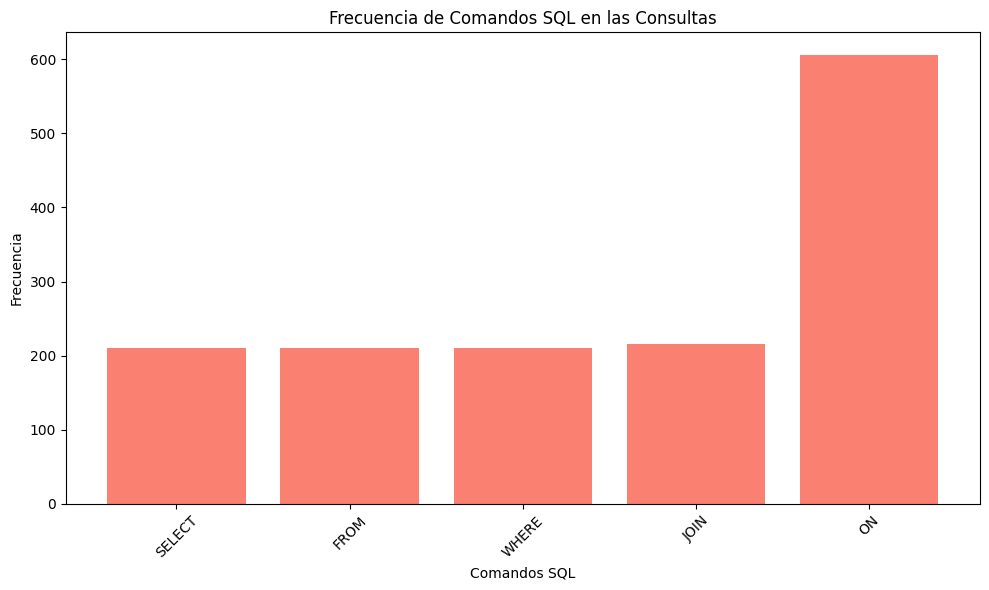

In [64]:
# Gráfico de barras para los comandos SQL
plt.figure(figsize=(10,6))
plt.bar(sql_counter.keys(), sql_counter.values(), color='salmon')
plt.xlabel('Comandos SQL')
plt.ylabel('Frecuencia')
plt.title('Frecuencia de Comandos SQL en las Consultas')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Testear validez queries

In [73]:
from sqlalchemy.exc import SQLAlchemyError

# --- Función para ejecutar las consultas y comprobar si hay algún error ---
def ejecutar_consultas(df, db):
    # Lista para almacenar los resultados
    resultados = []

    for idx, row in df.iterrows():
        consulta = row['Consulta']

        try:
            # Ejecutar la consulta
            db.run(consulta)
            
        except SQLAlchemyError as e:
            # Capturar y registrar el error
            error_msg = str(e.__dict__['orig']) if e.__dict__.get('orig') else str(e)
          
            # Añadir el resultado a la lista
            resultados.append([idx, error_msg])
    
    return resultados

ejecutar_consultas(sampled_df, db)

[]